In [1]:
import sys
# !{sys.executable} -m pip install git+https://github.com/zotko/xyz2graph.git
import shap
from collections import Counter

from tqdm.notebook import trange, tqdm
from time import sleep, perf_counter

import os
from glob import glob
import pandas as pd
import numpy as np
import networkx as nx
from scipy.spatial import distance_matrix

# Scikit-learn
from sklearn.model_selection import KFold
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error
from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


# Reps
from alchemical_cms import genpaddedCMs
from dscribe.descriptors import SOAP
from dscribe.kernels import REMatchKernel
from mendeleev.fetch import fetch_table
from ase.io import read
from Element_PI import VariancePersist
from Element_PI import VariancePersistv1

# from rdkit import DataStructs
# from rdkit import Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import Draw, MACCSkeys
# from openbabel import openbabel as ob
# from openbabel import pybel

from xyz2graph import MolGraph, to_networkx_graph, to_plotly_figure
# from plotly.offline import offline
#Plotting
import seaborn as sns
sns.set_style()
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi'] = 200


/Users/grierjones/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Number of monomers is equivalent to monomers+CO2: True
Using the intersection of the sets of length: 0

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


In [2]:
AA_df=pd.read_excel('20_AA_CO2_interaction_energy_DFT_PBE0D3BJ_def2TZVPP.xlsx',index_col=0,header=None)
AA_df.index=[i.replace(' acid','').capitalize() if 'acid' in i else i.capitalize() for i in AA_df.index]

# rdkit.Chem.rdMolDescriptors.CalcNumRotatableBonds((Mol)mol, (bool)strict) → int


In [3]:
df=pd.read_excel('site_data.xlsx',index_col=0)
sitelist=['A_carboxy', 'A_amine', 'B_carboxy', 'B_amine', 'A_link','B_link', 'A_side', 'B_side']
inter_df=df[sitelist].dropna()
# inter_df[inter_df!=0]=1

In [4]:
df['Interaction_Energy'].describe()

count    400.000000
mean      -5.243077
std        0.902996
min       -9.129920
25%       -5.800167
50%       -5.127589
75%       -4.629300
max       -3.255937
Name: Interaction_Energy, dtype: float64

In [5]:


y=pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx',usecols=[1,2],index_col=0)
y['keypair']=['_'.join(i.split('_')[:3]) for i in y.index]
pairs=pd.DataFrame([(i[0].split(":")[0],i[0].split(":")[1].replace(" ","").replace('acid','')) for i in pd.read_excel('400_dipeptides_interaction_energy_UPDATED2.xlsx', 'Sheet2',header=None).values]).set_index(0)


# Find set of files
monomerfiles={}        
co2files={}
for k,v in pairs.to_dict()[1].items():
    try:
        path=glob(f'./dipeptides_co2_coordinates/{k}_*.xyz')[0]
        monpath=f'./dipeptides_coordinates/{k}.xyz'
        if os.path.exists(path) and os.path.exists(monpath):
            co2files[v]=path    
            monomerfiles[v]=monpath
    except:
        print(k)
        
# Name check
co2check=['_'.join(i.split('/')[-2].split('_')[:3]) for i in co2files.values()]
moncheck=['_'.join(i.split('/')[-2].split('_')[:4]) for i in monomerfiles.values()]

In [6]:
AAs=sorted(set([i[0].split('-')[0].replace('acid','') for i in pairs.values]))

In [7]:
noncarboyx=inter_df[(inter_df[['A_carboxy','B_carboxy']]==0).all(axis=1)]

In [8]:
noncarboyx

A_carboxy  A_amine  B_carboxy  B_amine  A_link  \
Alanine-Lysine                  0        0          0        1       0   
Arginine-Aspartic               0        0          0        0       0   
Arginine-Cysteine               0        0          0        0       0   
Arginine-Lysine                 0        0          0        0       0   
Arginine-Phenylalanine          0        1          0        1       0   
...                           ...      ...        ...      ...     ...   
Tryptophan-Proline              0        0          0        0       0   
Tryptophan-Tryptophan           0        0          0        0       0   
Tyrosine-Arginine               0        0          0        2       0   
Tyrosine-Lysine                 0        1          0        0       0   
Valine-Isoleucine               0        1          0        2       0   

                        B_link  A_side  B_side  
Alanine-Lysine               0       0       2  
Arginine-Aspartic            0       0       3  
Arginine-Cysteine            0       3       0  
Arginine-Lysine              0       3       0  
Arginine-Phenylalanine       0       0       1  
...                        ...     ...     ...  
Tryptophan-Proline           0       3       0  
Tryptophan-Tryptophan        0       0       3  
Tyrosine-Arginine            0       0       1  
Tyrosine-Lysine              0       0       2  
Valine-Isoleucine            0       0       0  

[66 rows x 8 columns]

In [9]:

co2dipepgraphs={}
co2mgs={}
for k,v in co2files.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    co2mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    co2dipepgraphs[k]=G
    
dipepgraphs={}    
mgs={}
for k,v in monomerfiles.items():
    # Create the MolGraph object
    mg = MolGraph()

    # Read the data from the .xyz file
    mg.read_xyz(v)
    mgs[k]=mg
    # Convert the molecular graph to the NetworkX graph
    G = to_networkx_graph(mg)
    dipepgraphs[k]=G    


In [10]:
# FLAG!
# df.loc['Asparagine-Alanine']
# fig = to_plotly_figure(co2mgs['Asparagine-Alanine'])
# offline.plot(fig)

# FLAG THIS ONE!!
# fig = to_plotly_figure(co2mgs['Alanine-Lysine'])
# offline.plot(fig)

In [11]:
for k,v in pairs.to_dict()[1].items():
    names=v.split('-')
    for j in names:
        if 'acid' in j:
            print(names)

In [12]:
AAs

['Alanine',
 'Arginine',
 'Asparagine',
 'Aspartic',
 'Cysteine',
 'Glutamic',
 'Glutamine',
 'Glycine',
 'Histidine',
 'Isoleucine',
 'Leucine',
 'Lysine',
 'Methionine',
 'Phenylalanine',
 'Proline',
 'Serine',
 'Threonine',
 'Tryptophan',
 'Tyrosine',
 'Valine']

In [13]:
df.loc['Glycine-Proline']['Interaction_Energy']

-3.3692837

In [14]:
df.loc['Glycine-Proline']['label']

'AA_AA_155'

In [15]:
AA_df.loc['Glycine'],AA_df.loc['Proline']

(1   -3.82
 Name: Glycine, dtype: float64,
 1   -4.25
 Name: Proline, dtype: float64)

In [16]:
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(X)

# pcadf['pca-one'] = pca_result[:,0]
# pcadf['pca-two'] = pca_result[:,1] 
# # pcadf['pca-three'] = pca_result[:,2]
# print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))
# print(sum(pca.explained_variance_ratio_))
# plt.figure(figsize=(16,10))
# sns.scatterplot(
#     x="pca-one", y="pca-two",
#     # hue='A_side',
#     palette=sns.color_palette("hls", 8),
#     data=pcadf,
#     legend="full"
# )

# # sns.scatterplot(
# #     x="pca-one", y="pca-three",
# #     hue='Interaction_Energy',
# #     palette=sns.color_palette("hls", 8),
# #     data=pcadf,
# #     legend="full"
# # )


In [17]:
sorted_IE={}
all_energies=pd.DataFrame(columns=AAs,index=AAs)
IE_df=pd.DataFrame(columns=AAs,index=AAs)
glygly_df=pd.DataFrame(columns=AAs,index=AAs)
for A in AAs:
    sorted_IE[A]={B:df['Interaction_Energy'].to_dict()['-'.join((A,B))] for B in AAs}
    for B in AAs:
        IE_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join((A,A))]
        glygly_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join(('Glycine','Glycine'))]
        all_energies[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/4294904025.py:8: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  IE_df[A].loc[B]=df['Interaction_Energy'].to_dict()['-'.join((A,B))]-df['Interaction_Energy'].to_dict()['-'.join((A

In [18]:
df['Interaction_Energy'].describe().to_excel('describe_dipep_IE.xlsx')

In [19]:
minDF=pd.DataFrame([all_energies.astype(float).idxmax(),all_energies.astype(float).max()]).T.rename(columns={0:'idxmin',1:'min'})

In [20]:
minDF['idxmin'][minDF['idxmin']=='Glycine']

Alanine       Glycine
Asparagine    Glycine
Aspartic      Glycine
Cysteine      Glycine
Leucine       Glycine
Methionine    Glycine
Proline       Glycine
Threonine     Glycine
Valine        Glycine
Name: idxmin, dtype: object

In [21]:
df.loc[[f'{k}-{v}' for k,v in minDF['idxmin'][minDF['idxmin']=='Glycine'].to_dict().items()]].sum()

A_carboxy                                                             9
A_amine                                                               1
B_carboxy                                                            10
B_amine                                                               4
A_link                                                                0
B_link                                                                0
A_side                                                                3
B_side                                                                0
Interaction_Energy                                           -32.450688
label                 AA_AA_8AA_AA_48AA_AA_68AA_AA_88AA_AA_208AA_AA_...
dtype: object

In [22]:
maxDF=pd.DataFrame([all_energies.astype(float).idxmin(),all_energies.astype(float).min()]).T.rename(columns={0:'idxmax',1:'max'})

In [23]:
maxDF

idxmax       max
Alanine         Histidine -6.153144
Arginine       Isoleucine -6.775149
Asparagine       Cysteine -8.385684
Aspartic       Asparagine -6.254249
Cysteine           Valine -5.952468
Glutamic       Asparagine -8.313269
Glutamine        Glutamic -7.228973
Glycine        Asparagine -5.795107
Histidine        Glutamic -7.889352
Isoleucine        Proline  -9.12992
Leucine        Asparagine  -6.98373
Lysine          Histidine -6.909689
Methionine         Lysine -6.937073
Phenylalanine    Arginine -6.650854
Proline          Tyrosine -8.273217
Serine          Glutamine -6.608813
Threonine          Serine -7.062454
Tryptophan      Threonine -7.636904
Tyrosine          Glycine -7.870359
Valine          Glutamine -5.949749

In [24]:
sum([[f'{k} {v:.4f} kcal/mol'] for k,v in maxDF['max'].astype(float).describe().to_dict().items()],[])

['count 20.0000 kcal/mol',
 'mean -7.1380 kcal/mol',
 'std 0.9374 kcal/mol',
 'min -9.1299 kcal/mol',
 '25% -7.8751 kcal/mol',
 '50% -6.9604 kcal/mol',
 '75% -6.5202 kcal/mol',
 'max -5.7951 kcal/mol']

In [25]:
aa_color_dct=dict(zip(AA_df.index,sns.color_palette('Paired',len(AA_df))))

In [26]:
df.loc[[f"{k}-{v}" for k,v in minDF['idxmin'].to_dict().items()]]['Interaction_Energy'].describe()

count    20.000000
mean     -3.736495
std       0.426222
min      -4.777702
25%      -3.880914
50%      -3.576564
75%      -3.419890
max      -3.255937
Name: Interaction_Energy, dtype: float64

In [27]:
df.loc[[f"{k}-{v}" for k,v in maxDF['idxmax'].to_dict().items()]]['Interaction_Energy'].describe()

count    20.000000
mean     -7.138008
std       0.937389
min      -9.129920
25%      -7.875108
50%      -6.960401
75%      -6.520172
max      -5.795107
Name: Interaction_Energy, dtype: float64

In [28]:
df

A_carboxy  A_amine  B_carboxy  B_amine  A_link  B_link  \
Alanine-Alanine             0        0          2        1       0       0   
Alanine-Arginine            0        0          1        1       0       0   
Alanine-Asparagine          2        0          0        0       0       0   
Alanine-Aspartic            2        0          0        0       0       1   
Alanine-Cysteine            2        0          0        0       0       0   
...                       ...      ...        ...      ...     ...     ...   
Valine-Serine               0        1          1        0       1       0   
Valine-Threonine            1        0          0        0       0       0   
Valine-Tryptophan           2        1          0        0       0       0   
Valine-Tyrosine             1        1          0        0       0       0   
Valine-Valine               2        0          0        0       0       1   

                    A_side  B_side  Interaction_Energy      label  
Alanine-Alanine          0       0           -4.032639    AA_AA_1  
Alanine-Arginine         0       1           -5.392723    AA_AA_2  
Alanine-Asparagine       0       1           -5.716392    AA_AA_3  
Alanine-Aspartic         0       0           -5.247079    AA_AA_4  
Alanine-Cysteine         0       1           -4.872244    AA_AA_5  
...                    ...     ...                 ...        ...  
Valine-Serine            0       0           -5.861945  AA_AA_396  
Valine-Threonine         1       1           -4.461757  AA_AA_397  
Valine-Tryptophan        0       0           -5.625054  AA_AA_398  
Valine-Tyrosine          0       1           -4.655518  AA_AA_399  
Valine-Valine            0       0           -4.203215  AA_AA_400  

[400 rows x 10 columns]

In [29]:
df.loc[[i[0]+'-'+i[1] for i in minDF.reset_index().to_numpy()]].sum()

A_carboxy                                                            31
A_amine                                                               1
B_carboxy                                                            12
B_amine                                                               5
A_link                                                                0
B_link                                                                1
A_side                                                                7
B_side                                                                3
Interaction_Energy                                           -74.729891
label                 AA_AA_8AA_AA_40AA_AA_48AA_AA_68AA_AA_88AA_AA_1...
dtype: object

In [30]:
df.loc[[i[0]+'-'+i[1] for i in maxDF.reset_index().to_numpy()]].sum()

A_carboxy                                                            15
A_amine                                                               6
B_carboxy                                                            10
B_amine                                                               2
A_link                                                                1
B_link                                                                1
A_side                                                                7
B_side                                                               18
Interaction_Energy                                          -142.760156
label                 AA_AA_9AA_AA_30AA_AA_45AA_AA_63AA_AA_100AA_AA_...
dtype: object

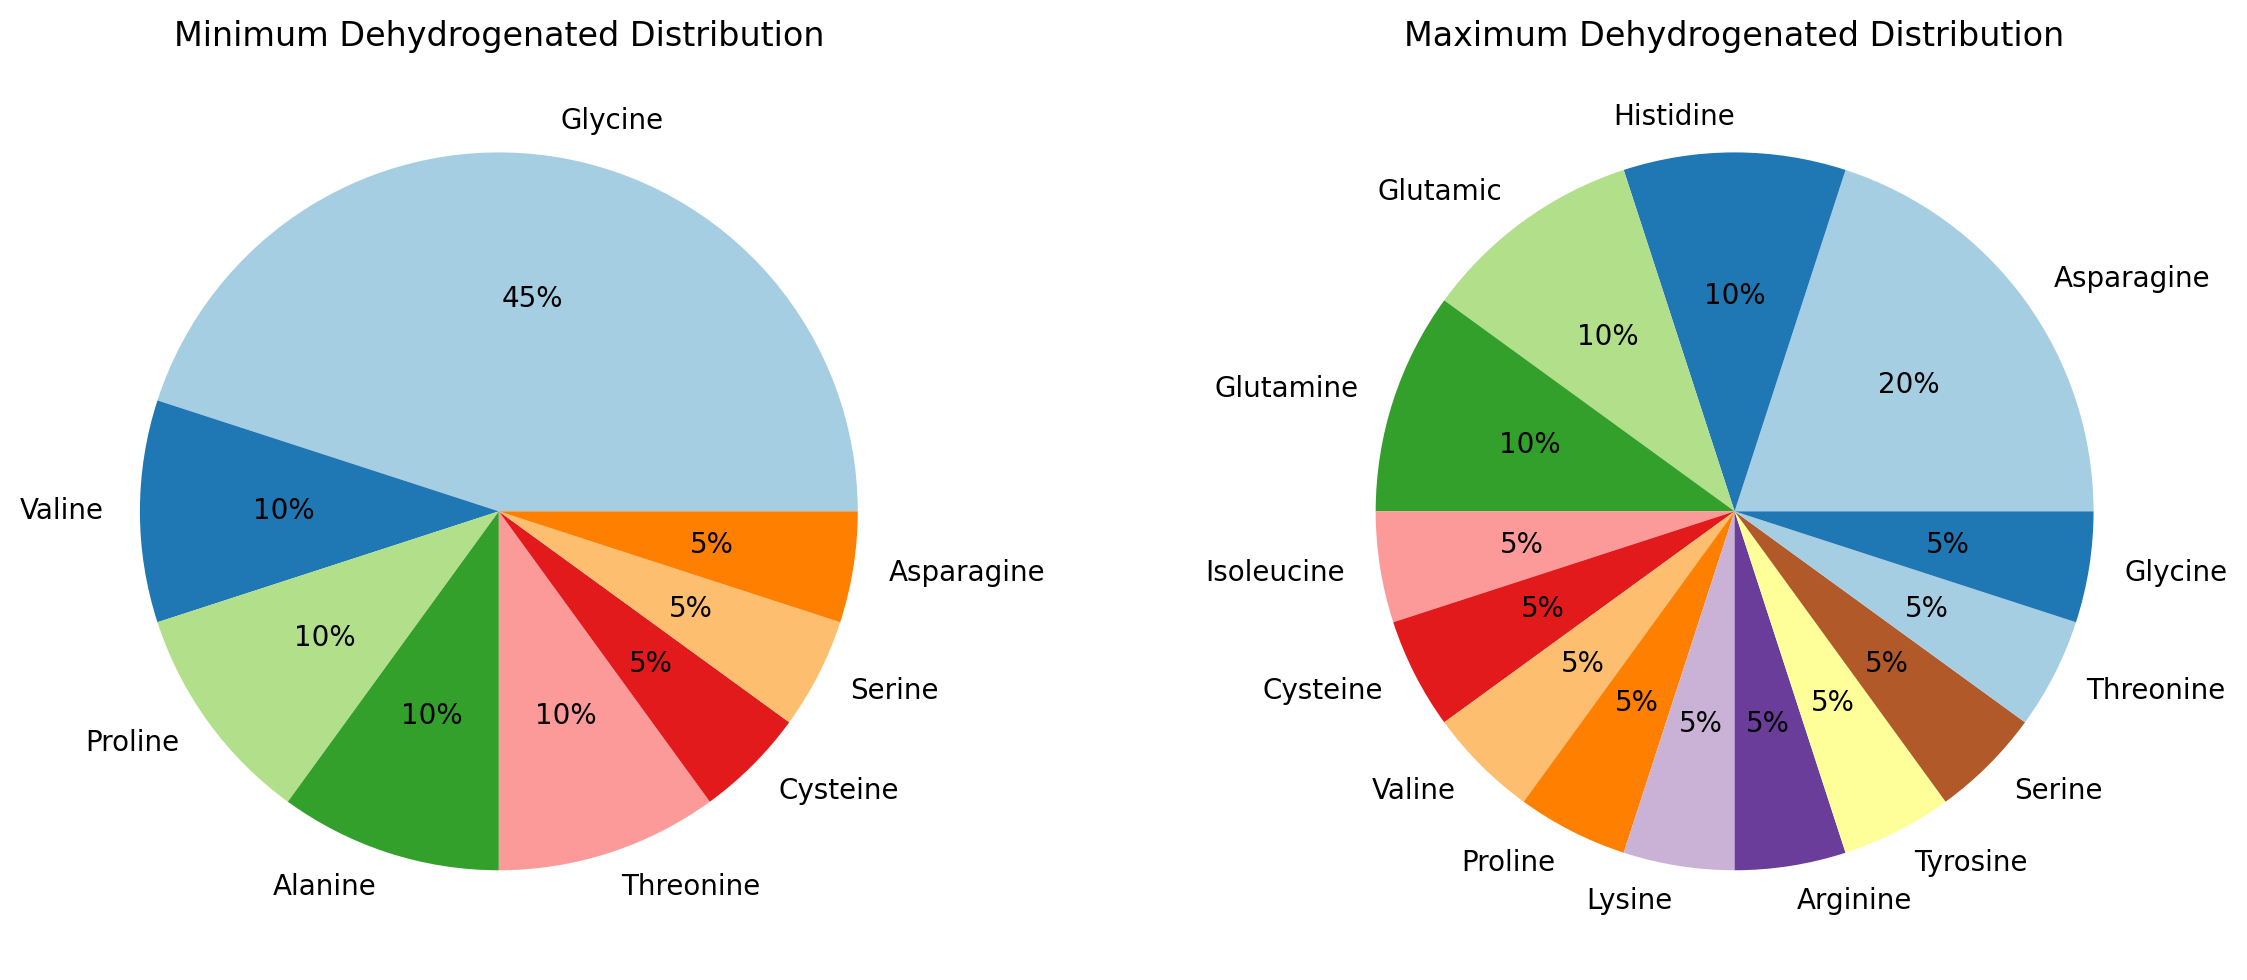

In [31]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,5))

cntidmin=minDF['idxmin'].value_counts()
mincmap=sns.color_palette('Paired',len(cntidmin))
ax1.pie(cntidmin.values, labels = cntidmin.index, autopct='%.0f%%',colors=mincmap)
ax1.set_title('Minimum Dehydrogenated Distribution')

cntidmax=maxDF['idxmax'].value_counts()
maxcmap=sns.color_palette('Paired',len(cntidmax)-1)+[sns.color_palette('Paired',2)[1]]
ax2.pie(cntidmax.values, labels = cntidmax.index, autopct='%.0f%%',colors=maxcmap)
ax2.set_title('Maximum Dehydrogenated Distribution')
plt.tight_layout()
plt.savefig('dehydrogenated_dis.png',dpi=300,bbox_inches='tight')
plt.show()




In [155]:
df.loc[['-'.join(i) for i in minDF['idxmin'].reset_index().to_numpy() if i[1]=='Glycine']][sitelist].sum().sort_values()

A_link        0
B_link        0
B_side        0
A_amine       1
A_side        3
B_amine       4
A_carboxy     9
B_carboxy    10
dtype: int64

In [158]:
['-'.join(i) for i in minDF['idxmin'].reset_index().to_numpy() if i[1]=='Glycine']

['Alanine-Glycine',
 'Asparagine-Glycine',
 'Aspartic-Glycine',
 'Cysteine-Glycine',
 'Leucine-Glycine',
 'Methionine-Glycine',
 'Proline-Glycine',
 'Threonine-Glycine',
 'Valine-Glycine']

['Alanine-Histidine',
 'Lysine-Histidine',
 'Glutamine-Glutamic',
 'Histidine-Glutamic',
 'Serine-Glutamine',
 'Valine-Glutamine']

In [194]:
df[sitelist].loc[["-".join(i) for i in np.vstack([maxDF['idxmax'].reset_index().to_numpy()[maxDF['idxmax'].reset_index().to_numpy()[:,1]==B] for B in ["Histidine","Glutamic","Glutamine"]])]].sum().sort_values()

B_amine      0
A_link       0
B_link       1
A_side       1
A_amine      2
B_carboxy    2
B_side       5
A_carboxy    7
dtype: int64

In [169]:
df.loc[['-'.join(i) for i in maxDF['idxmax'].reset_index().to_numpy() if i[1]=='Asparagine']][sitelist].sum().sort_values()


B_amine      0
A_link       0
B_link       0
A_side       0
A_amine      1
B_carboxy    1
A_carboxy    4
B_side       6
dtype: int64

In [168]:
['-'.join(i) for i in maxDF['idxmax'].reset_index().to_numpy() if i[1]=='Asparagine']


['Aspartic-Asparagine',
 'Glutamic-Asparagine',
 'Glycine-Asparagine',
 'Leucine-Asparagine']

In [33]:
outliers=df['Interaction_Energy'][df['Interaction_Energy']<df['Interaction_Energy'].describe()['25%']-1.5*(df['Interaction_Energy'].describe()['75%']-df['Interaction_Energy'].describe()['25%'])].index

In [34]:
df['Interaction_Energy'].loc[outliers]

Asparagine-Cysteine    -8.385684
Glutamic-Asparagine    -8.313269
Histidine-Glutamic     -7.889352
Isoleucine-Proline     -9.129920
Proline-Tyrosine       -8.273217
Tryptophan-Threonine   -7.636904
Tyrosine-Glycine       -7.870359
Name: Interaction_Energy, dtype: float64

In [106]:
df['Interaction_Energy'].idxmin(),df['Interaction_Energy'].min().round(2)

('Isoleucine-Proline', -9.13)

In [107]:
df['Interaction_Energy'].idxmax(),df['Interaction_Energy'].max().round(2)

('Serine-Serine', -3.26)

In [102]:
df['Interaction_Energy'].describe().round(2)

count    400.00
mean      -5.24
std        0.90
min       -9.13
25%       -5.80
50%       -5.13
75%       -4.63
max       -3.26
Name: Interaction_Energy, dtype: float64

In [105]:
AA_df.describe().round(2)

1
count  20.00
mean   -4.69
std     0.73
min    -6.24
25%    -5.08
50%    -4.58
75%    -4.08
max    -3.82

In [113]:
all_energies.astype(float).describe().loc['max'].describe().round(2)

count    20.00
mean     -3.74
std       0.43
min      -4.78
25%      -3.88
50%      -3.58
75%      -3.42
max      -3.26
Name: max, dtype: float64

In [114]:
all_energies.astype(float).describe().loc['min'].describe().round(2)

count    20.00
mean     -7.14
std       0.94
min      -9.13
25%      -7.88
50%      -6.96
75%      -6.52
max      -5.80
Name: min, dtype: float64

/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/526068579.py:2: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.boxplot(data=pd.concat([AA_df,df['Interaction_Energy']]).rename(columns={"Interaction_Energy":'Dipeptides',1:'Amino Acids'}),ax=ax1,palette=sns.color_palette('Paired'))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/526068579.py:6: UserWarning: 
The palette list has fewer values (12) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=all_energies,ax=ax2,palette=sns.color_palette('Paired'))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/526068579.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")


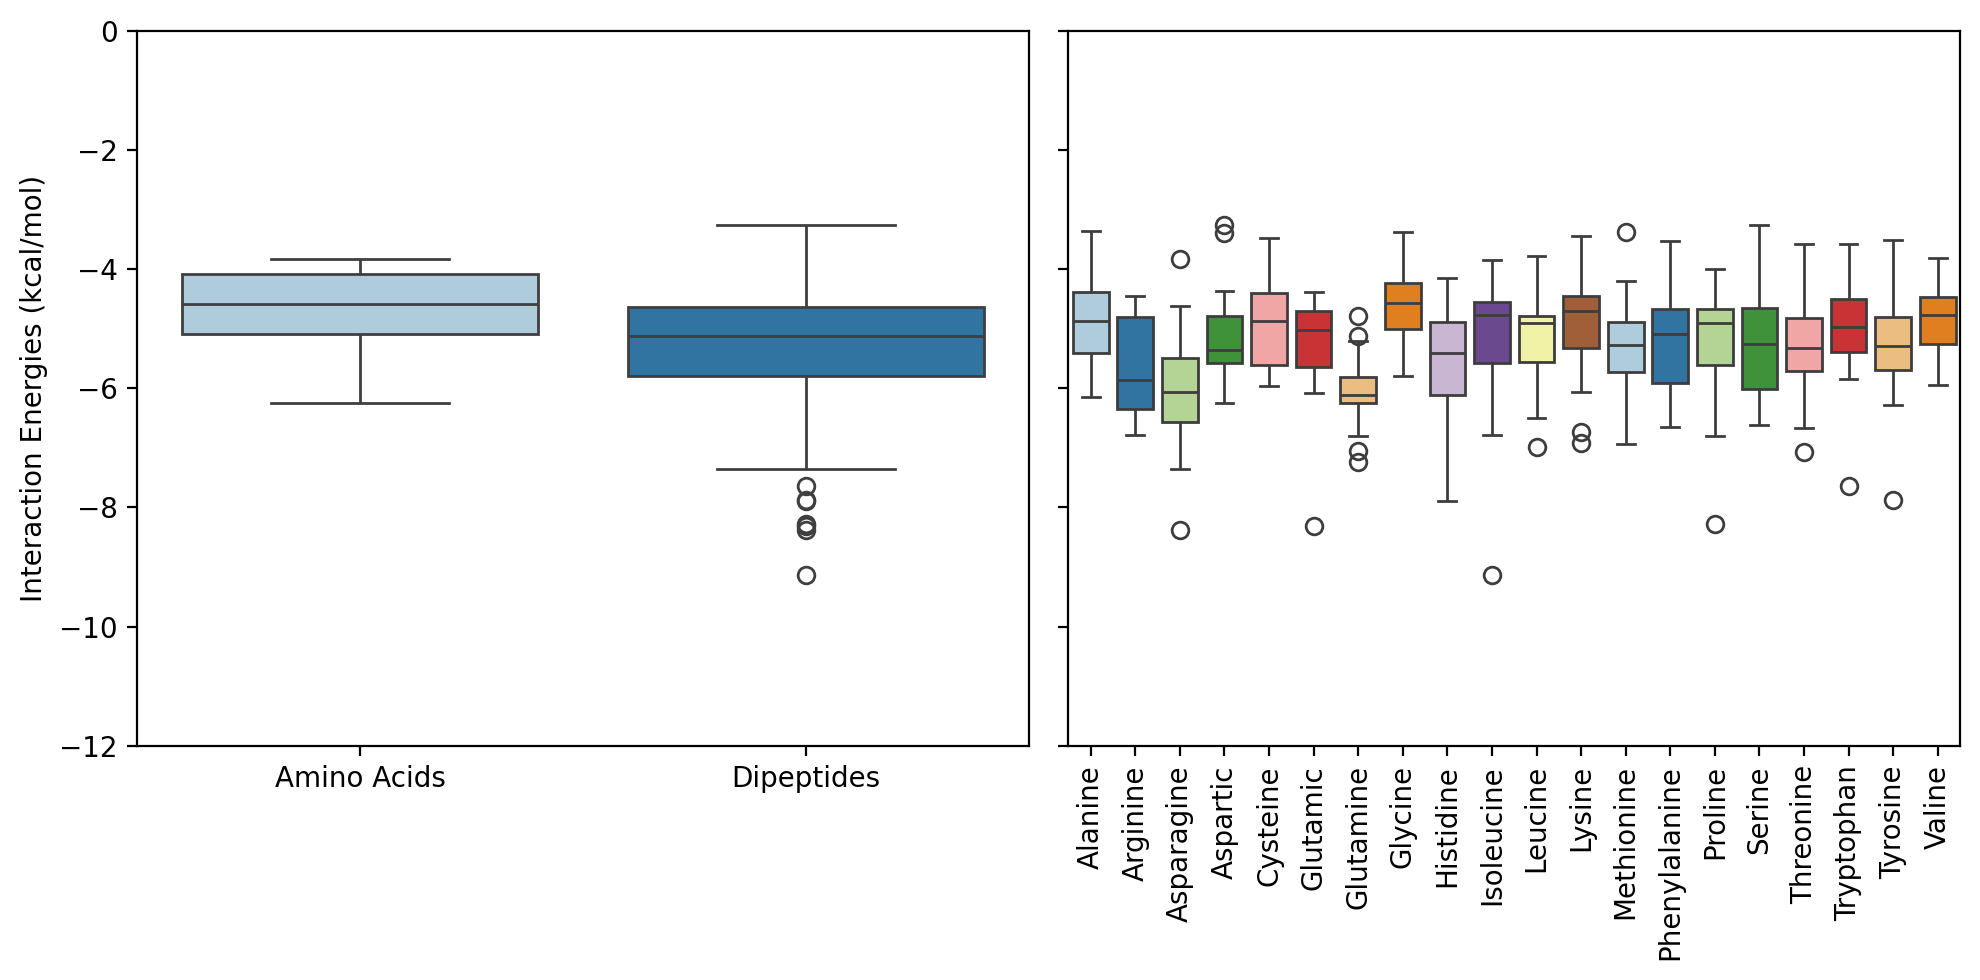

In [93]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5),sharey=True)
sns.boxplot(data=pd.concat([AA_df,df['Interaction_Energy']]).rename(columns={"Interaction_Energy":'Dipeptides',1:'Amino Acids'}),ax=ax1,palette=sns.color_palette('Paired'))

ax1.set_ylim(-12,0)
ax1.set_ylabel('Interaction Energies (kcal/mol)')
sns.boxplot(data=all_energies,ax=ax2,palette=sns.color_palette('Paired'))
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")

plt.tight_layout()
plt.savefig('boxplot_IEs_vs_AAs.png',dpi=300,bbox_inches='tight')

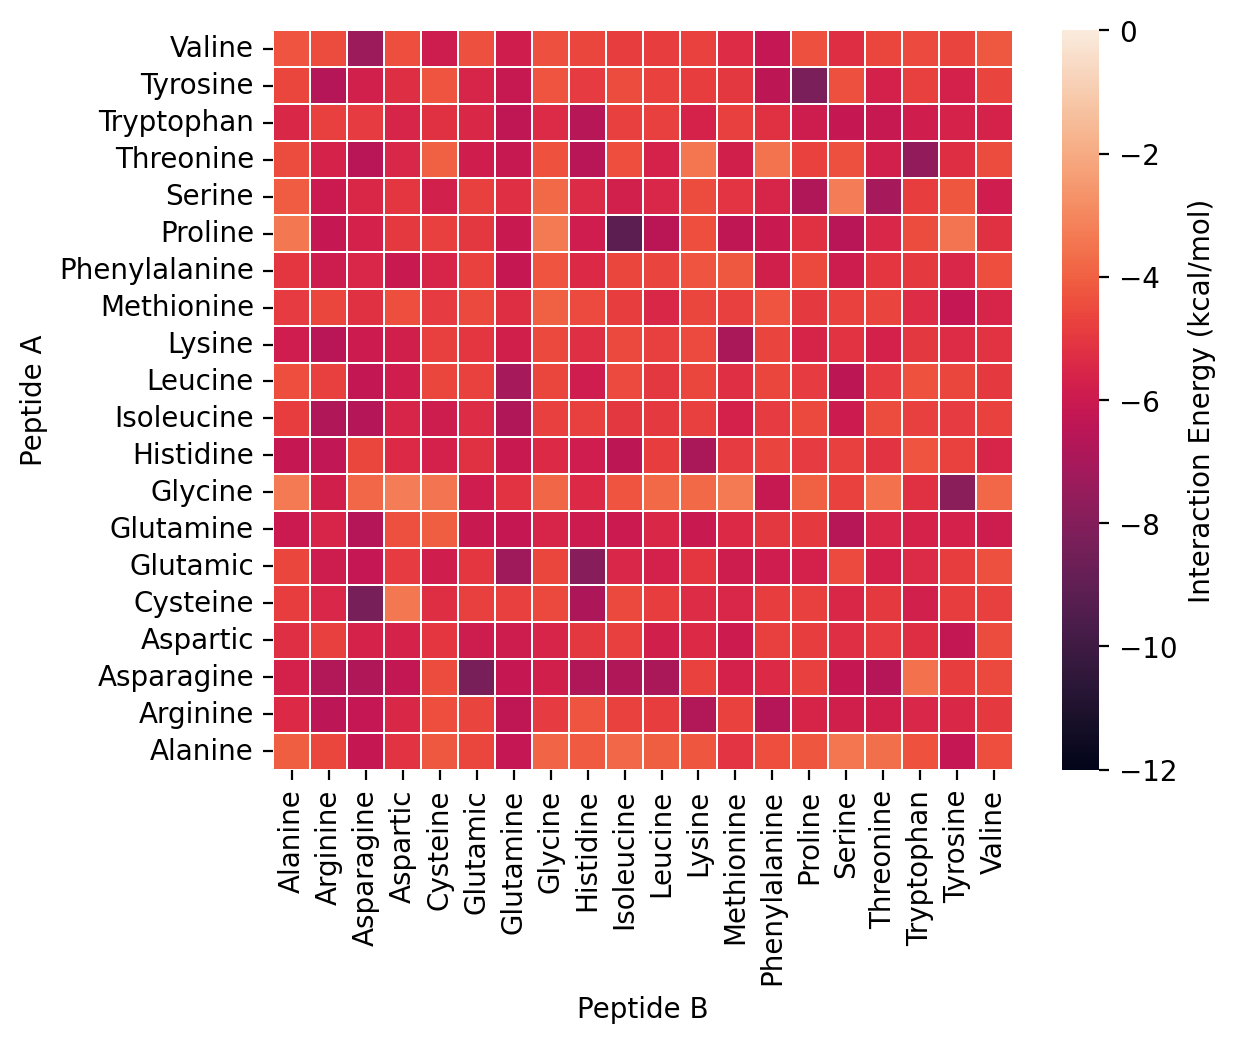

In [37]:

ax=sns.heatmap(data=all_energies.astype(float),cmap=sns.cm.rocket, linewidth=.01,cbar_kws={'label': 'Interaction Energy (kcal/mol)'}, vmin=-12, vmax=0,square=True)
ax.invert_yaxis()
plt.xlabel('Peptide B')
plt.ylabel('Peptide A')
plt.savefig('pair_heat.png',dpi=300,bbox_inches='tight')
plt.show()

In [38]:
palette=sns.color_palette('Paired',20)
markers=['o','x','^','1','*']

In [39]:
from matplotlib import cm
from matplotlib.ticker import LinearLocator


data_3D=[]
for idx,A in enumerate(AA_df.index):
    for idxb,B in enumerate(AA_df.index):
        data_3D.append([AA_df.loc[A].values[0],AA_df.loc[B].values[0],all_energies[A][B]])
data_3D=np.array(data_3D)

X=data_3D[:,0]
Y=data_3D[:,1]
Z=data_3D[:,2].reshape(-1,1)



# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.scatter(X, Y, Z)
# # X, Y = np.meshgrid(X, Y)

# # # Plot the surface.
# # surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,
# #                        linewidth=0, antialiased=False)

# # # Customize the z axis.
# # # ax.set_zlim(-1.01, 1.01)
# # ax.zaxis.set_major_locator(LinearLocator(10))
# # # A StrMethodFormatter is used automatically
# # ax.zaxis.set_major_formatter('{x:.02f}')

# # # Add a color bar which maps values to colors.
# # fig.colorbar(surf, shrink=0.5, aspect=5)

# # Rotate the axes and update
# for angle in range(0, 360*4 + 1):
#     # Normalize the angle to the range [-180, 180] for display
#     angle_norm = (angle + 180) % 360 - 180

#     # Cycle through a full rotation of elevation, then azimuth, roll, and all
#     elev = azim = roll = 0
#     if angle <= 360:
#         elev = angle_norm
#     elif angle <= 360*2:
#         azim = angle_norm
#     elif angle <= 360*3:
#         roll = angle_norm
#     else:
#         elev = azim = roll = angle_norm

#     # Update the axis view and title
#     ax.view_init(elev, azim, roll)
#     plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

#     plt.draw()
#     plt.pause(.001)

# # plt.show()


[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 400 samples in 0.000s...
[t-SNE] Computed neighbors for 400 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 400 / 400
[t-SNE] Mean sigma: 0.489801
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.459656
[t-SNE] KL divergence after 950 iterations: 0.521516


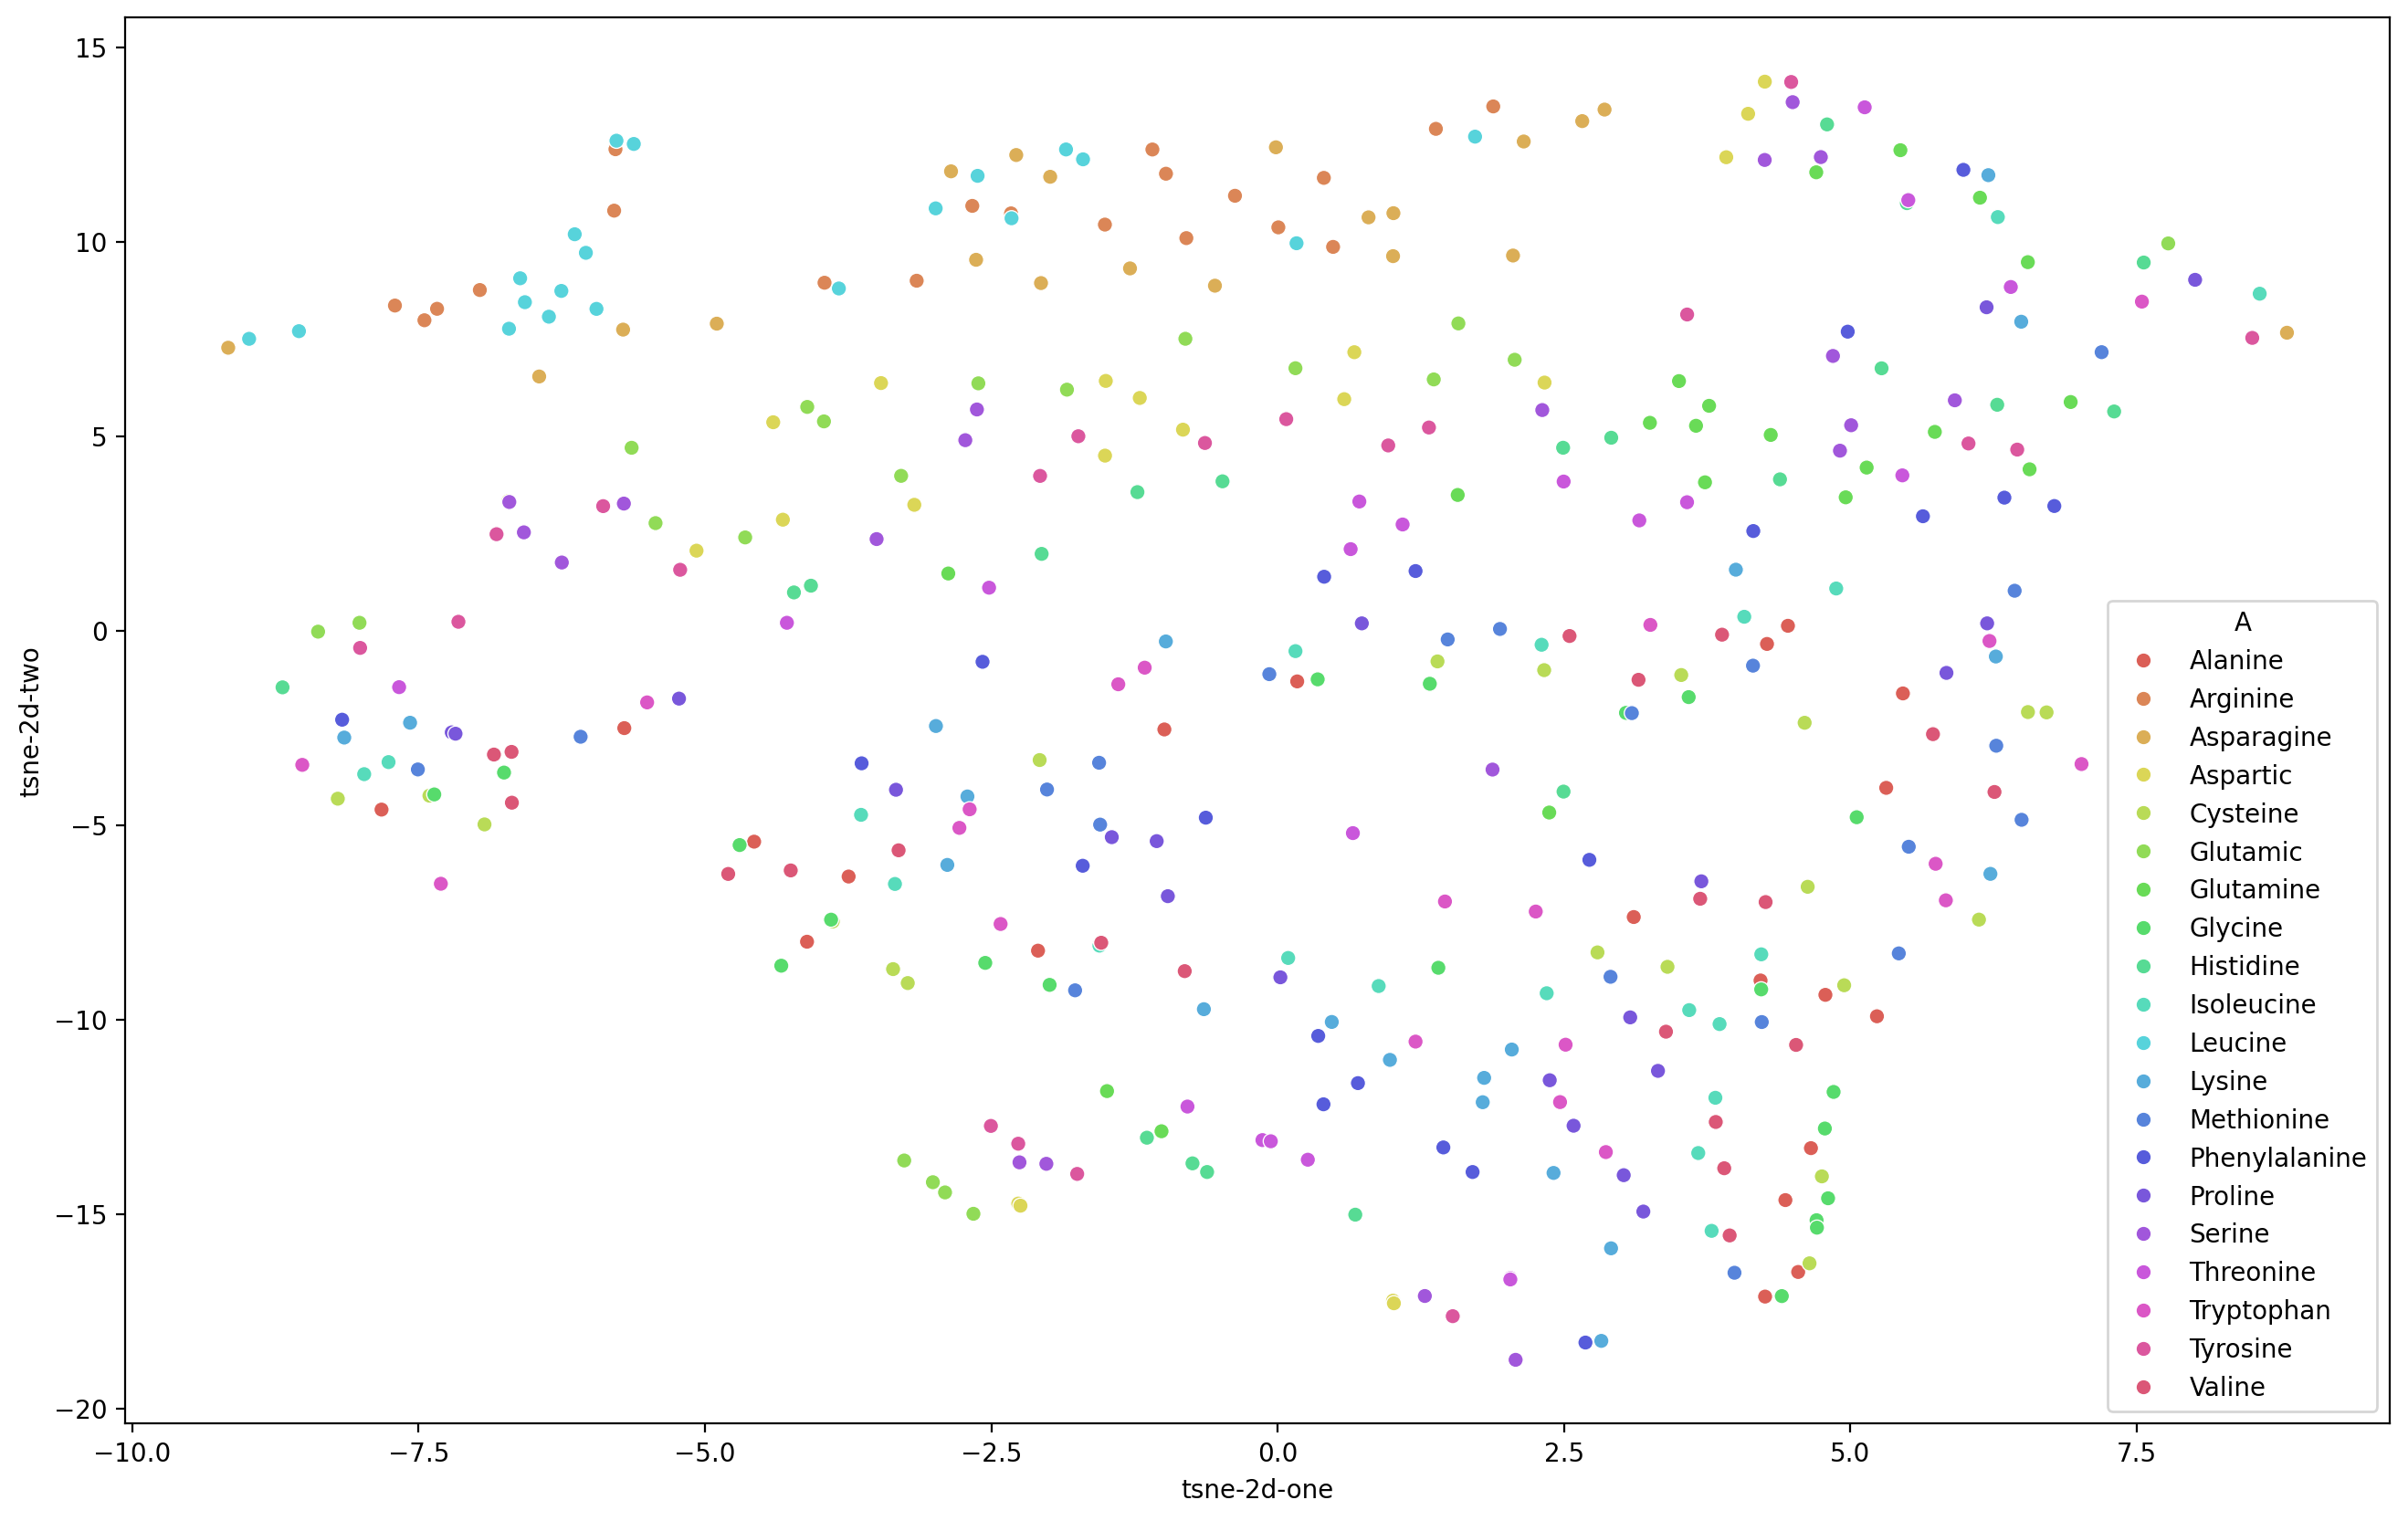

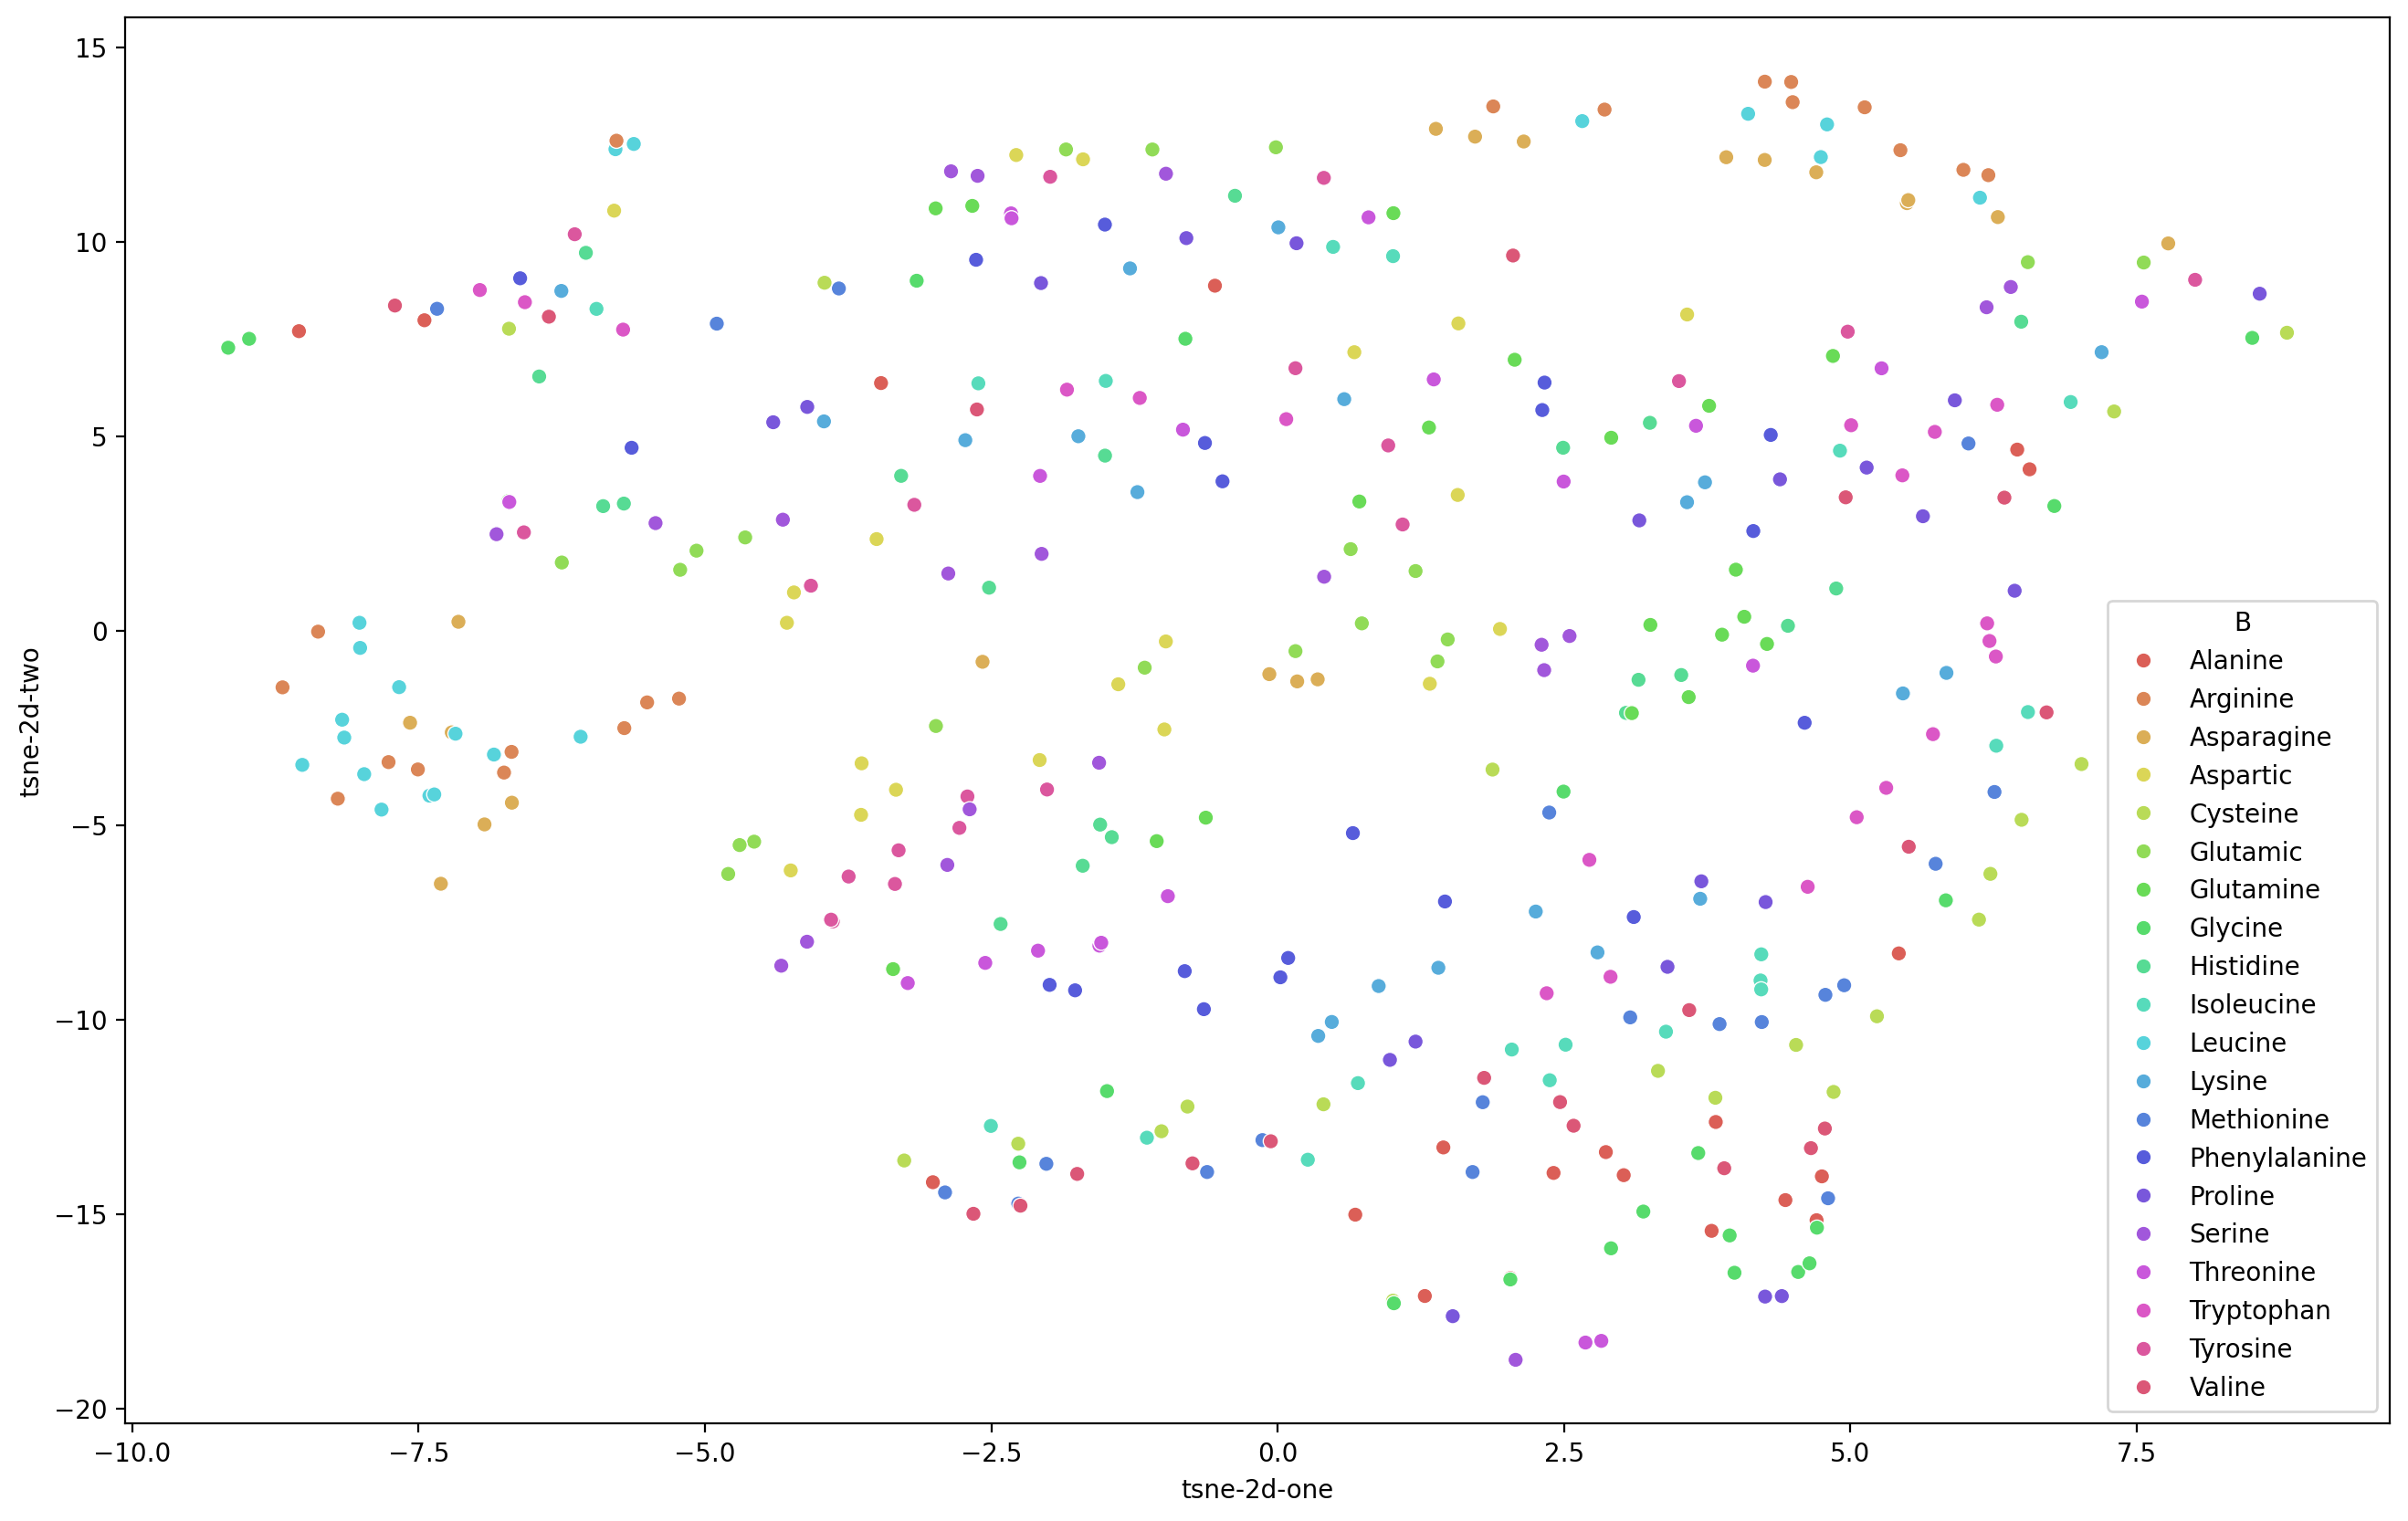

In [40]:



tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=5000,init='random',learning_rate='auto')
tsne_results = tsne.fit_transform(data_3D)

pcadf=pd.DataFrame(columns=['tsne-2d-one','tsne-2d-two'])
pcadf['tsne-2d-one'] = tsne_results[:,0]
pcadf['tsne-2d-two'] = tsne_results[:,1]
pcadf.index=df.index

AB=np.array([i.split('-') for i in pcadf.index])

pcadf['A']=AB[:,0]
pcadf['B']=AB[:,1]



plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='A',
    palette=sns.color_palette("hls", 20),
    data=pcadf,
    legend="full"
)
plt.show()

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue='B',
    palette=sns.color_palette("hls", 20),
    data=pcadf,
    legend="full"
)
plt.show()



In [41]:
greaterdehydroxy=pd.concat([(all_energies[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1)
greaterdehydro=pd.concat([(all_energies.T[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1)
greaterdehydroxy_int=greaterdehydroxy.T.sum()
greaterdehydro_int=pd.concat([(all_energies.T[A]<=AA_df.loc[A].values[0]).value_counts() for idx,A in enumerate(AA_df.index)],axis=1).T.sum()

In [42]:
df[sitelist].loc[[f'Leucine-{i}' for i in all_energies['Leucine'][AA_df.loc['Leucine'].values[0]<all_energies['Leucine']].index]].sum().sort_values()

A_amine       0
A_link        0
B_link        1
B_amine       6
A_side        7
B_carboxy    10
B_side       11
A_carboxy    19
dtype: int64

In [43]:
df[sitelist].loc[[f'Arginine-{i}' for i in all_energies['Arginine'][AA_df.loc['Arginine'].values[0]<all_energies['Arginine']].index]].sum().sort_values()

B_link        0
B_amine       1
A_link        1
A_amine       2
B_carboxy     5
A_side        9
A_carboxy    11
B_side       13
dtype: int64

In [44]:
all_energies.loc[['Leucine','Arginine']]

Alanine  Arginine Asparagine  Aspartic  Cysteine  Glutamic  \
Leucine  -4.406323 -4.751297   -6.27577 -5.820056 -4.617431 -4.701178   
Arginine -5.392723 -6.424013  -6.195343 -5.470038 -4.425922 -4.648634   

         Glutamine   Glycine Histidine Isoleucine   Leucine    Lysine  \
Leucine   -7.05393 -4.628204 -5.889654  -4.541969 -5.009342 -4.600912   
Arginine -6.367689 -4.883341  -4.26918  -4.696376 -4.860229 -6.733916   

         Methionine Phenylalanine   Proline    Serine Threonine Tryptophan  \
Leucine   -5.207944     -4.610531 -4.909183 -6.405307 -4.884668  -4.338906   
Arginine   -4.71533     -6.650854 -5.600397 -5.771862 -5.800714  -5.503352   

          Tyrosine    Valine  
Leucine  -4.627839 -4.933344  
Arginine -5.461052 -4.961139

In [45]:
all_energies[['Leucine','Arginine']]

Leucine  Arginine
Alanine        -4.07243  -4.61971
Arginine      -4.860229 -6.424013
Asparagine     -6.98373  -6.72503
Aspartic      -5.771067 -4.822591
Cysteine      -4.860112 -5.504983
Glutamic      -5.707557 -5.930735
Glutamine     -5.470807  -5.56053
Glycine       -3.774012 -5.799984
Histidine     -4.836956 -6.311198
Isoleucine    -4.948952 -6.775149
Leucine       -5.009342 -4.751297
Lysine        -4.808374 -6.531635
Methionine    -5.473714 -4.624209
Phenylalanine -4.658107 -5.917163
Proline       -6.495685 -6.158251
Serine         -5.51358 -6.040805
Threonine     -5.657536 -5.632662
Tryptophan    -4.745079 -4.743817
Tyrosine       -4.69056 -6.627571
Valine        -4.865615 -4.455854

In [48]:
[[all_energies[A].loc[(all_energies[A]>=AA_df.loc[A].values[0])],AA_df.loc[A].values[0]] for idx,A in enumerate(AA_df.index)]

[[Glycine   -3.359185
  Proline   -3.383607
  Name: Alanine, dtype: object,
  -3.86],
 [Alanine          -4.61971
  Aspartic        -4.822591
  Cysteine        -5.504983
  Glutamic        -5.930735
  Glutamine        -5.56053
  Glycine         -5.799984
  Leucine         -4.751297
  Methionine      -4.624209
  Phenylalanine   -5.917163
  Proline         -6.158251
  Serine          -6.040805
  Threonine       -5.632662
  Tryptophan      -4.743817
  Valine          -4.455854
  Name: Arginine, dtype: object,
  -6.24],
 [Aspartic        -5.633229
  Glycine         -3.823159
  Histidine       -4.615603
  Methionine      -5.167721
  Phenylalanine   -5.485625
  Proline         -5.707686
  Serine          -5.474625
  Tryptophan      -4.910653
  Name: Asparagine, dtype: object,
  -5.72],
 [Alanine      -5.133679
  Cysteine     -3.387374
  Glutamic     -4.896437
  Glutamine    -4.364795
  Glycine      -3.258298
  Methionine    -4.44424
  Proline      -4.930657
  Serine       -5.033724
  Valine  

In [49]:
greaterdehydro.T[False].dropna().sort_values()

count     1.0
count     2.0
count     3.0
count     3.0
count     4.0
count     5.0
count     8.0
count     8.0
count     8.0
count     8.0
count     8.0
count     9.0
count    11.0
count    16.0
count    17.0
Name: False, dtype: float64

In [51]:
for i in AA_df.index:
    print(all_energies.T[i][(AA_df.loc[i].values[0]>all_energies.T[i])&(AA_df.loc[i].values[0]>all_energies[i])])

Alanine         -4.032639
Arginine         -4.61971
Asparagine      -6.152946
Aspartic        -5.133679
Cysteine        -4.177173
Glutamic        -4.623437
Glutamine        -6.21264
Histidine        -4.14323
Leucine          -4.07243
Lysine           -4.25742
Methionine      -5.077164
Phenylalanine   -4.450275
Tryptophan      -4.328592
Tyrosine        -6.219412
Valine          -4.446795
Name: Alanine, dtype: object
Arginine   -6.424013
Lysine     -6.733916
Name: Arginine, dtype: object
Arginine      -6.72503
Asparagine   -6.782137
Glutamic     -8.313269
Glutamine    -6.173959
Isoleucine   -6.780101
Leucine       -6.98373
Threonine    -6.667427
Name: Asparagine, dtype: object
Asparagine   -5.633229
Aspartic     -5.641813
Leucine      -5.771067
Lysine       -5.401066
Tryptophan   -5.296162
Tyrosine       -6.2769
Name: Aspartic, dtype: object
Alanine         -4.872244
Arginine        -5.504983
Asparagine      -8.385684
Cysteine        -5.275192
Glutamic        -4.818235
Glutamine       -4

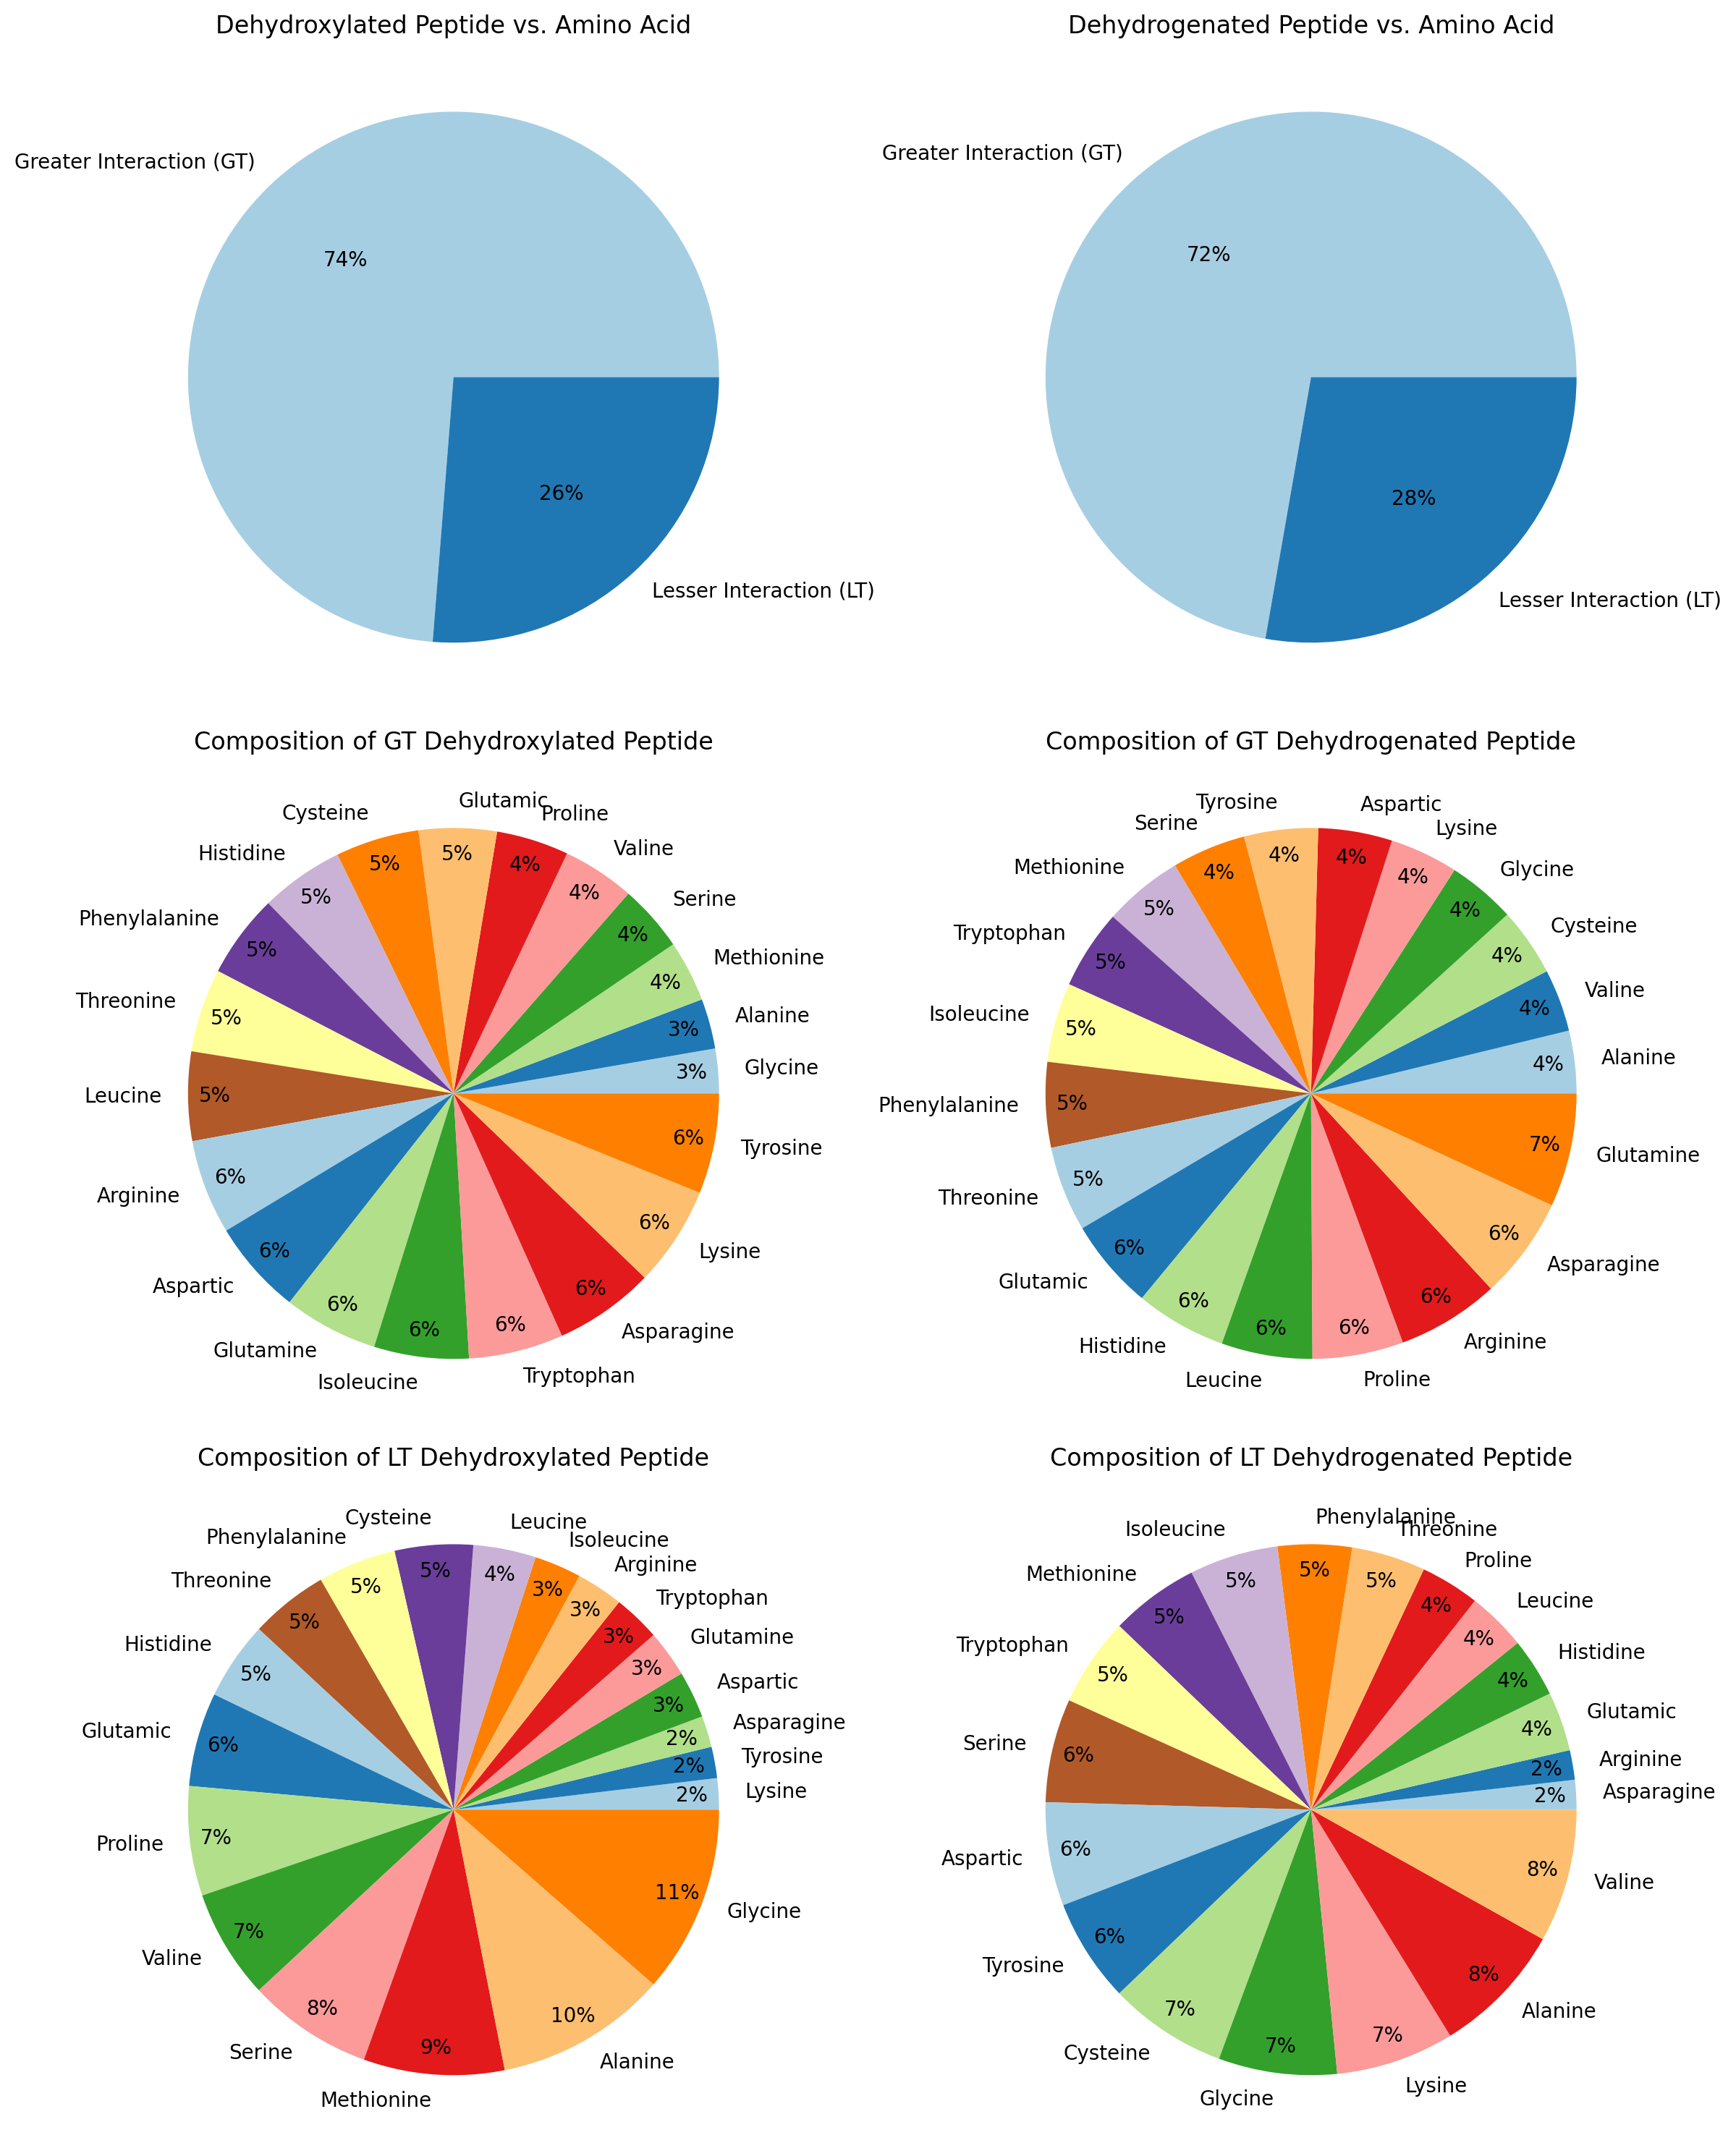

In [52]:





fig,((ax1,ax2),(ax3,ax4),(ax5,ax6))=plt.subplots(3,2,figsize=(12,15))


cmap=sns.color_palette('Paired',2)
ax1.pie(greaterdehydroxy_int.values, labels = ['Greater Interaction (GT)','Lesser Interaction (LT)'], autopct='%.0f%%',colors=cmap)
ax1.set_title('Dehydroxylated Peptide vs. Amino Acid')


ax2.pie(greaterdehydro_int.values, labels = ['Greater Interaction (GT)','Lesser Interaction (LT)'], autopct='%.0f%%',colors=cmap)
ax2.set_title('Dehydrogenated Peptide vs. Amino Acid')
plt.tight_layout()



gtIE_dehydroxy=[]
for i in AA_df.index:
    gtIE_dehydroxy.append(list(all_energies[i][AA_df.loc[i].values[0]>all_energies[i]].index))
gtIE_dehydroxy_arr=np.array(sorted(Counter(sum(gtIE_dehydroxy,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(gtIE_dehydroxy_arr))
ax3.pie(gtIE_dehydroxy_arr[:,1].astype(int), labels = gtIE_dehydroxy_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax3.set_title('Composition of GT Dehydroxylated Peptide')



ltIE_dehydroxy=[]
for i in AA_df.index:
    ltIE_dehydroxy.append(list(all_energies[i][AA_df.loc[i].values[0]<all_energies[i]].index))
ltIE_dehydroxy_arr=np.array(sorted(Counter(sum(ltIE_dehydroxy,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(ltIE_dehydroxy_arr))
ax5.pie(ltIE_dehydroxy_arr[:,1].astype(int), labels = ltIE_dehydroxy_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax5.set_title('Composition of LT Dehydroxylated Peptide')

gtIE_dehydrogen=[]
for i in AA_df.index:
    gtIE_dehydrogen.append(list(all_energies.T[i][AA_df.loc[i].values[0]>all_energies.T[i]].index))
gtIE_dehydrogen_arr=np.array(sorted(Counter(sum(gtIE_dehydrogen,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(gtIE_dehydrogen_arr))
ax4.pie(gtIE_dehydrogen_arr[:,1].astype(int), labels = gtIE_dehydrogen_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax4.set_title('Composition of GT Dehydrogenated Peptide')


ltIE_dehydrogen=[]
for i in AA_df.index:
    ltIE_dehydrogen.append(list(all_energies.T[i][AA_df.loc[i].values[0]<all_energies.T[i]].index))
ltIE_dehydrogen_arr=np.array(sorted(Counter(sum(ltIE_dehydrogen,[])).items(),key=lambda x: x[1]))

mincmap=sns.color_palette('Paired',len(ltIE_dehydrogen_arr))
ax6.pie(ltIE_dehydrogen_arr[:,1].astype(int), labels = ltIE_dehydrogen_arr[:,0], autopct='%.0f%%',colors=mincmap, pctdistance=0.9)
ax6.set_title('Composition of LT Dehydrogenated Peptide')

plt.tight_layout()

plt.savefig('interaction_compare.png',dpi=300,bbox_inches='tight')
plt.show()





In [53]:
for i in AA_df.index:
    print(list(all_energies[i][AA_df.loc[i].values[0]>all_energies[i]].index))

['Alanine', 'Arginine', 'Asparagine', 'Aspartic', 'Cysteine', 'Glutamic', 'Glutamine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
['Arginine', 'Asparagine', 'Histidine', 'Isoleucine', 'Lysine', 'Tyrosine']
['Alanine', 'Arginine', 'Asparagine', 'Cysteine', 'Glutamic', 'Glutamine', 'Isoleucine', 'Leucine', 'Lysine', 'Threonine', 'Tyrosine', 'Valine']
['Arginine', 'Asparagine', 'Aspartic', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Phenylalanine', 'Threonine', 'Tryptophan', 'Tyrosine']
['Alanine', 'Arginine', 'Asparagine', 'Aspartic', 'Cysteine', 'Glutamic', 'Glutamine', 'Histidine', 'Isoleucine', 'Leucine', 'Lysine', 'Methionine', 'Phenylalanine', 'Proline', 'Serine', 'Threonine', 'Tryptophan', 'Tyrosine', 'Valine']
['Asparagine', 'Aspartic', 'Glutamine', 'Glycine', 'Isoleucine', 'Threonine', 'Tryptophan', 'Tyrosine']
['Alanine', 'Arginine', 'Asparagine', 'Aspartic', 'Cysteine', 'Glutamic

In [54]:
pd.concat([pd.DataFrame.from_dict(dict(Counter(sum(ltIE_dehydroxy,[]))),orient='index'),pd.DataFrame.from_dict(dict(Counter(sum(ltIE_dehydrogen,[]))),orient='index')],axis=1).sum(axis=1).sort_values()

Glutamine         3.0
Asparagine        4.0
Arginine          5.0
Leucine           8.0
Isoleucine        9.0
Histidine         9.0
Tryptophan        9.0
Tyrosine          9.0
Lysine           10.0
Threonine        10.0
Phenylalanine    10.0
Glutamic         10.0
Aspartic         10.0
Proline          11.0
Cysteine         13.0
Methionine       15.0
Serine           15.0
Valine           16.0
Alanine          20.0
Glycine          20.0
dtype: float64

In [55]:
pd.concat([pd.DataFrame.from_dict(dict(Counter(sum(gtIE_dehydroxy,[]))),orient='index'),pd.DataFrame.from_dict(dict(Counter(sum(gtIE_dehydrogen,[]))),orient='index')],axis=1).sum(axis=1).sort_values()




Alanine          20
Glycine          20
Valine           24
Methionine       25
Serine           25
Cysteine         27
Proline          29
Lysine           30
Aspartic         30
Glutamic         30
Phenylalanine    30
Threonine        30
Histidine        31
Isoleucine       31
Tyrosine         31
Tryptophan       31
Leucine          32
Arginine         35
Asparagine       36
Glutamine        37
dtype: int64

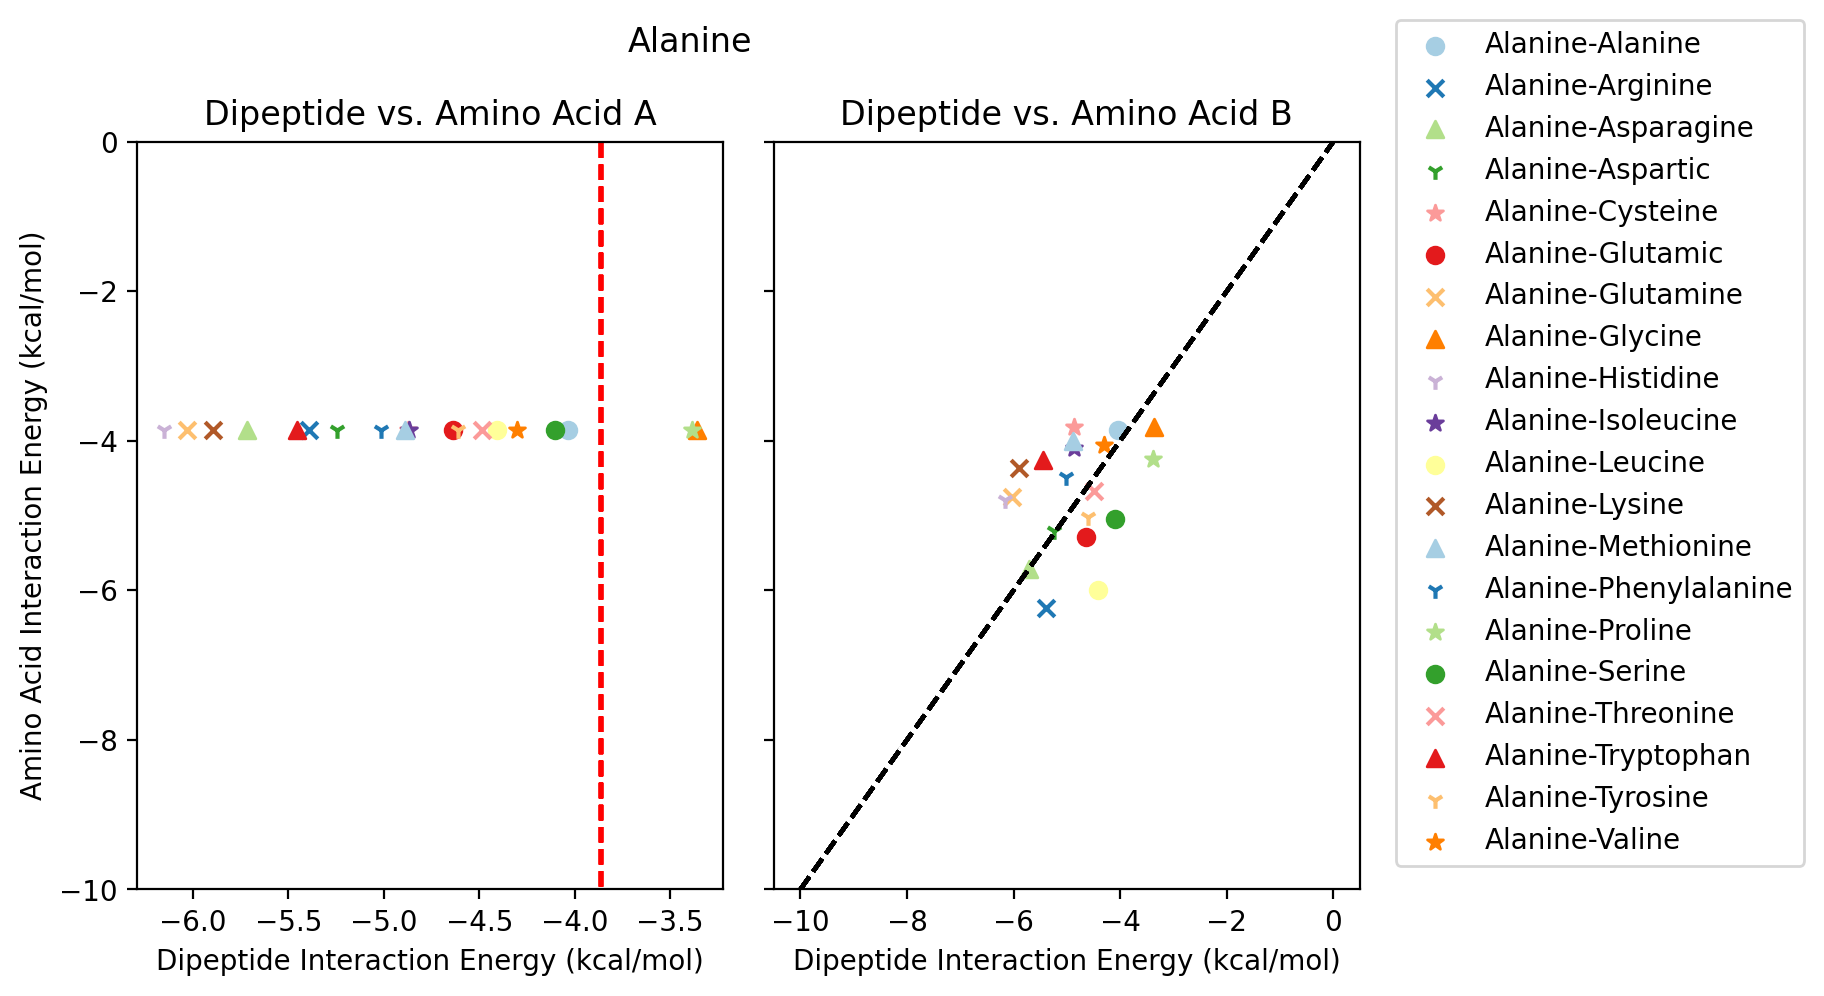

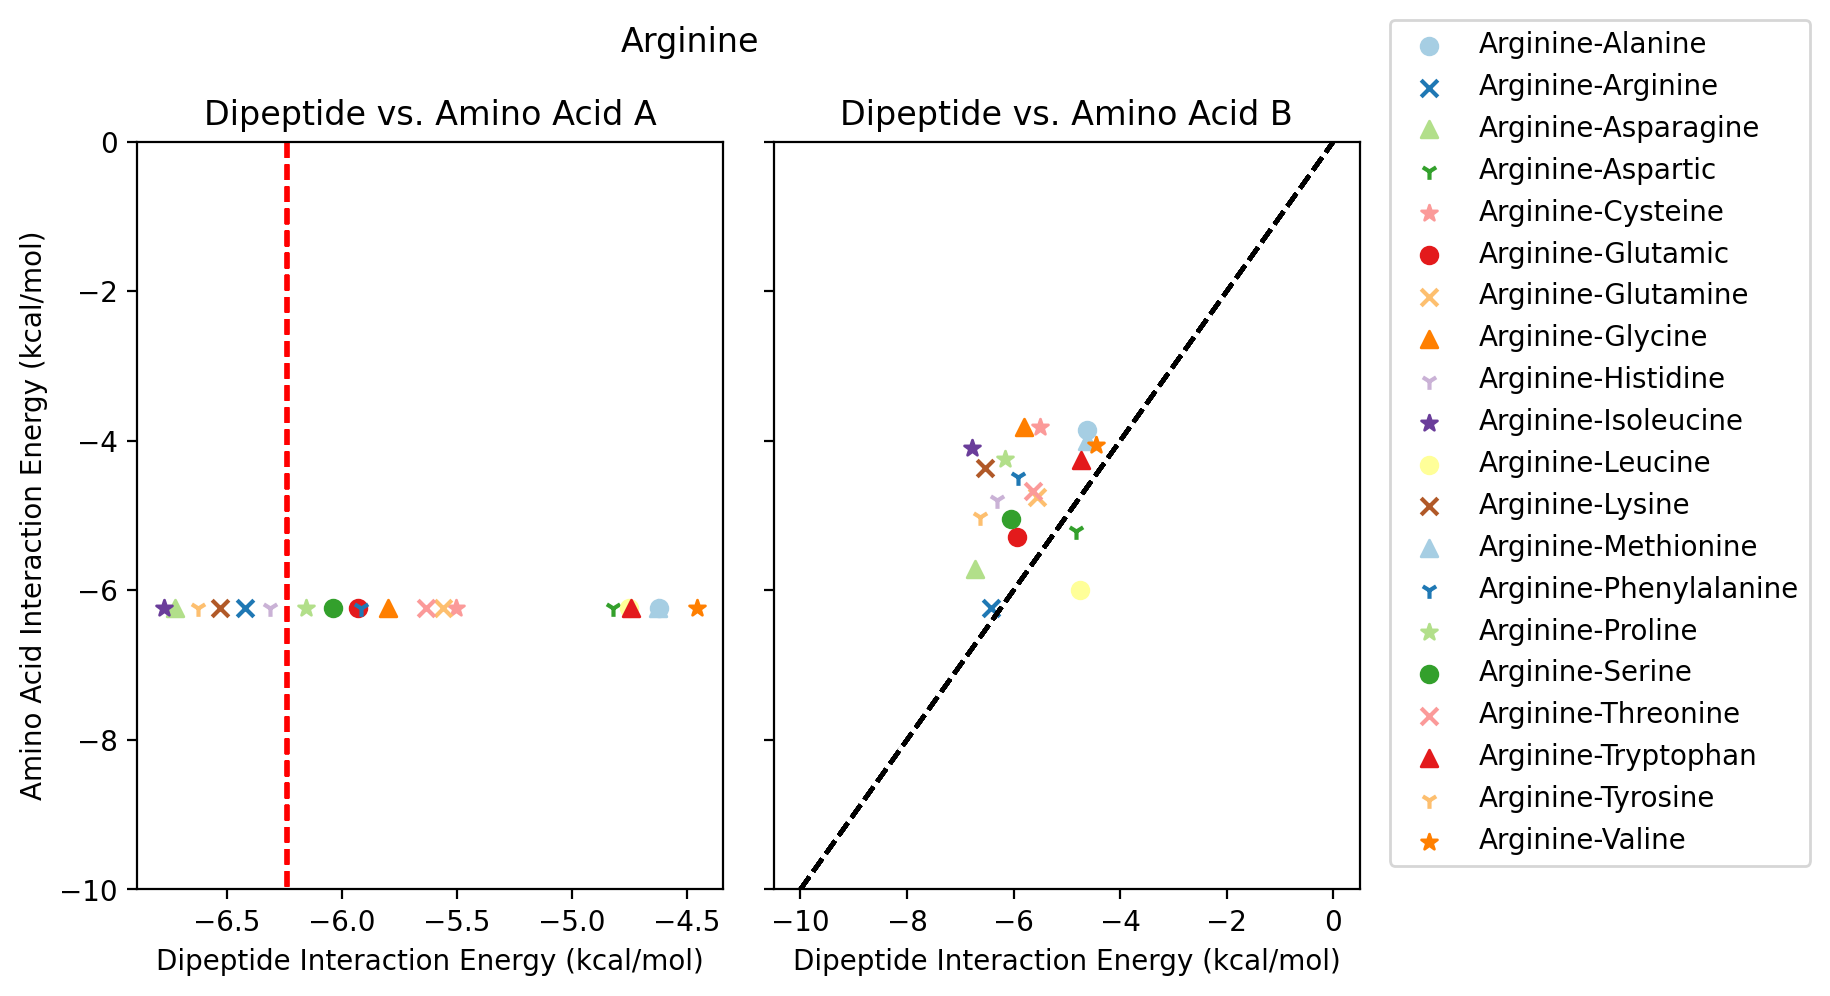

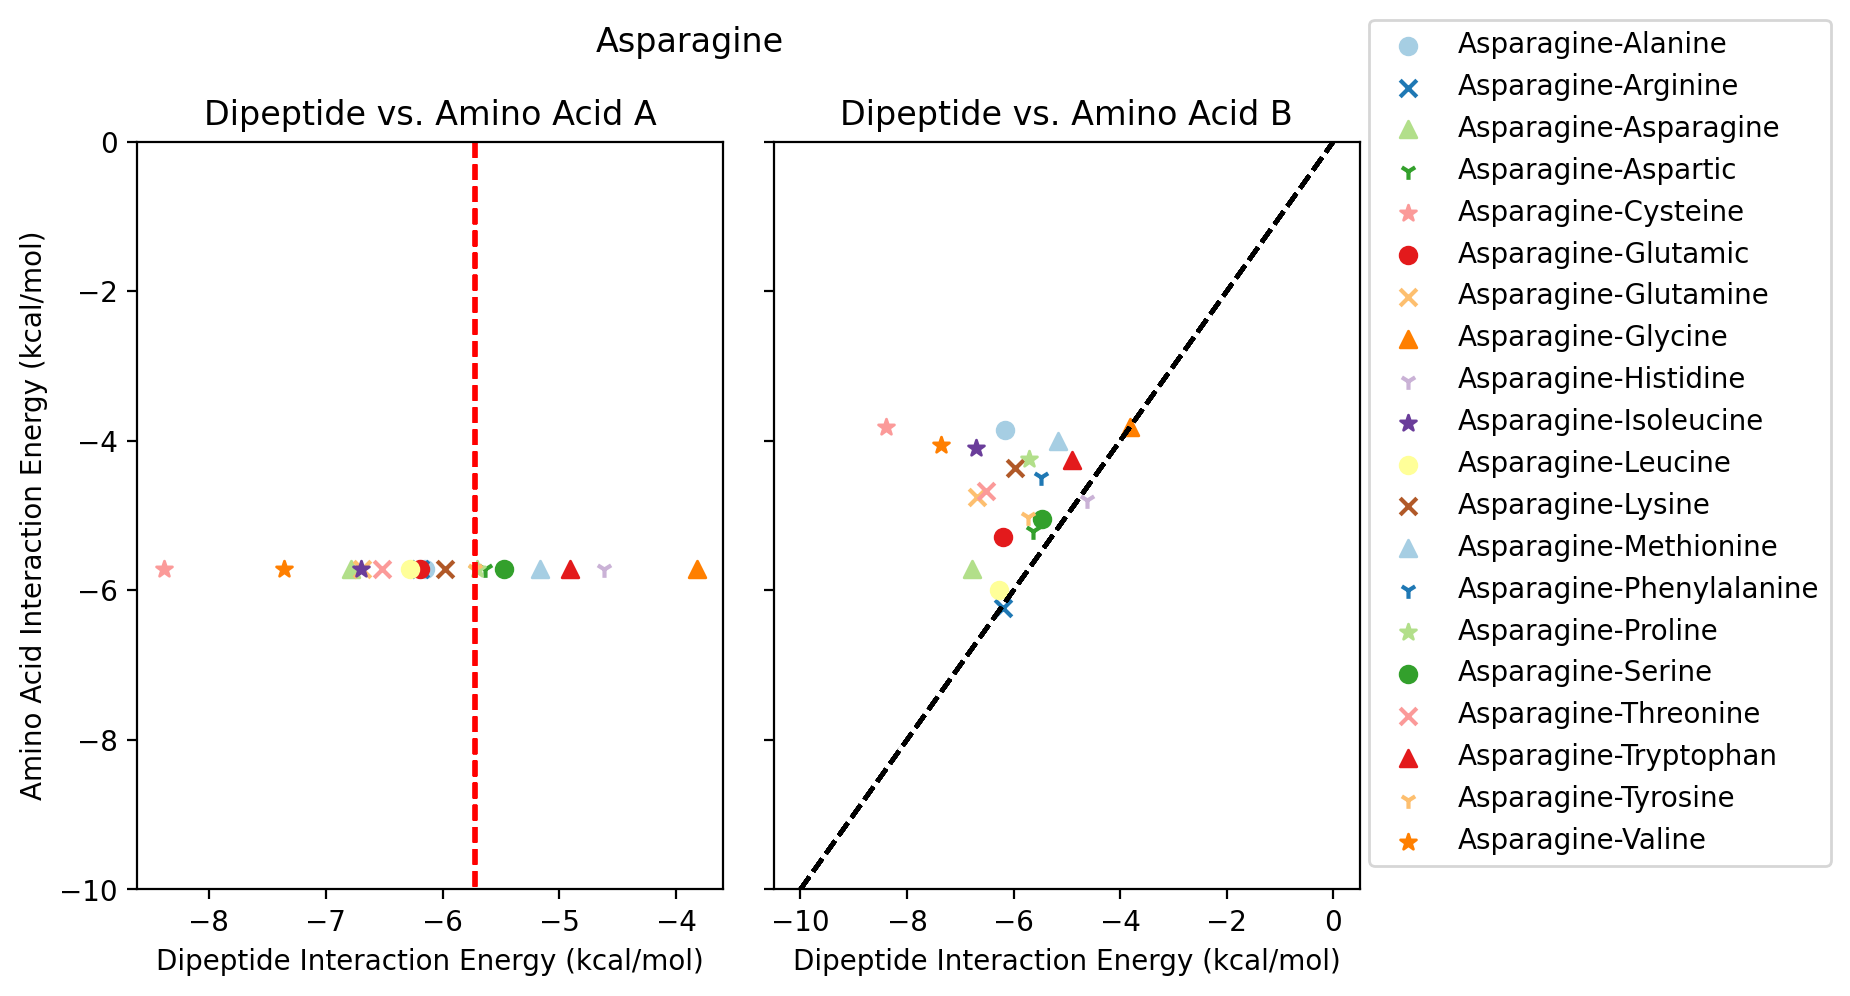

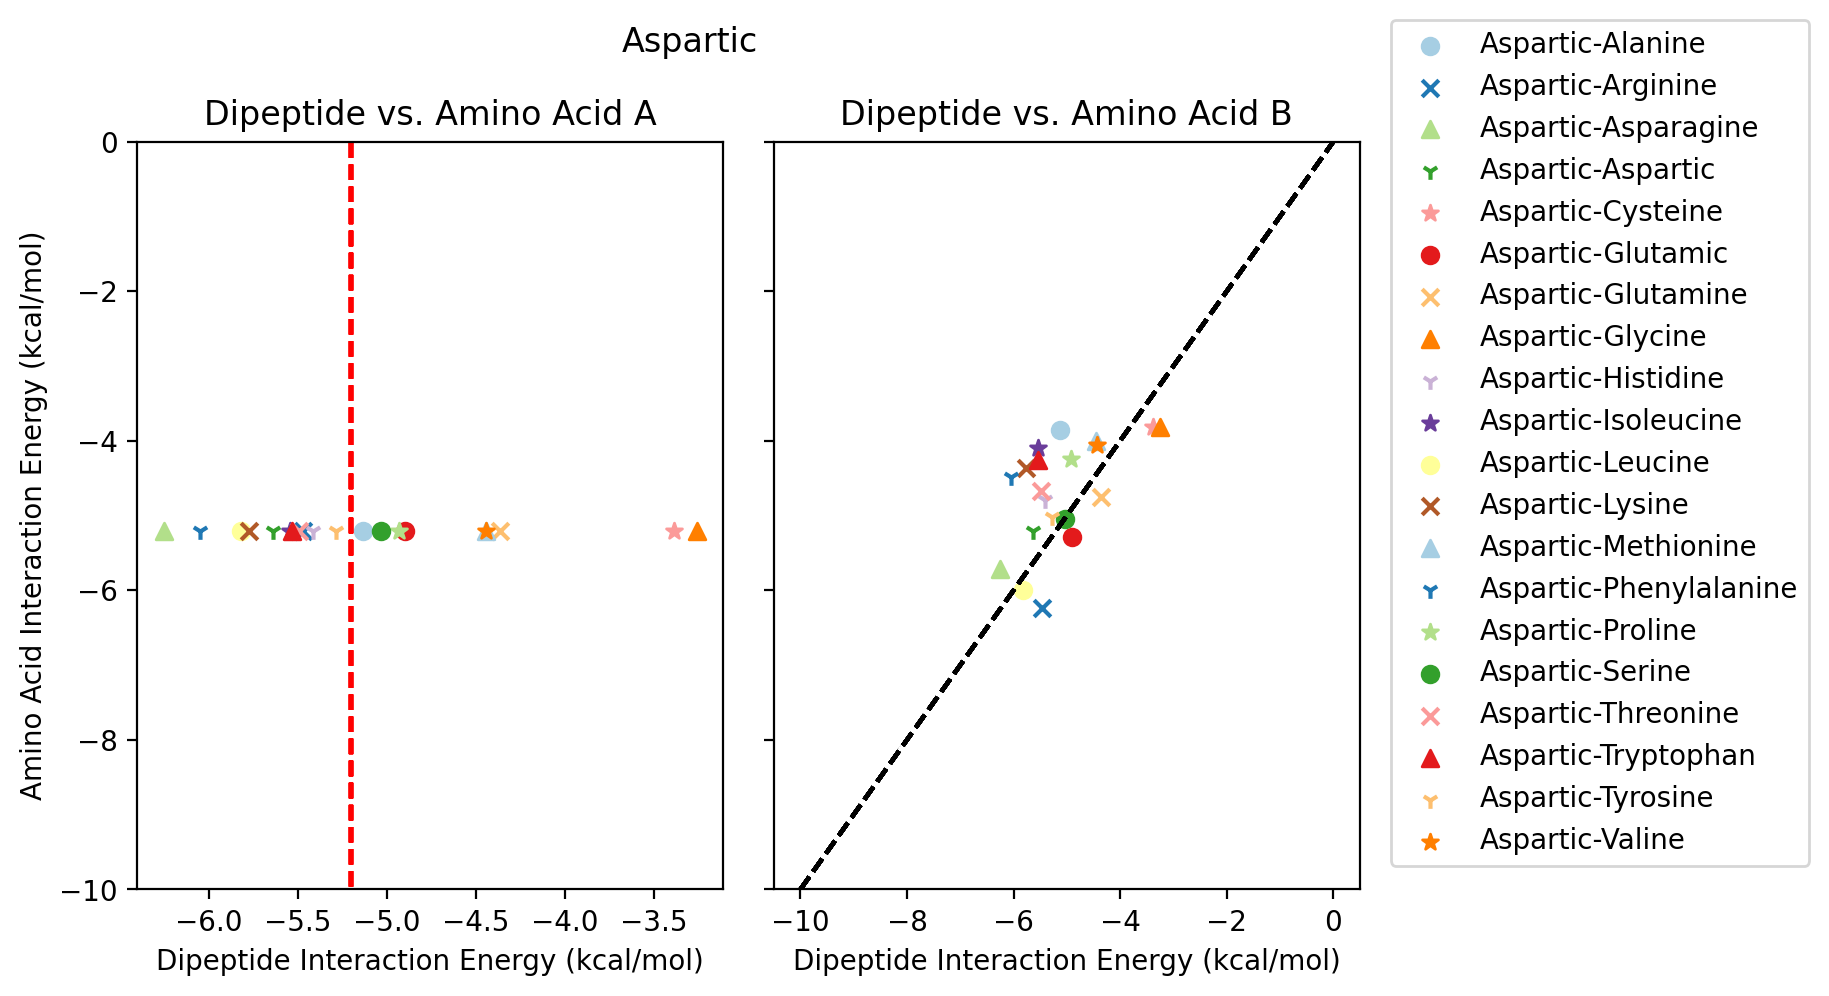

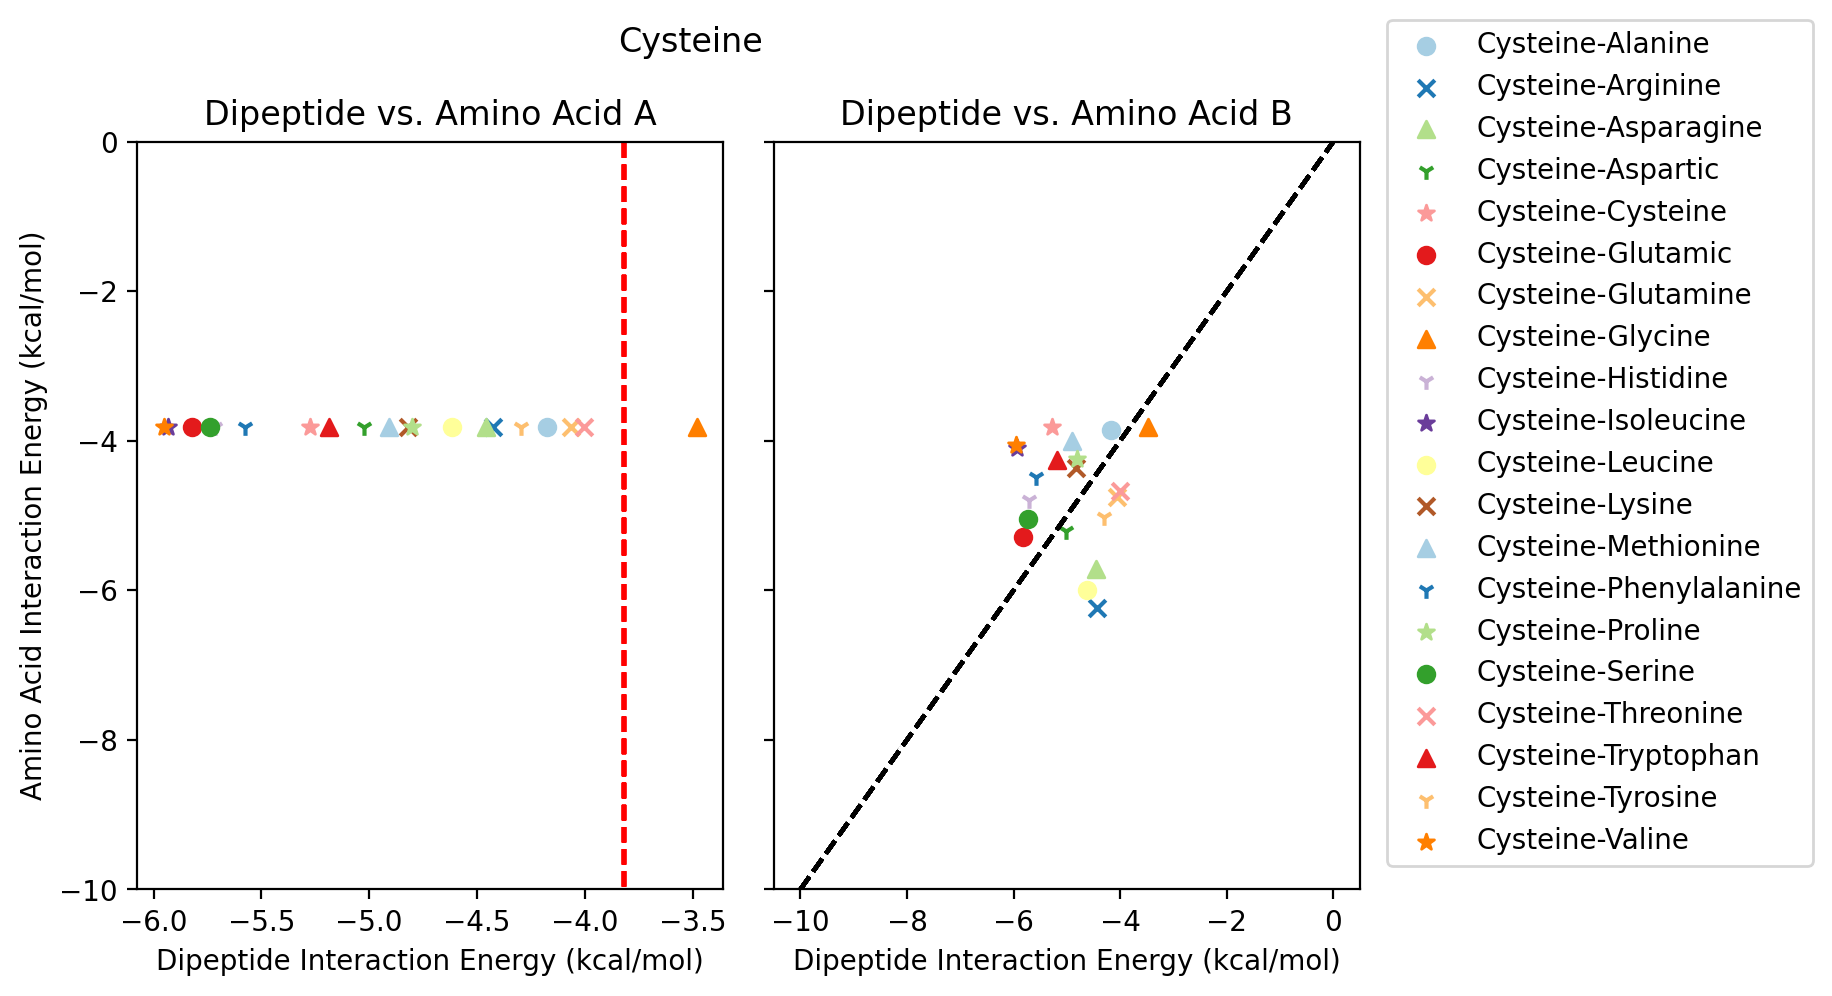

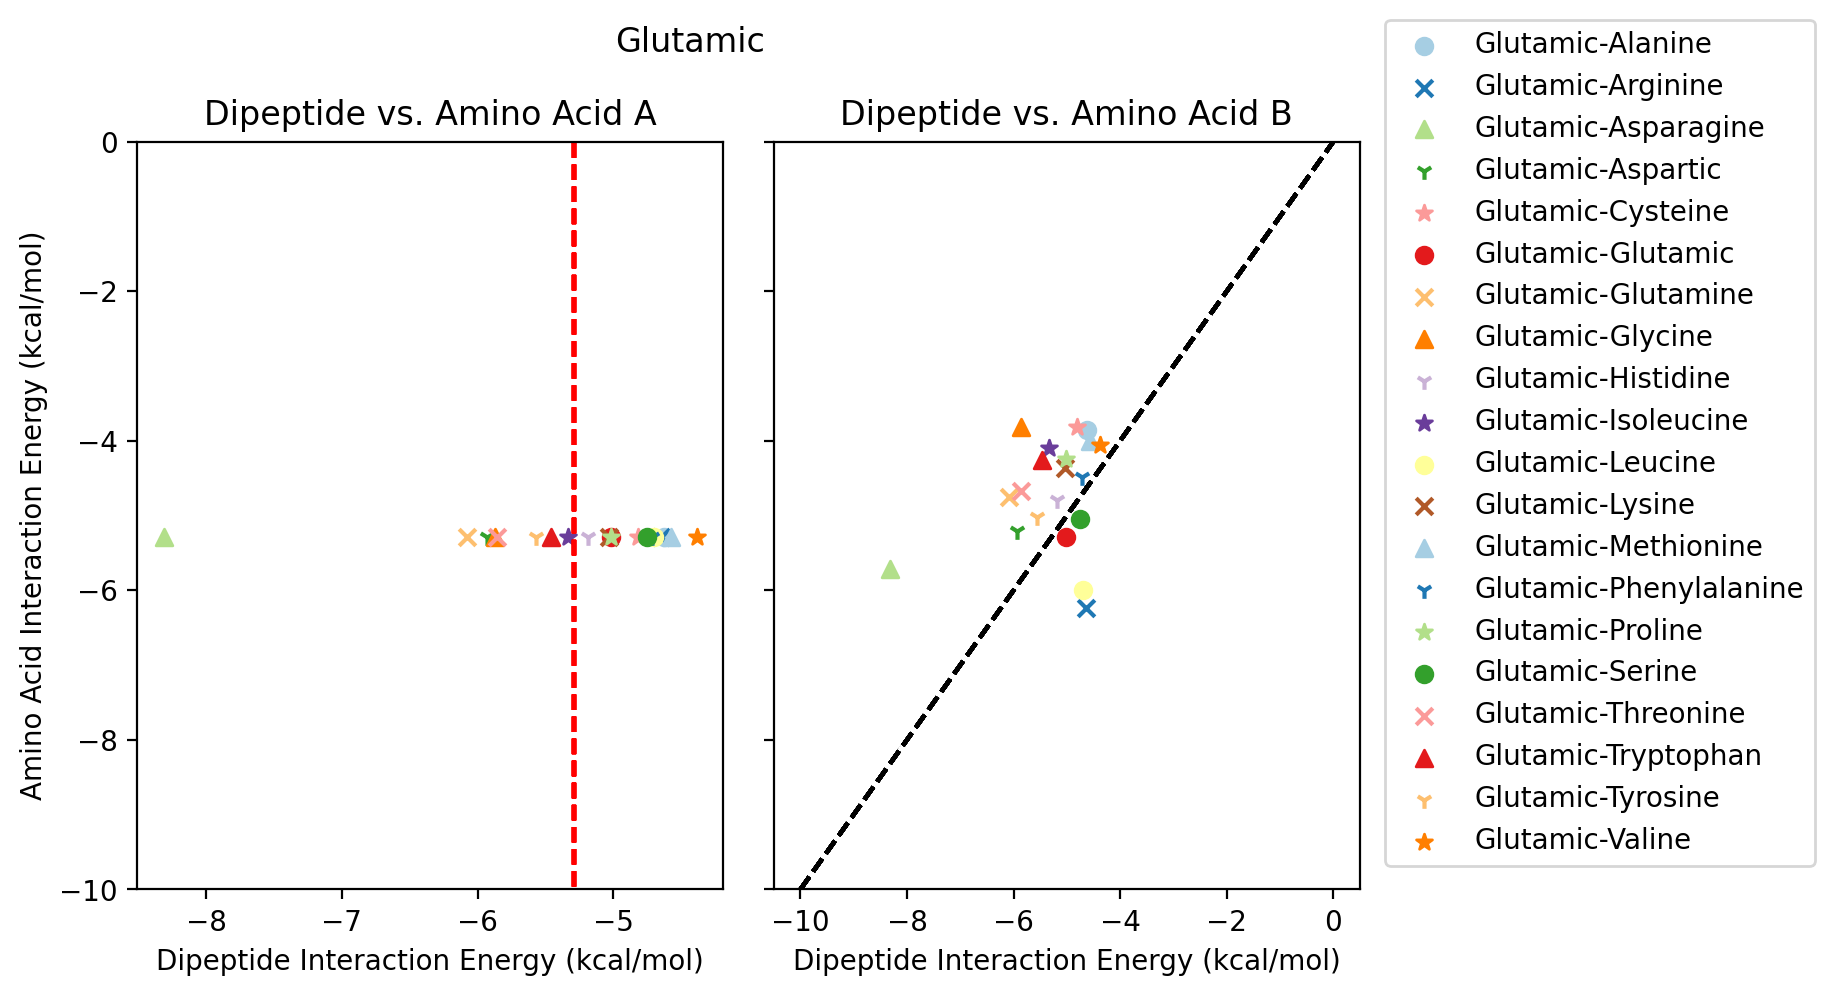

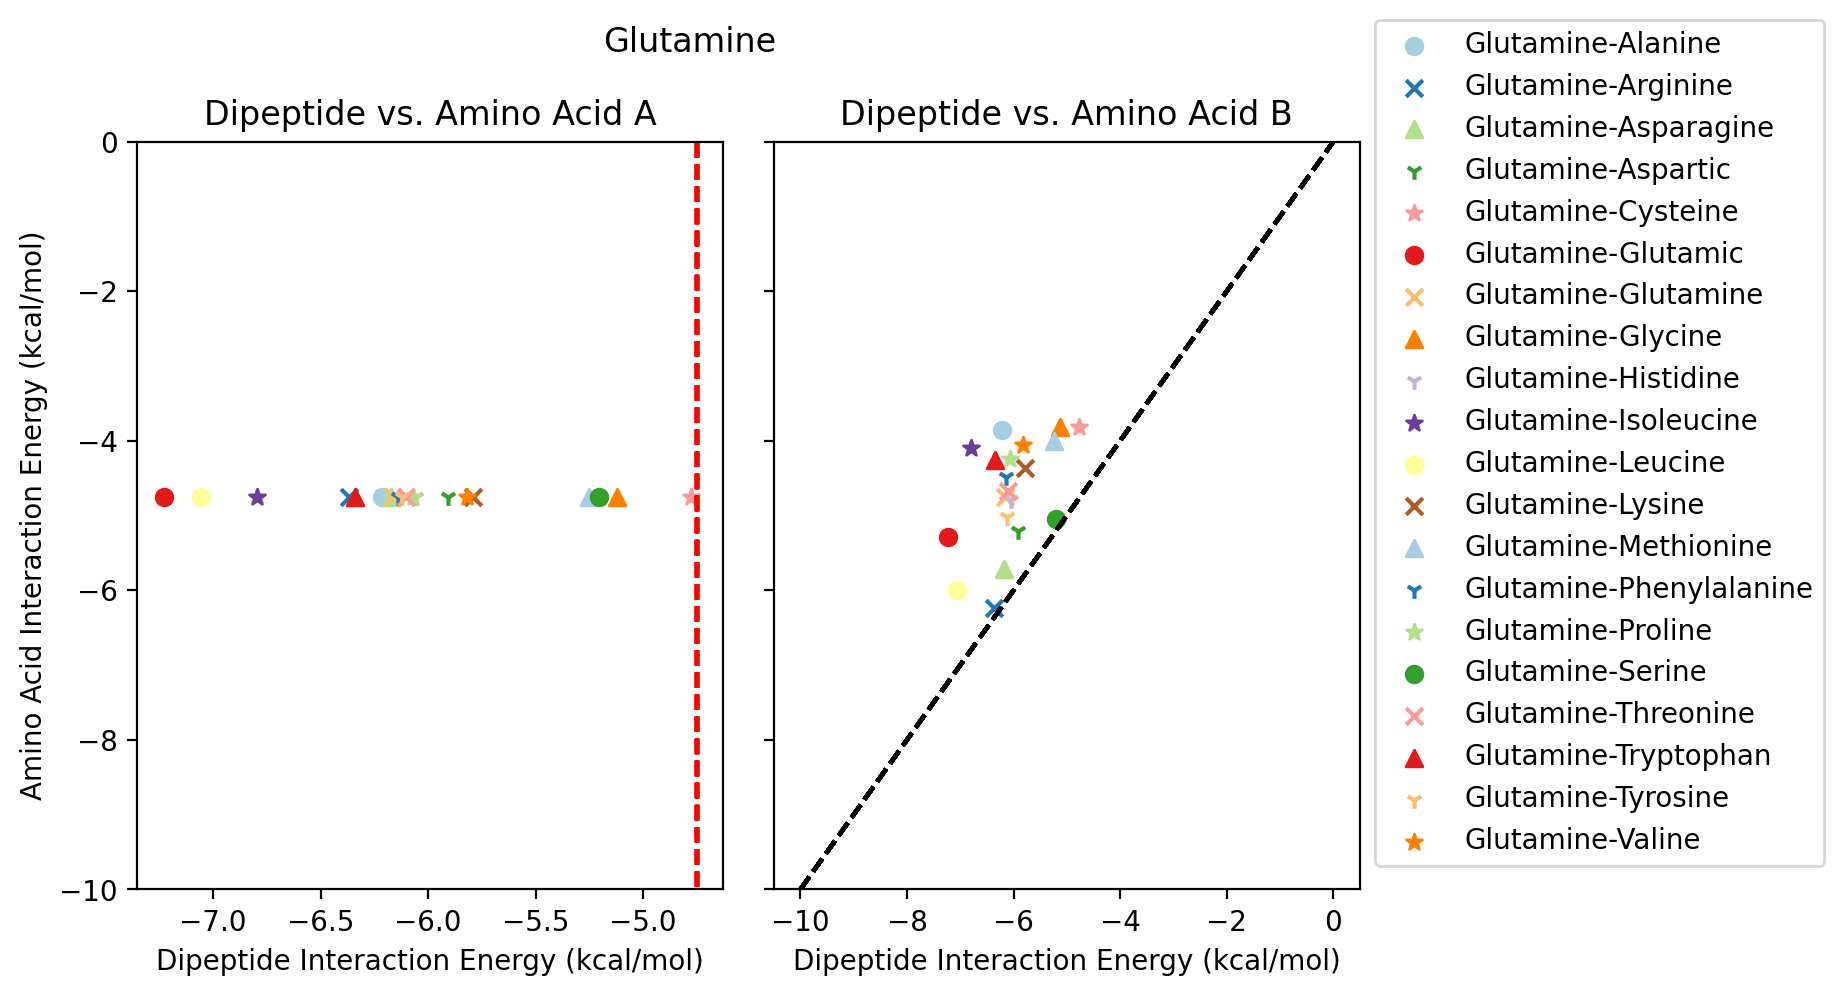

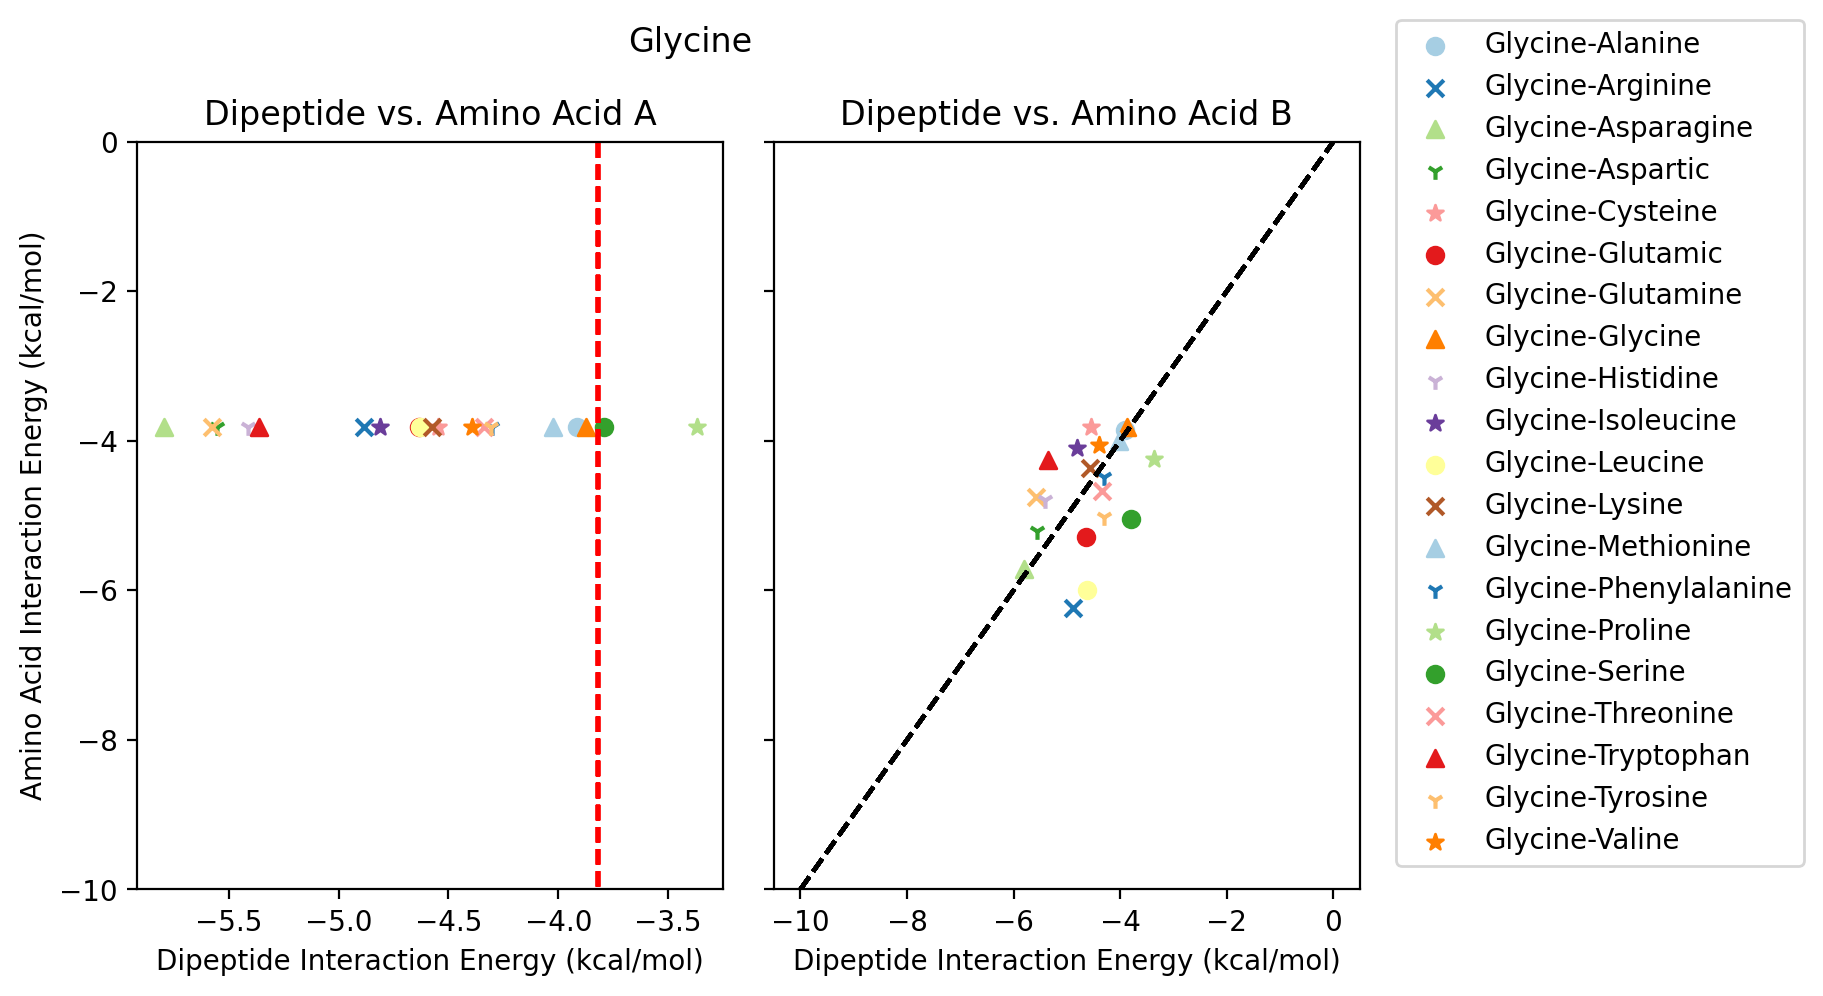

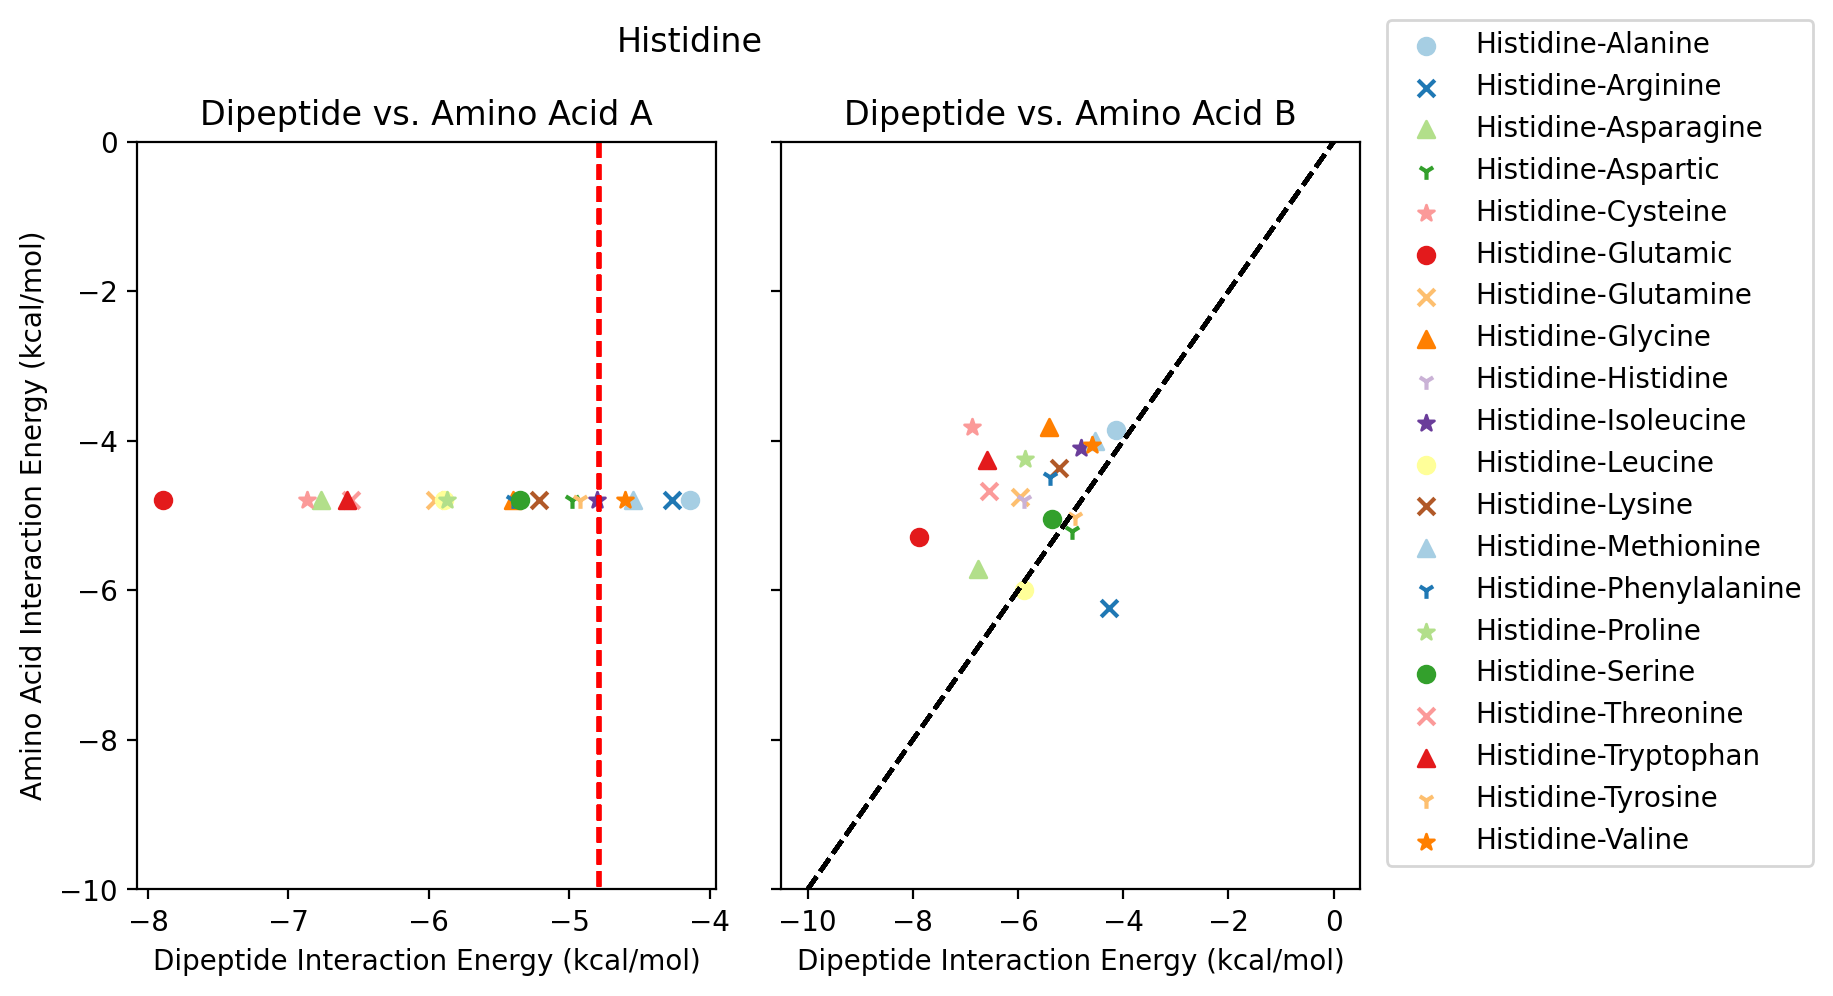

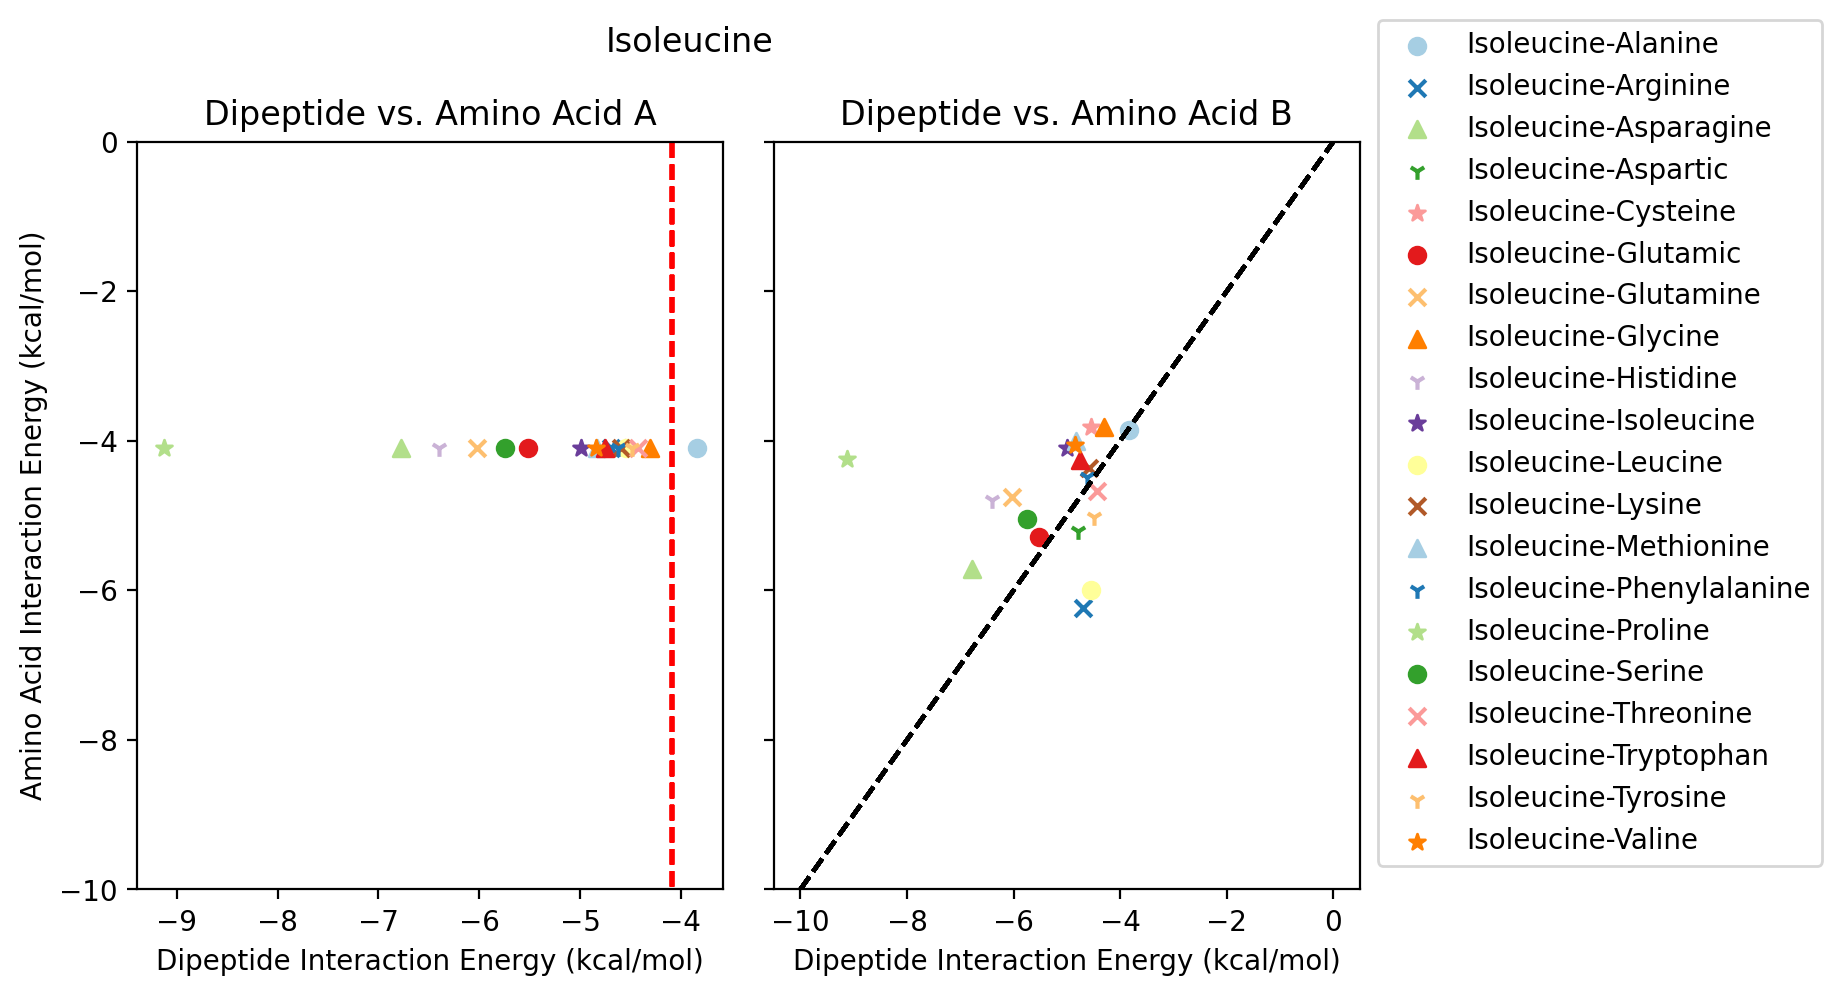

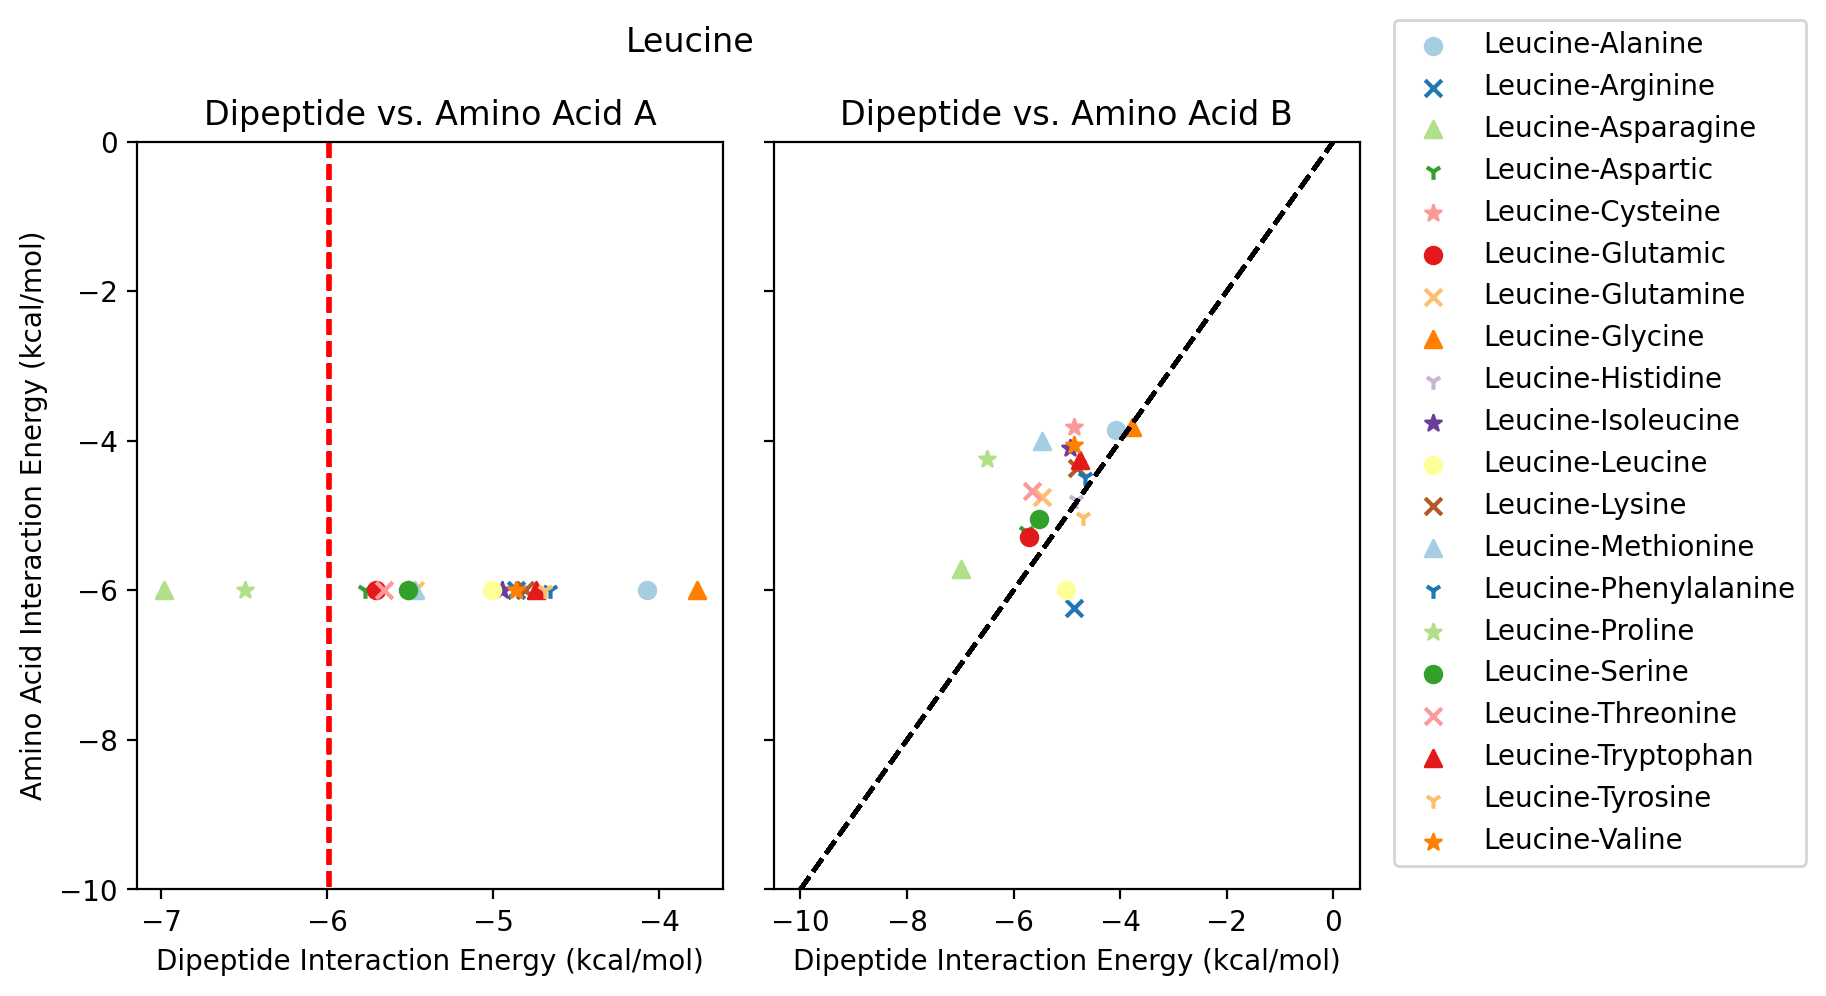

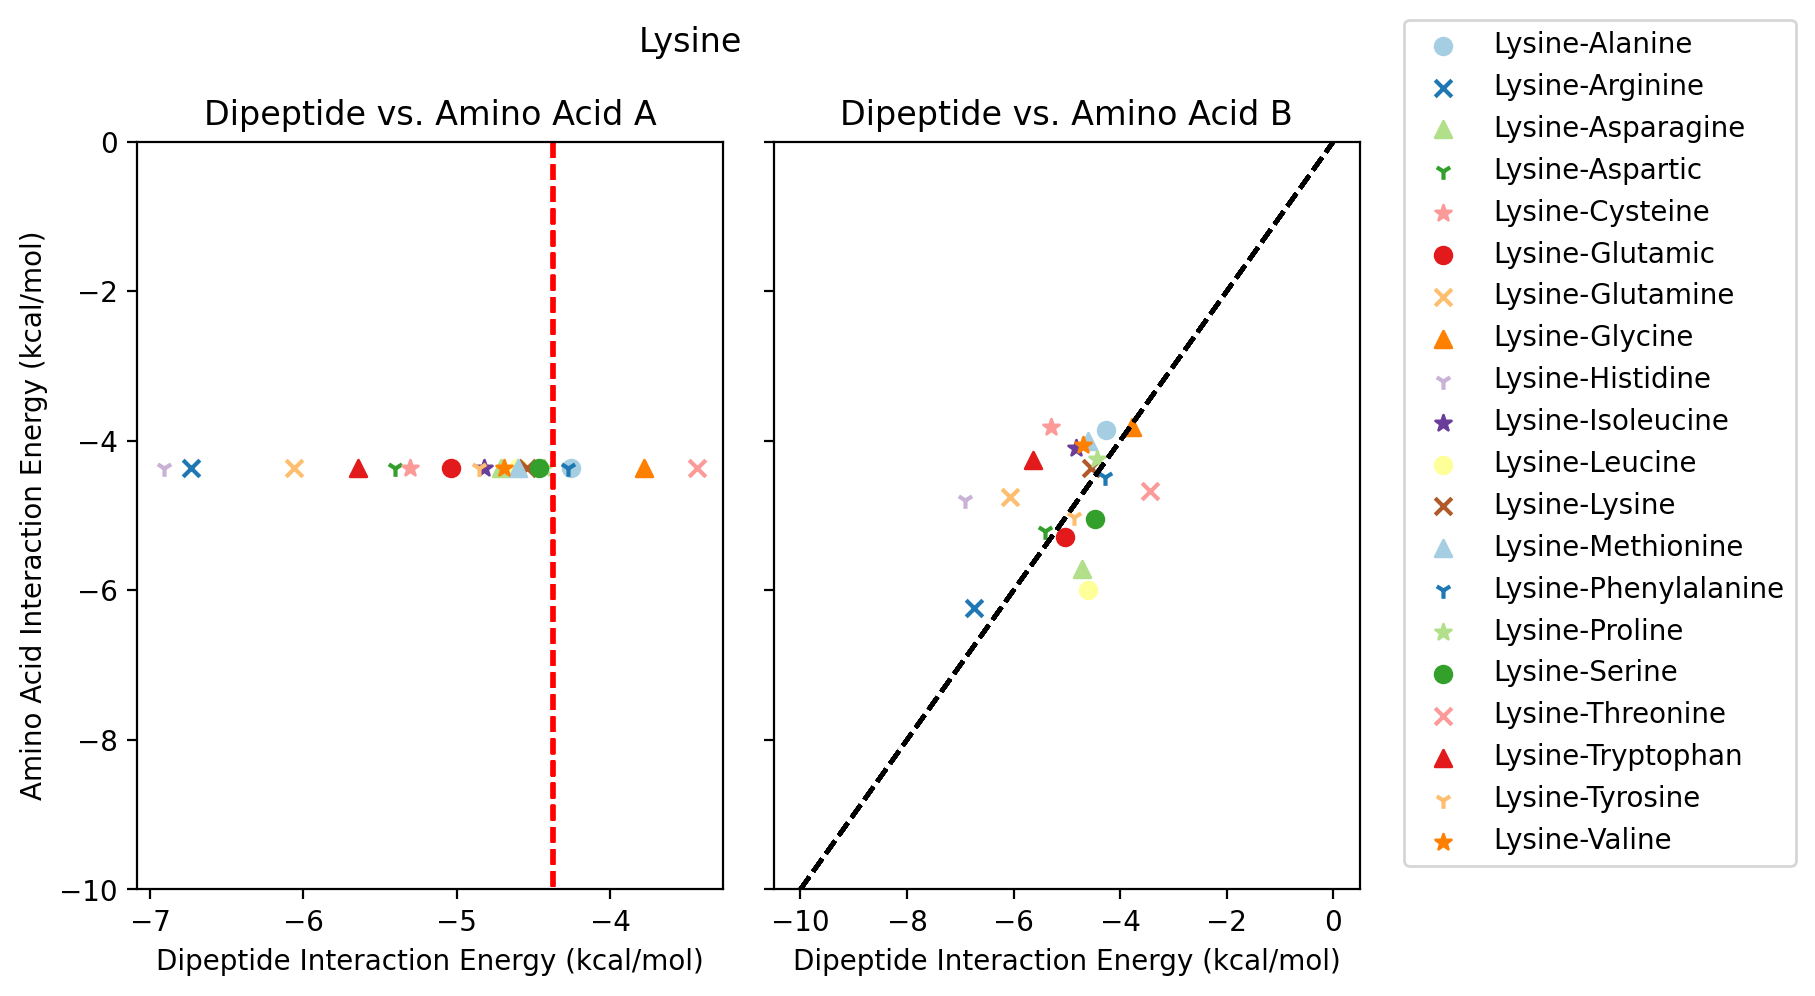

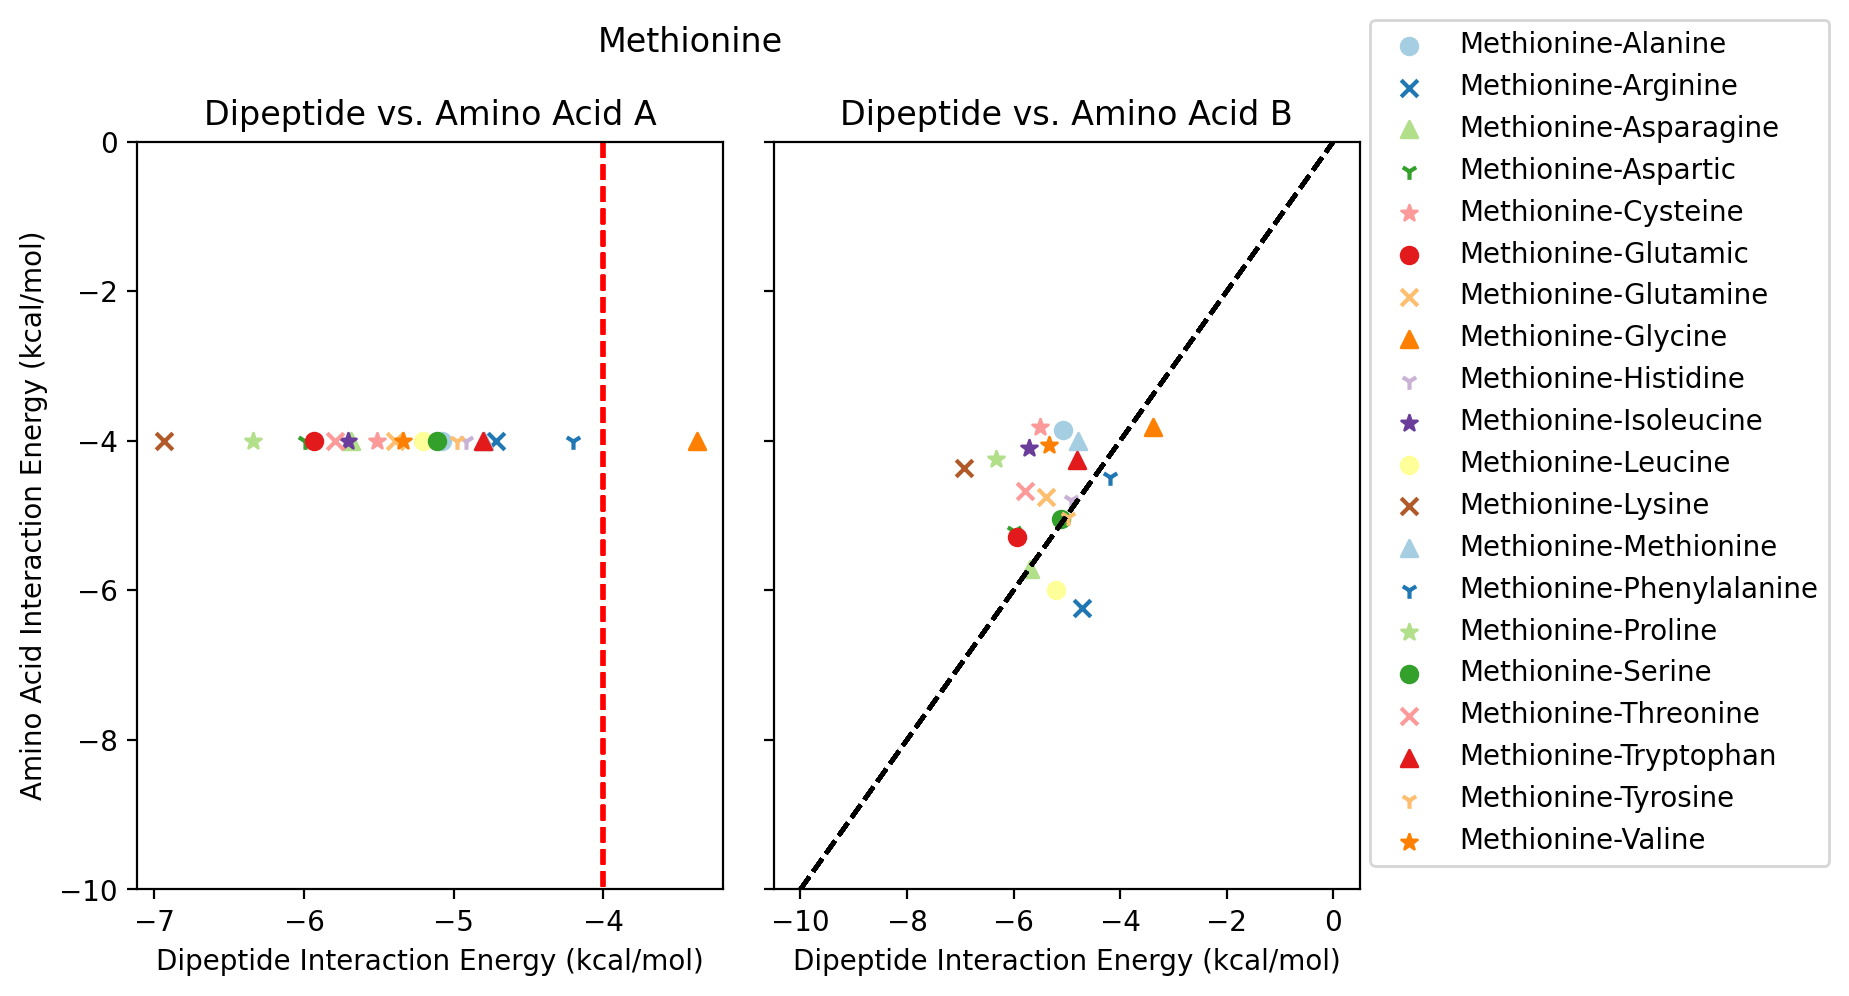

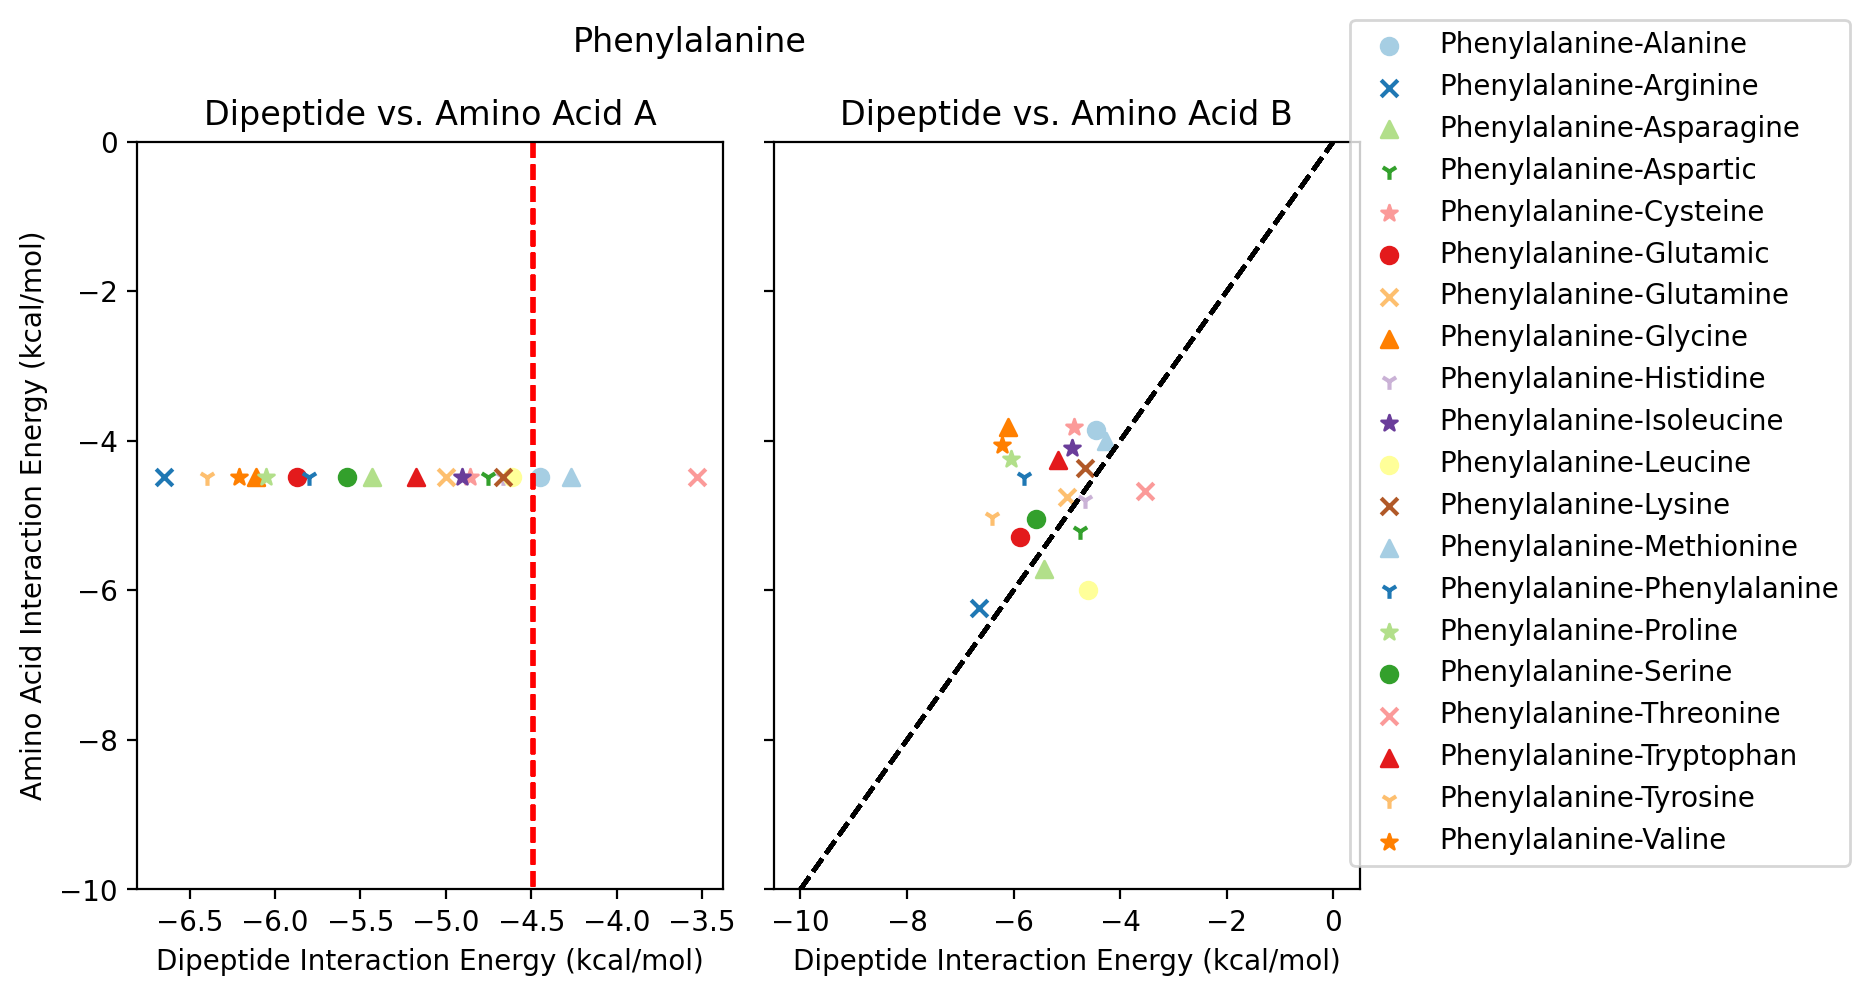

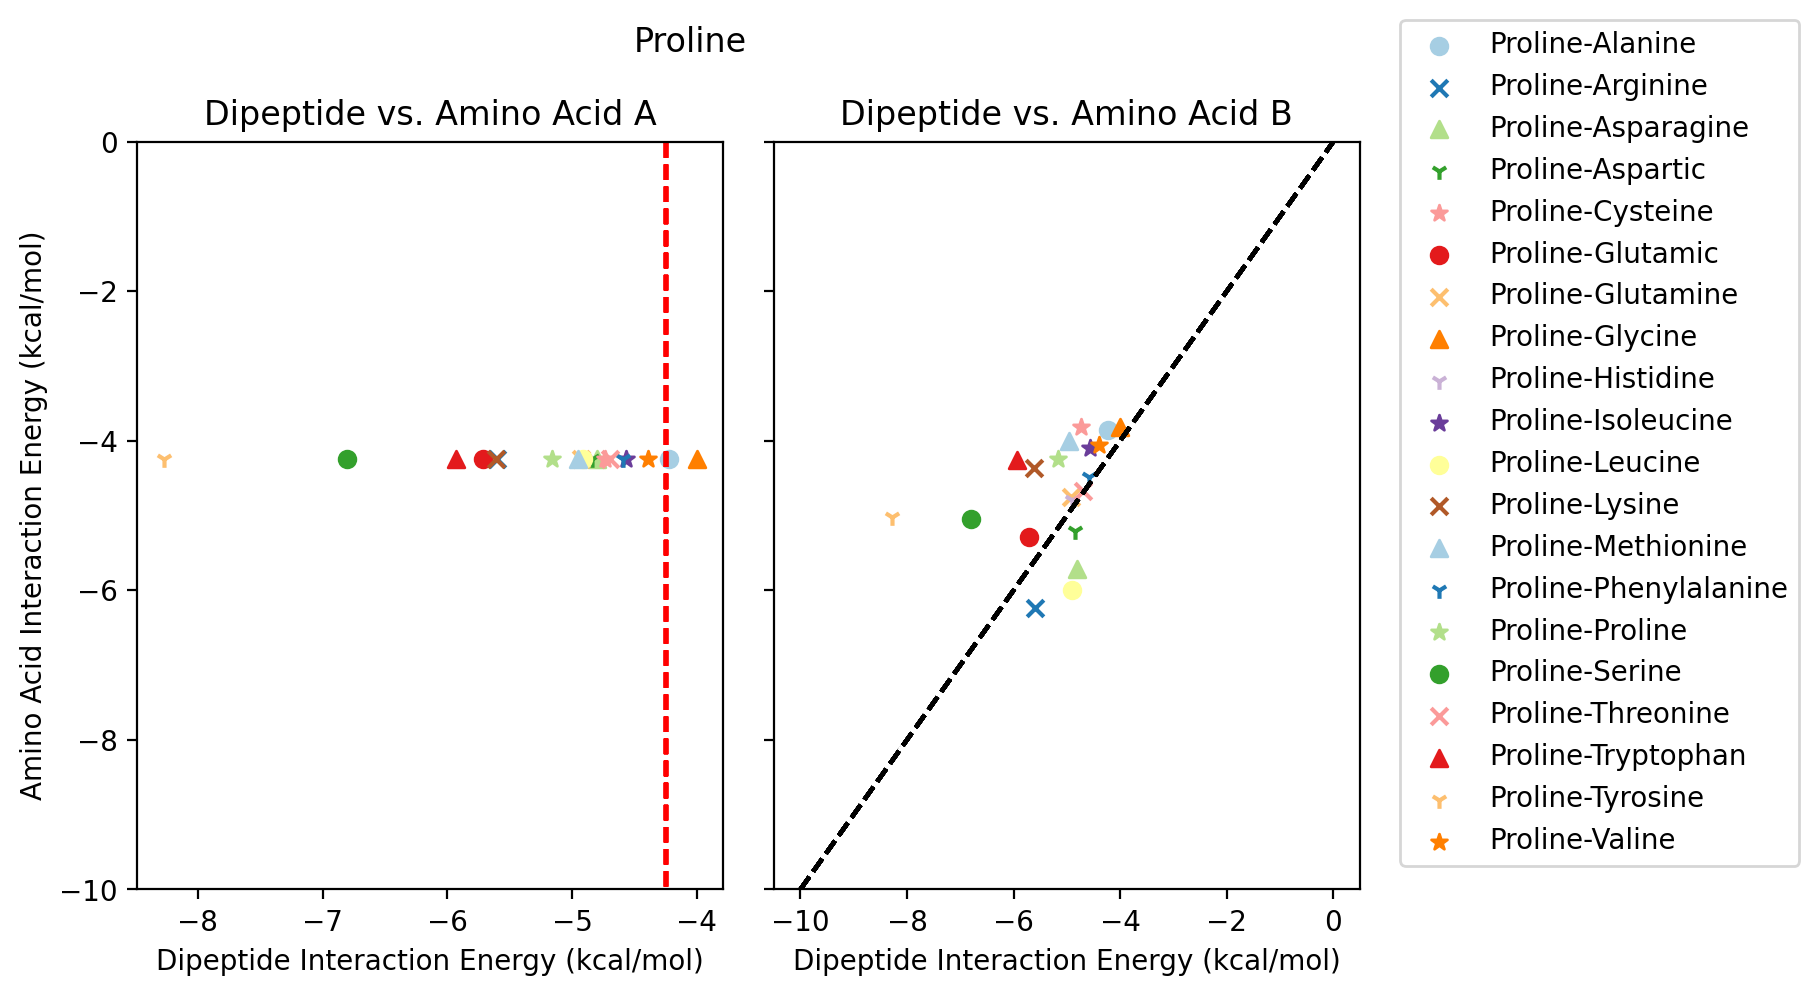

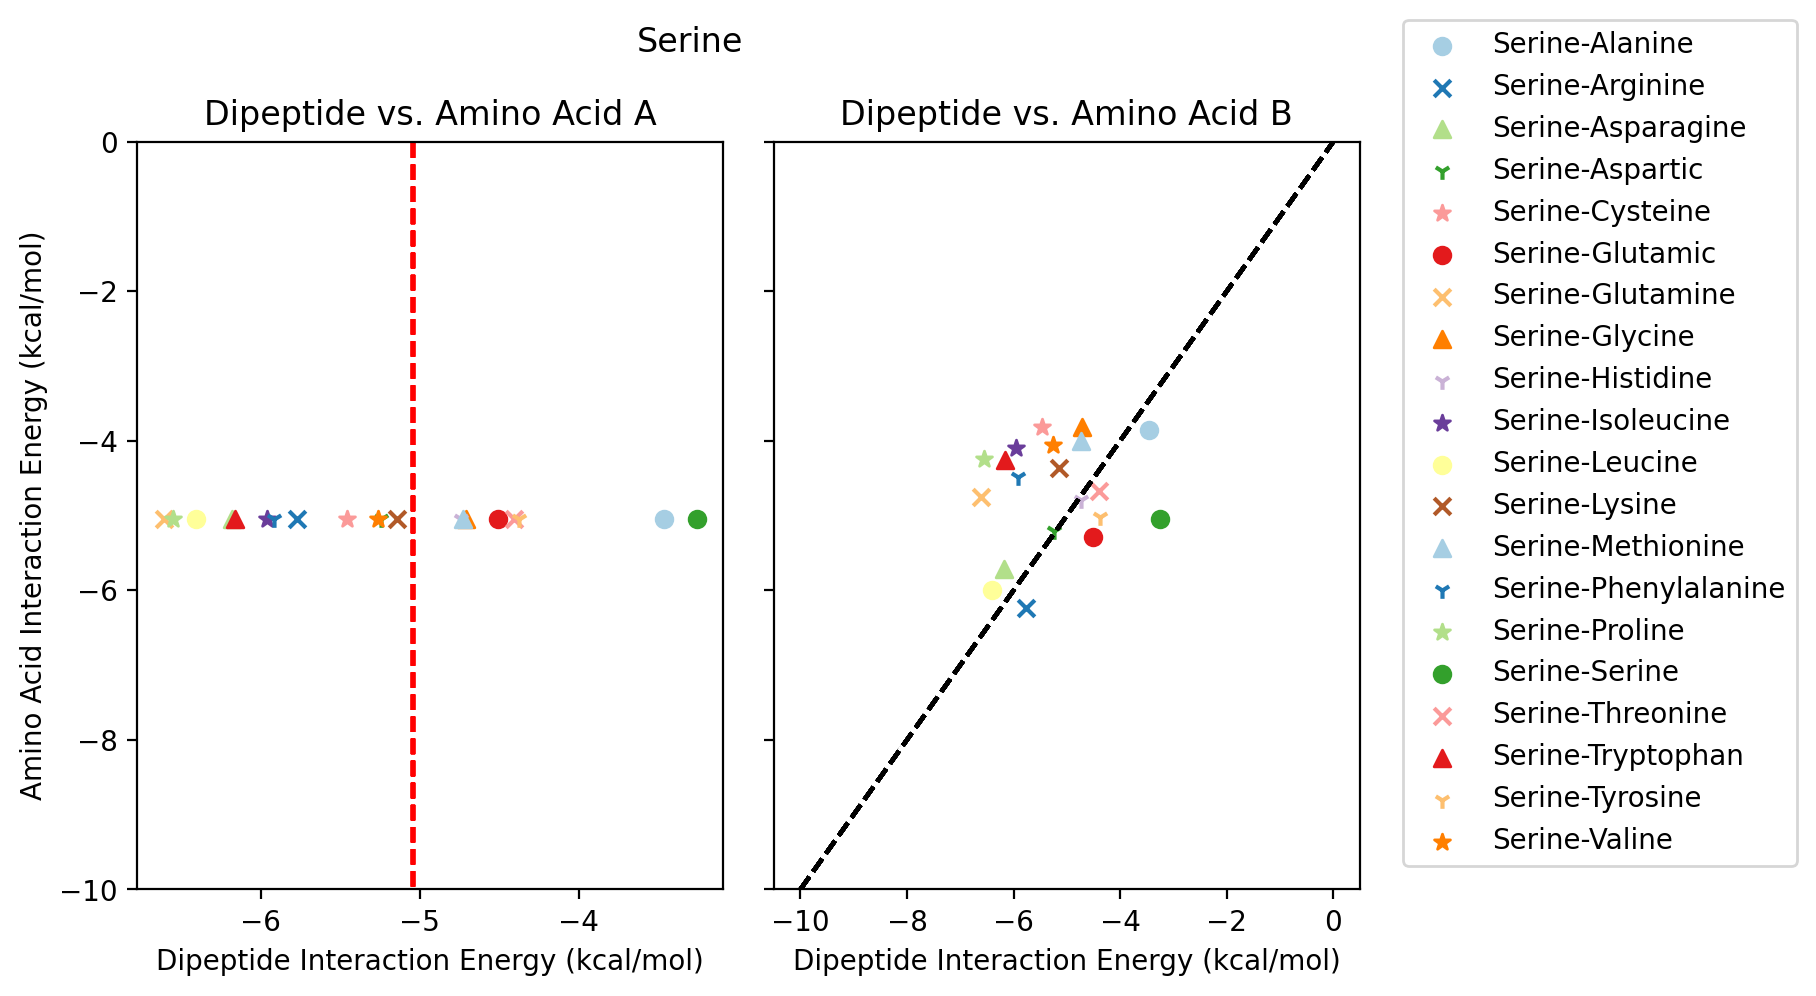

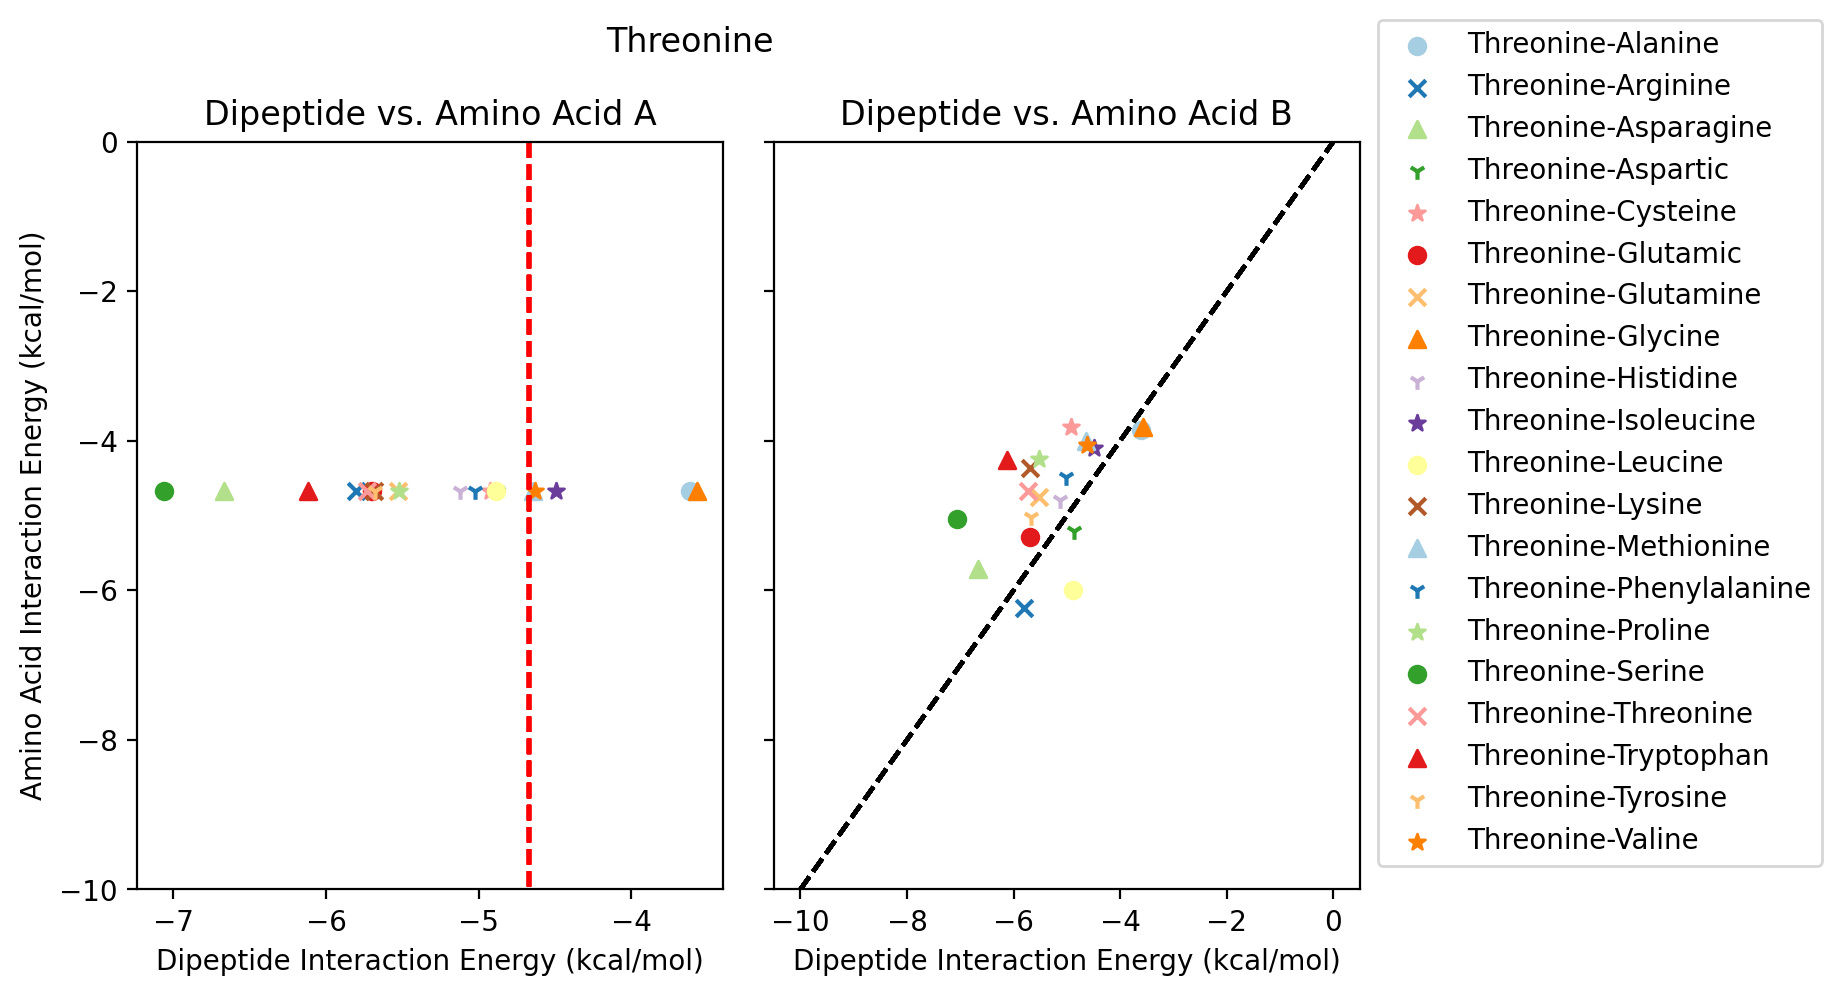

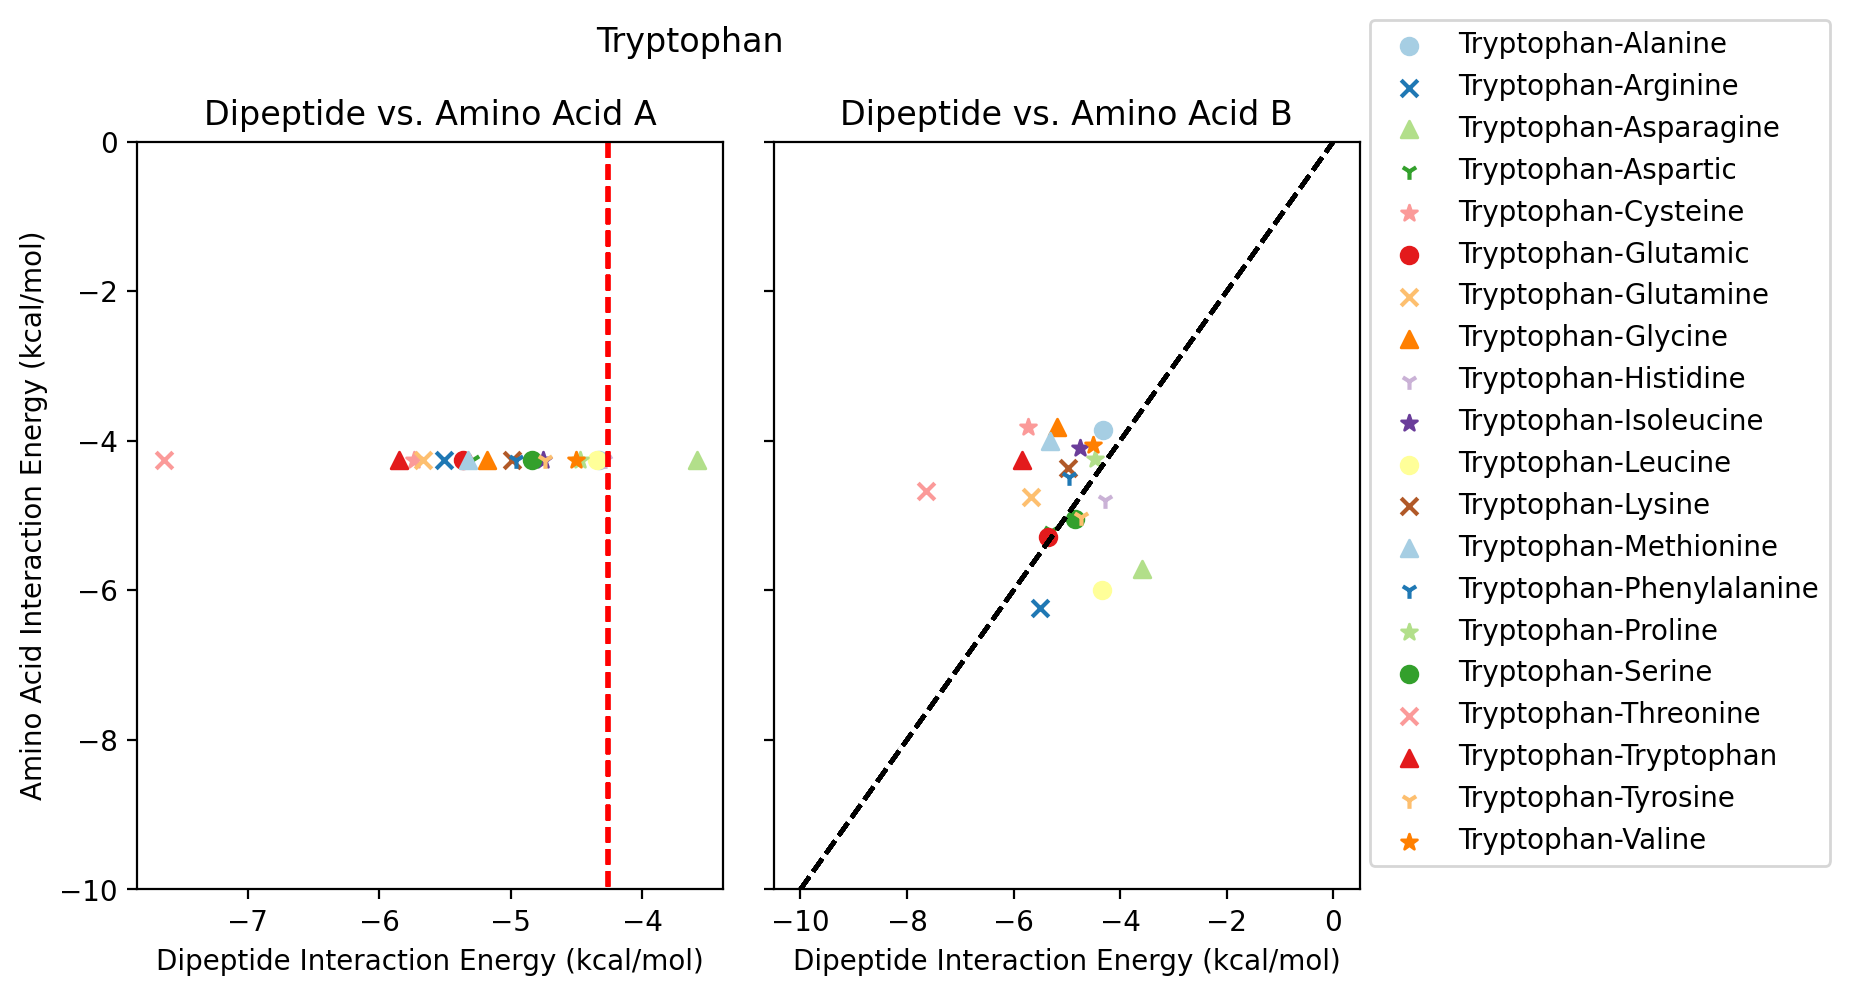

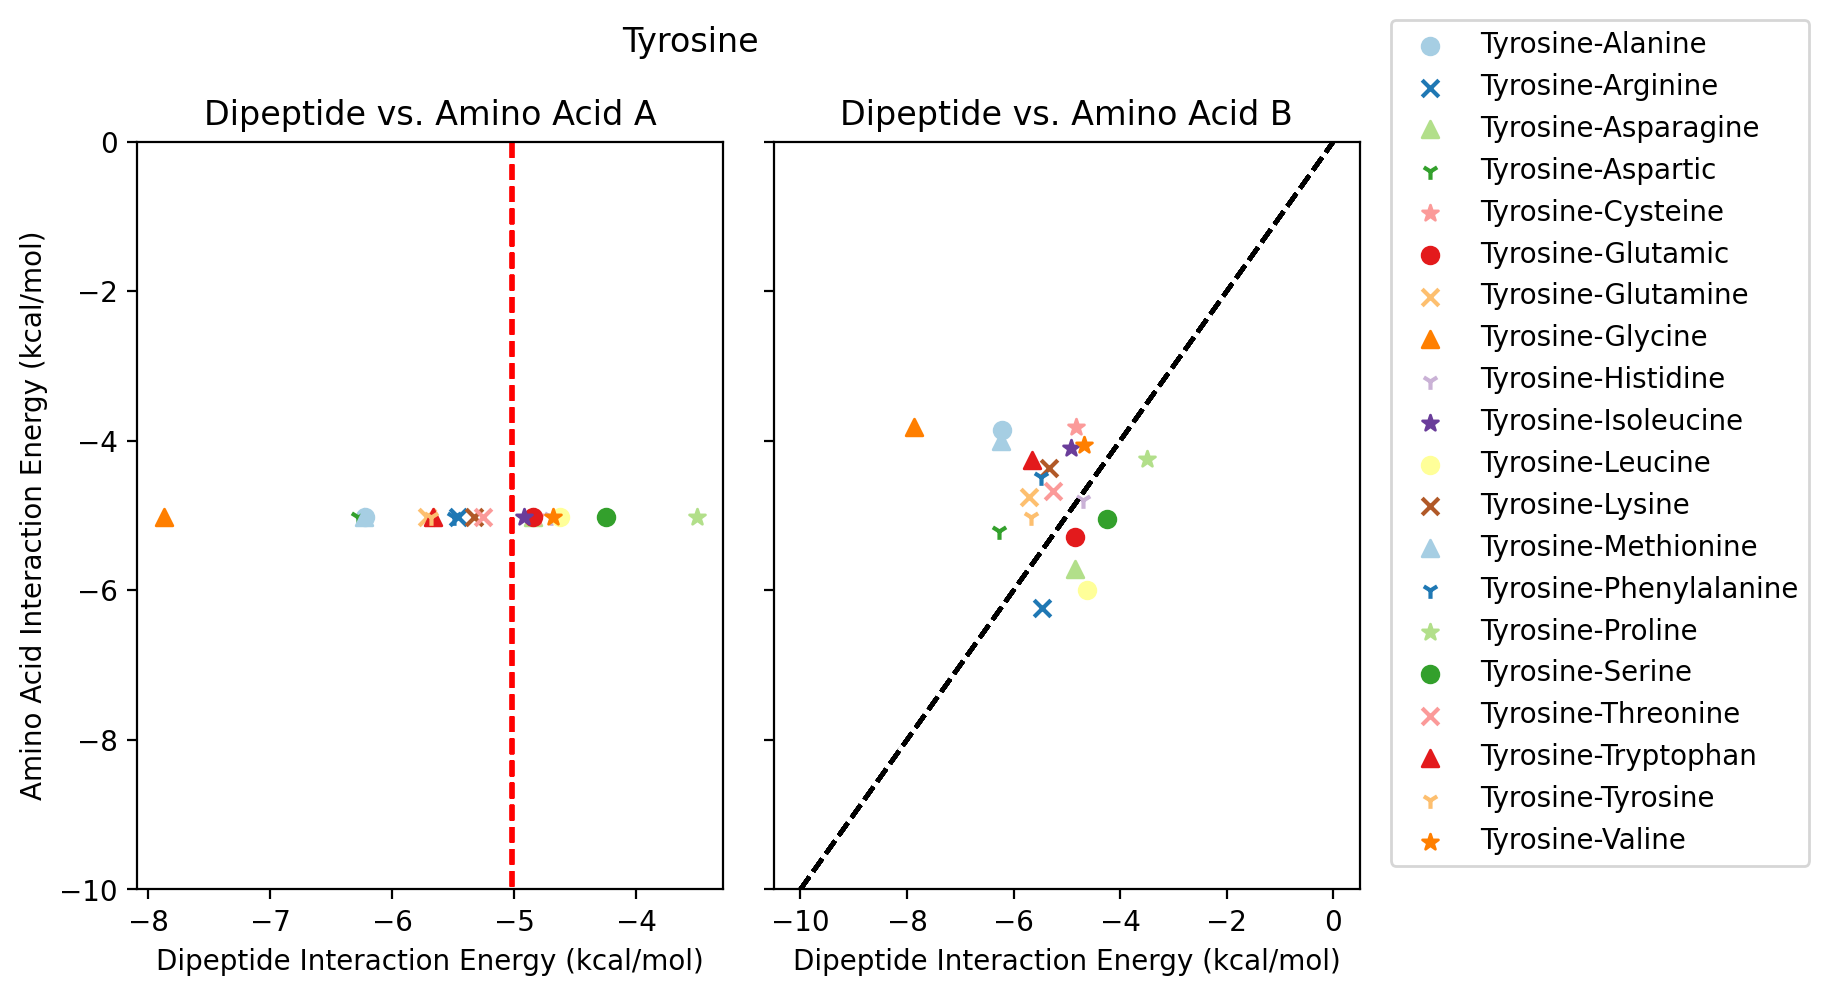

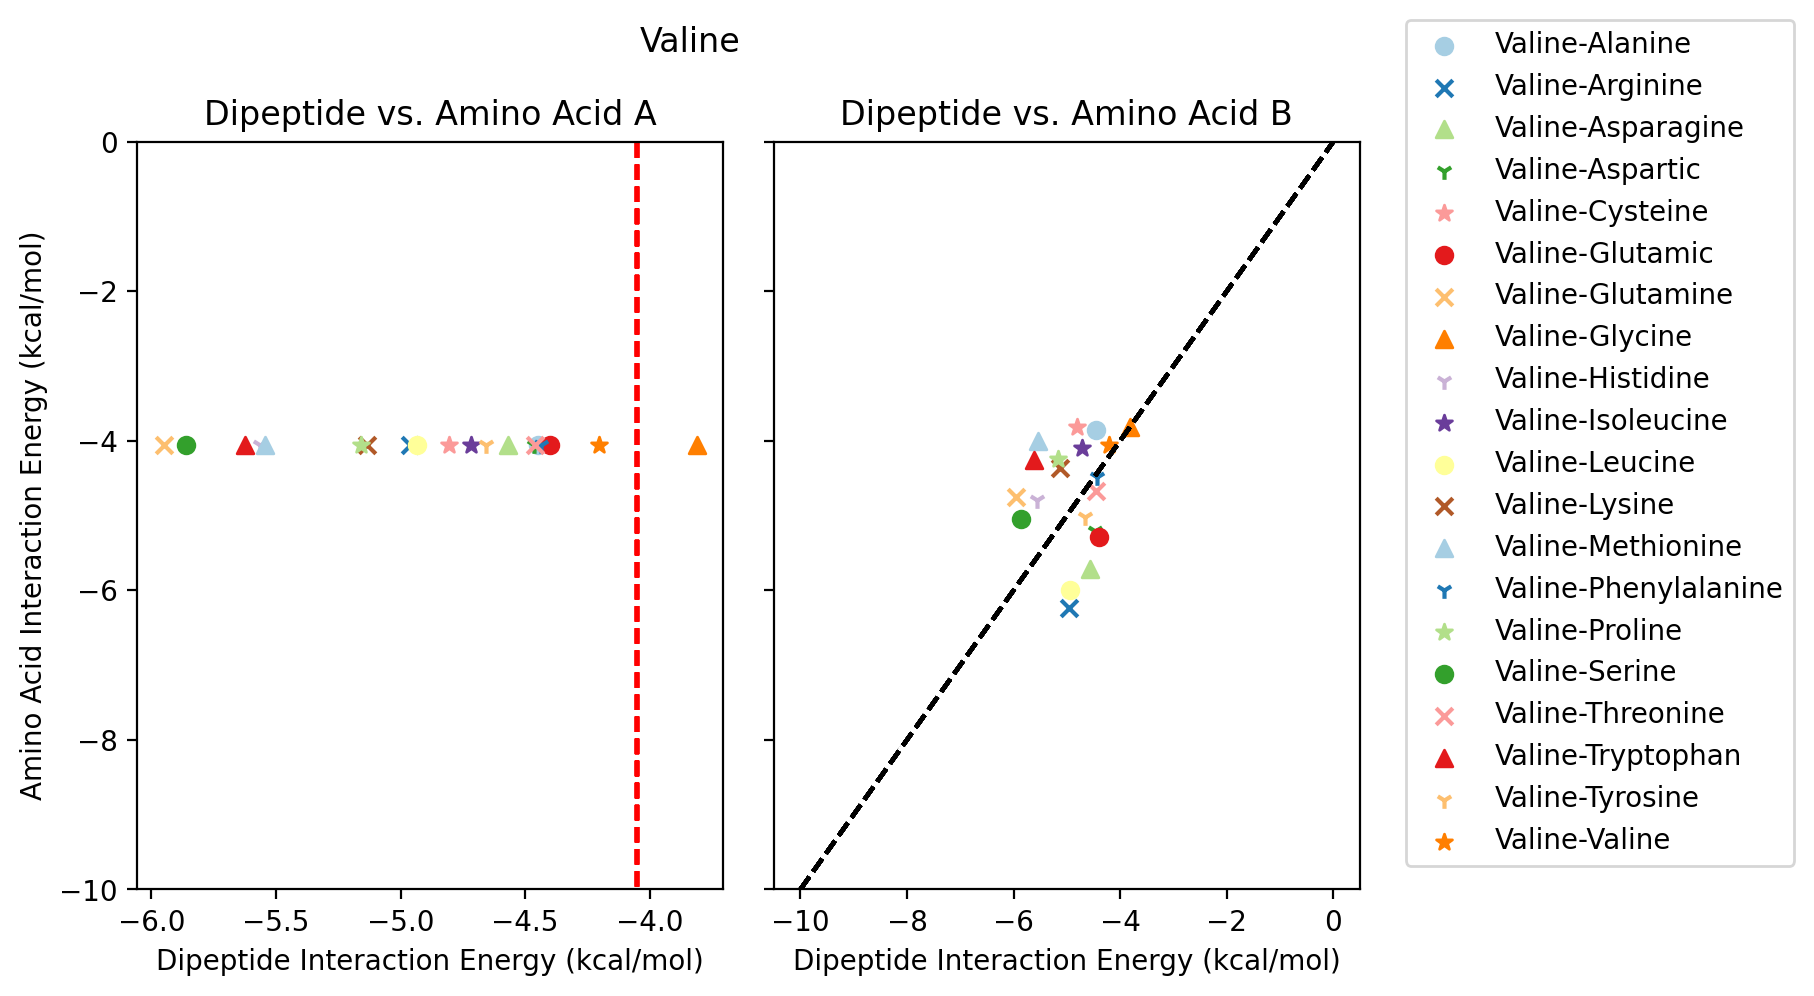

In [56]:
p=np.polyfit(AA_df.values.flatten(),AA_df.values.flatten(),deg=1)
y_ext=np.poly1d(p)(np.linspace(-10,0,100))    

for idx,A in enumerate(AA_df.index):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(7,5),sharey=True)
    for idxb,B in enumerate(AA_df.index):
        ax1.scatter(all_energies[A][B],AA_df.loc[A],label=f"{A}-{B}",color=palette[idxb],marker=markers[idxb%5],alpha=1)
        ax1.vlines(AA_df.loc[A],-12,0,color='red',linestyle='--')
        ax1.set_ylim(-10,0)
        # ax1.legend(bbox_to_anchor=(1.05,1.05))
        ax1.set_xlabel('Dipeptide Interaction Energy (kcal/mol)')
        ax1.set_ylabel('Amino Acid Interaction Energy (kcal/mol)')
        ax1.set_title('Dipeptide vs. Amino Acid A')
        
        ax2.scatter(all_energies[A][B],AA_df.loc[B],label=f"{A}-{B}",color=palette[idxb],marker=markers[idxb%5],alpha=1)
        ax2.plot(y_ext,y_ext,'k--')
        
        ax2.set_xlabel('Dipeptide Interaction Energy (kcal/mol)')
        ax2.set_title('Dipeptide vs. Amino Acid B')
        # ax2.ylabel('Amino Acid Interaction Energy (kcal/mol)')
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels,ncol=1,loc='upper center',bbox_to_anchor=(1.15,1))
    fig.suptitle(A)
    plt.tight_layout()
    # plt.savefig(f'{A}_dipeptide_vsAB.png',dpi=300,bbox_inches='tight')
    plt.show()

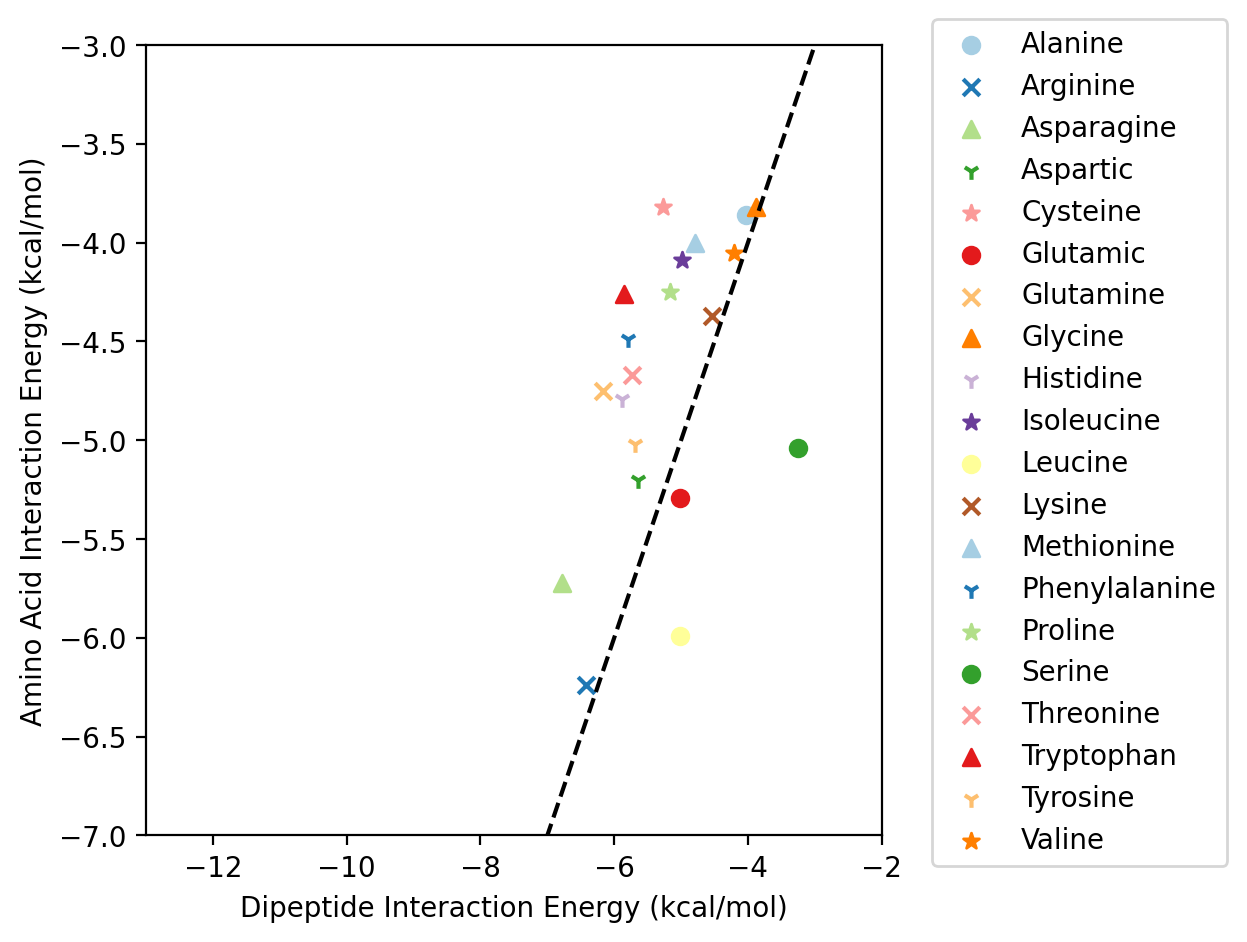

In [115]:
# plt.figure(figsize=(10,5))

for idx,A in enumerate(AA_df.index):
    plt.scatter(all_energies[A][A],AA_df.loc[A],label=A,color=palette[idx],marker=markers[idx%5],alpha=1)
    
p=np.polyfit(AA_df.values.flatten(),AA_df.values.flatten(),deg=1)
y_ext=np.poly1d(p)(np.linspace(-10,0,100))    
plt.plot(y_ext,y_ext,'k--')
plt.xlim(-13,-2)
plt.ylim(-7,-3)
plt.legend(bbox_to_anchor=(1.05,1.05))
plt.xlabel('Dipeptide Interaction Energy (kcal/mol)')
plt.ylabel('Amino Acid Interaction Energy (kcal/mol)')
plt.tight_layout()
# plt.savefig('20_AA_vs_DipepAA.png',dpi=300,bbox_inches='tight')
plt.show()

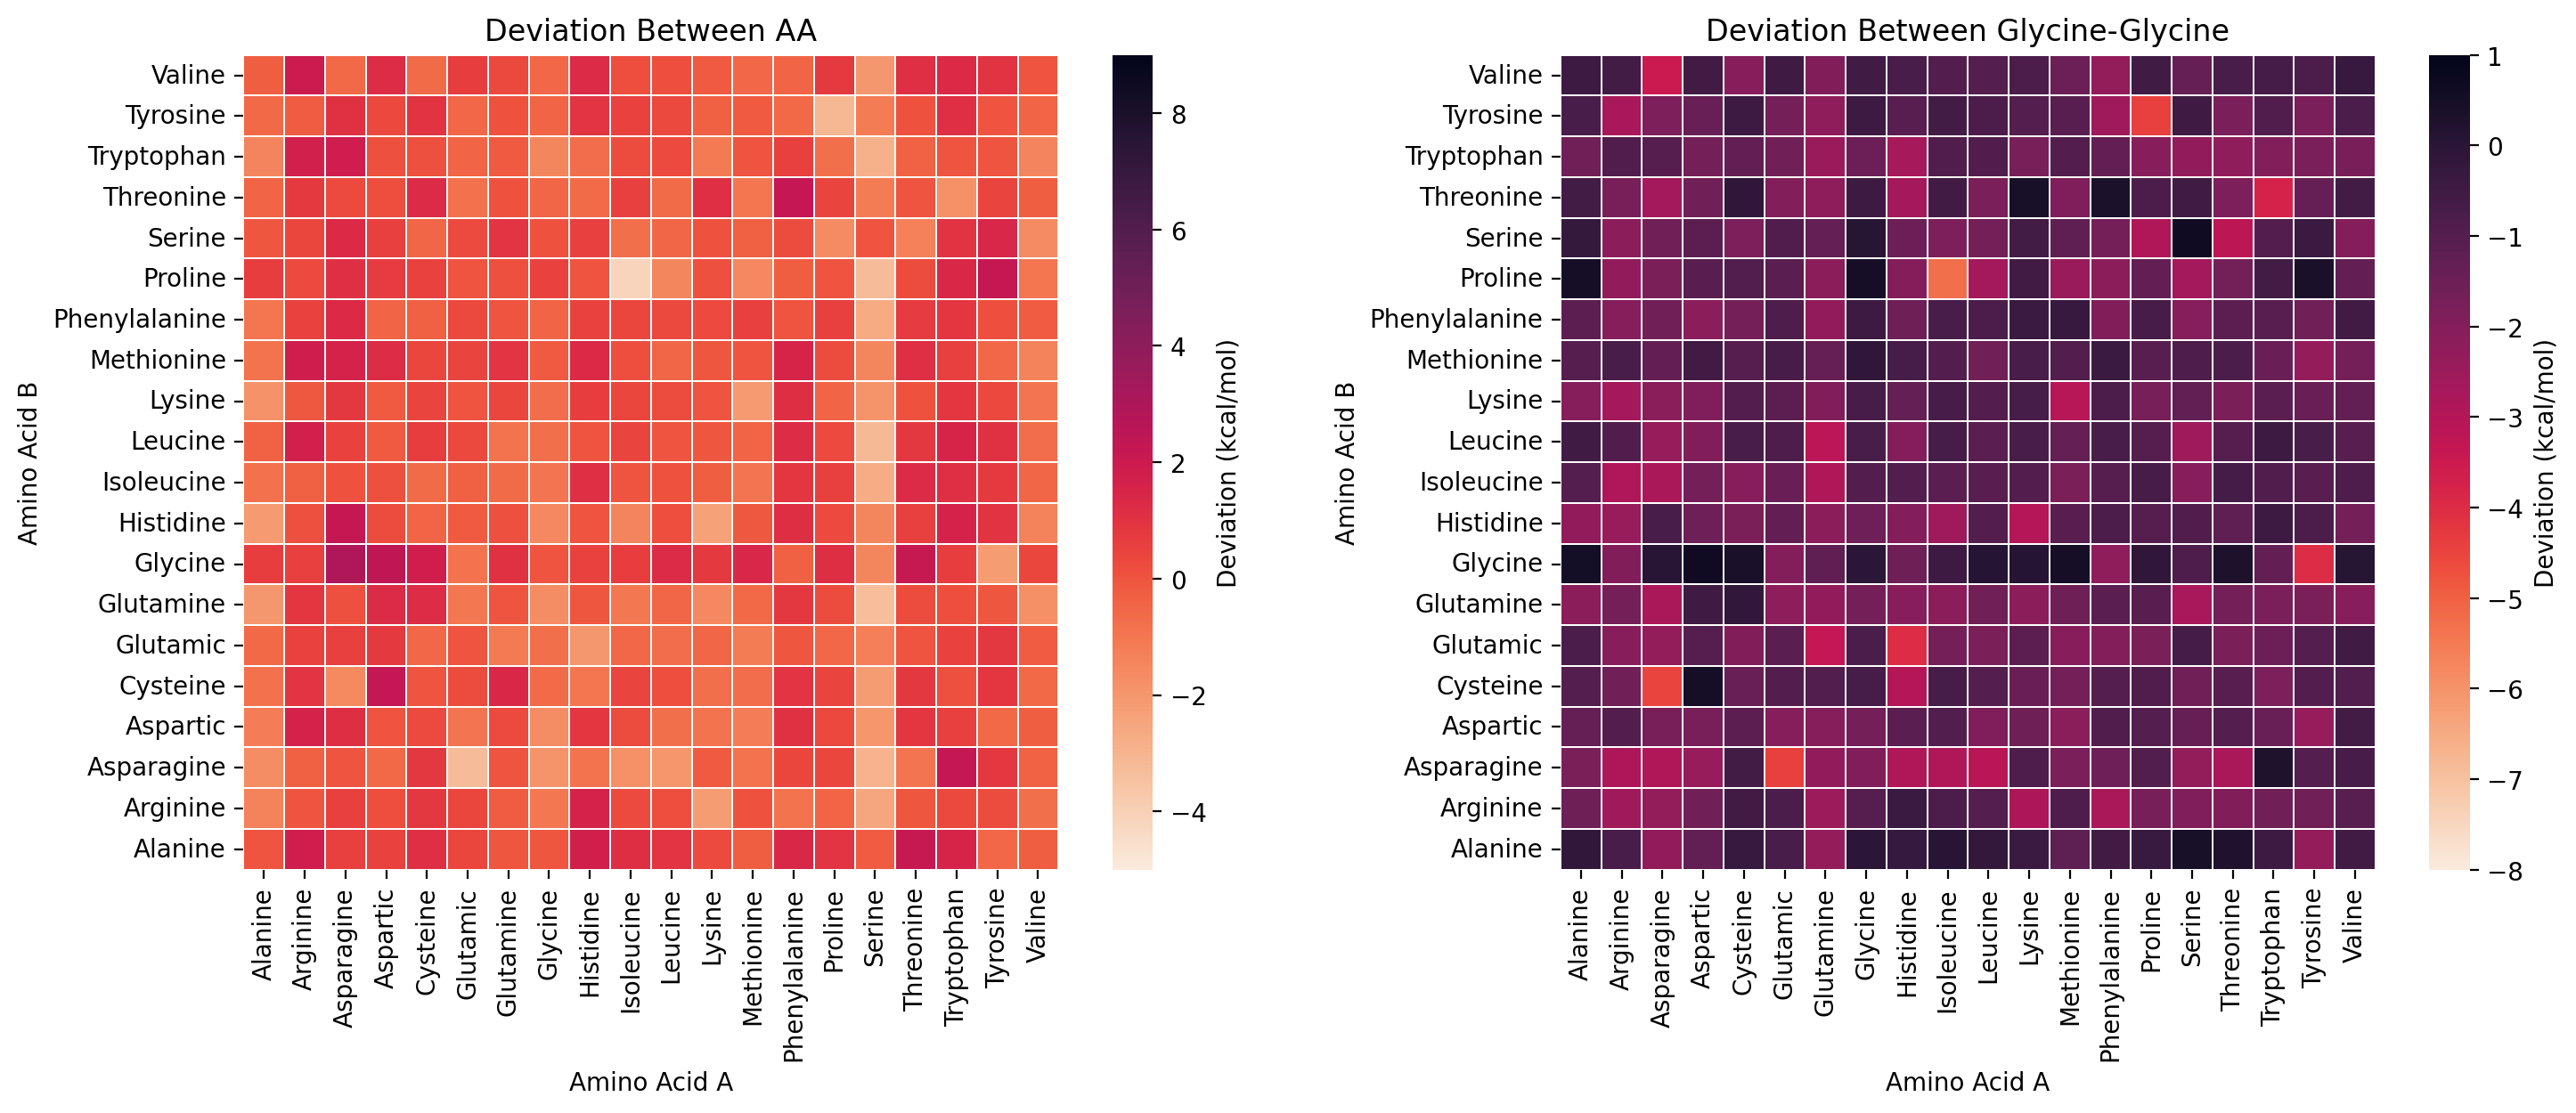

In [58]:
from matplotlib.colors import LinearSegmentedColormap

fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,6))
cmap = sns.cm.rocket_r
# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket'),sns.color_palette('rocket_r')]))
sns.heatmap(data=IE_df.astype(float),ax=ax1,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-5, vmax=9,square=True)
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Amino Acid B')
ax1.invert_yaxis()

# cmap = LinearSegmentedColormap.from_list('', np.vstack([sns.color_palette('rocket',8),sns.color_palette('rocket_r',3)]))
sns.heatmap(data=glygly_df.astype(float),ax=ax2,cmap=cmap, linewidth=.01,cbar_kws={'label': 'Deviation (kcal/mol)'}, vmin=-8, vmax=1,square=True)
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Amino Acid B')
ax2.invert_yaxis()
plt.tight_layout()
# plt.savefig(rdeviations.png',dpi=300,bbox_inches='tight')
plt.show()

In [59]:
site_df=df[sorted(sitelist)+['Interaction_Energy']].sort_values(by='Interaction_Energy')

In [60]:
site_df[site_df==0]=np.nan

In [61]:
len(sitelist)

8

In [62]:
[(i+1)%2 for i in range(8)]

[1, 0, 1, 0, 1, 0, 1, 0]

In [63]:
interdict_conv={'A_carboxy':'A Carboxyl', 'A_amine':'A Secondary Amine', 'A_link':'A Linking Hydrogen', 'A_side':'A Side-Chain','B_carboxy':'B Carboxylic Acid', 'B_amine':'B Primary Amine', 'B_link':'B Linking Hydrogen', 'B_side':'B Side-Chain'}

In [64]:


for i in sorted(set([i.strip('A_').strip('_B') for i in sitelist])):
    print(i)
    print(site_df.loc[site_df[f'A_{i}'].dropna().index]['Interaction_Energy'].describe())
    print(site_df.loc[site_df[f'B_{i}'].dropna().index]['Interaction_Energy'].describe())
    print()

amine
count    69.000000
mean     -5.473535
std       0.918054
min      -9.129920
25%      -6.032490
50%      -5.401066
75%      -4.718104
max      -3.258298
Name: Interaction_Energy, dtype: float64
count    94.000000
mean     -5.136808
std       0.884591
min      -8.385684
25%      -5.782293
50%      -4.886359
75%      -4.556084
max      -3.774012
Name: Interaction_Energy, dtype: float64

carboxy
count    210.000000
mean      -5.131966
std        0.859261
min       -8.313269
25%       -5.716147
50%       -4.939436
75%       -4.578118
max       -3.255937
Name: Interaction_Energy, dtype: float64
count    144.000000
mean      -5.273975
std        0.865053
min       -9.129920
25%       -5.799136
50%       -5.184471
75%       -4.679525
max       -3.569942
Name: Interaction_Energy, dtype: float64

link
count    17.000000
mean     -5.534842
std       0.920098
min      -8.273217
25%      -5.800714
50%      -5.552007
75%      -5.164778
max      -3.792406
Name: Interaction_Energy, dtype: float6

In [65]:
site_df.loc[site_df['A_amine'].dropna().index]['Interaction_Energy'].describe()

count    69.000000
mean     -5.473535
std       0.918054
min      -9.129920
25%      -6.032490
50%      -5.401066
75%      -4.718104
max      -3.258298
Name: Interaction_Energy, dtype: float64

In [66]:
site_df.loc[site_df['B_amine'].dropna().index]['Interaction_Energy'].describe()

count    94.000000
mean     -5.136808
std       0.884591
min      -8.385684
25%      -5.782293
50%      -4.886359
75%      -4.556084
max      -3.774012
Name: Interaction_Energy, dtype: float64

In [67]:
site_df

A_amine  A_carboxy  A_link  A_side  B_amine  B_carboxy  \
Isoleucine-Proline       1.0        NaN     NaN     NaN      NaN        1.0   
Asparagine-Cysteine      NaN        NaN     NaN     2.0      1.0        NaN   
Glutamic-Asparagine      NaN        2.0     NaN     NaN      NaN        NaN   
Proline-Tyrosine         NaN        NaN     1.0     1.0      NaN        NaN   
Histidine-Glutamic       NaN        NaN     NaN     1.0      NaN        2.0   
...                      ...        ...     ...     ...      ...        ...   
Methionine-Glycine       NaN        3.0     NaN     NaN      NaN        NaN   
Glycine-Proline          NaN        3.0     NaN     NaN      NaN        NaN   
Alanine-Glycine          NaN        3.0     NaN     NaN      NaN        NaN   
Aspartic-Glycine         1.0        NaN     NaN     2.0      NaN        NaN   
Serine-Serine            NaN        3.0     NaN     NaN      NaN        NaN   

                     B_link  B_side  Interaction_Energy  
Isoleucine-Proline      NaN     1.0           -9.129920  
Asparagine-Cysteine     NaN     NaN           -8.385684  
Glutamic-Asparagine     NaN     1.0           -8.313269  
Proline-Tyrosine        NaN     1.0           -8.273217  
Histidine-Glutamic      NaN     NaN           -7.889352  
...                     ...     ...                 ...  
Methionine-Glycine      NaN     NaN           -3.374341  
Glycine-Proline         NaN     NaN           -3.369284  
Alanine-Glycine         NaN     NaN           -3.359185  
Aspartic-Glycine        NaN     NaN           -3.258298  
Serine-Serine           NaN     NaN           -3.255937  

[400 rows x 9 columns]

['amine', 'carboxy', 'link', 'side']

In [69]:
sitelist

['A_carboxy',
 'A_amine',
 'B_carboxy',
 'B_amine',
 'A_link',
 'B_link',
 'A_side',
 'B_side']

In [70]:
pd.concat([site_df[site_df[i].isna()==False]['Interaction_Energy'].describe().rename(i) for i in sitelist],axis=1).to_excel('interaction_site_dist.xlsx')

In [213]:
site_df[site_df['A_amine'].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean']

-5.47

In [218]:
for sl in sorted(set([i.split('_')[1] for i in sitelist])):
    print("A_"+sl,site_df[site_df["A_"+sl].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean'])
    print("B_"+sl,site_df[site_df["B_"+sl].isna()==False]['Interaction_Energy'].describe().round(2).loc['mean'])
    print()

A_amine -5.47
B_amine -5.14

A_carboxy -5.13
B_carboxy -5.27

A_link -5.53
B_link -5.1

A_side -5.51
B_side -5.33



/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/604959672.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/604959672.py:7: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/604959672.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.col

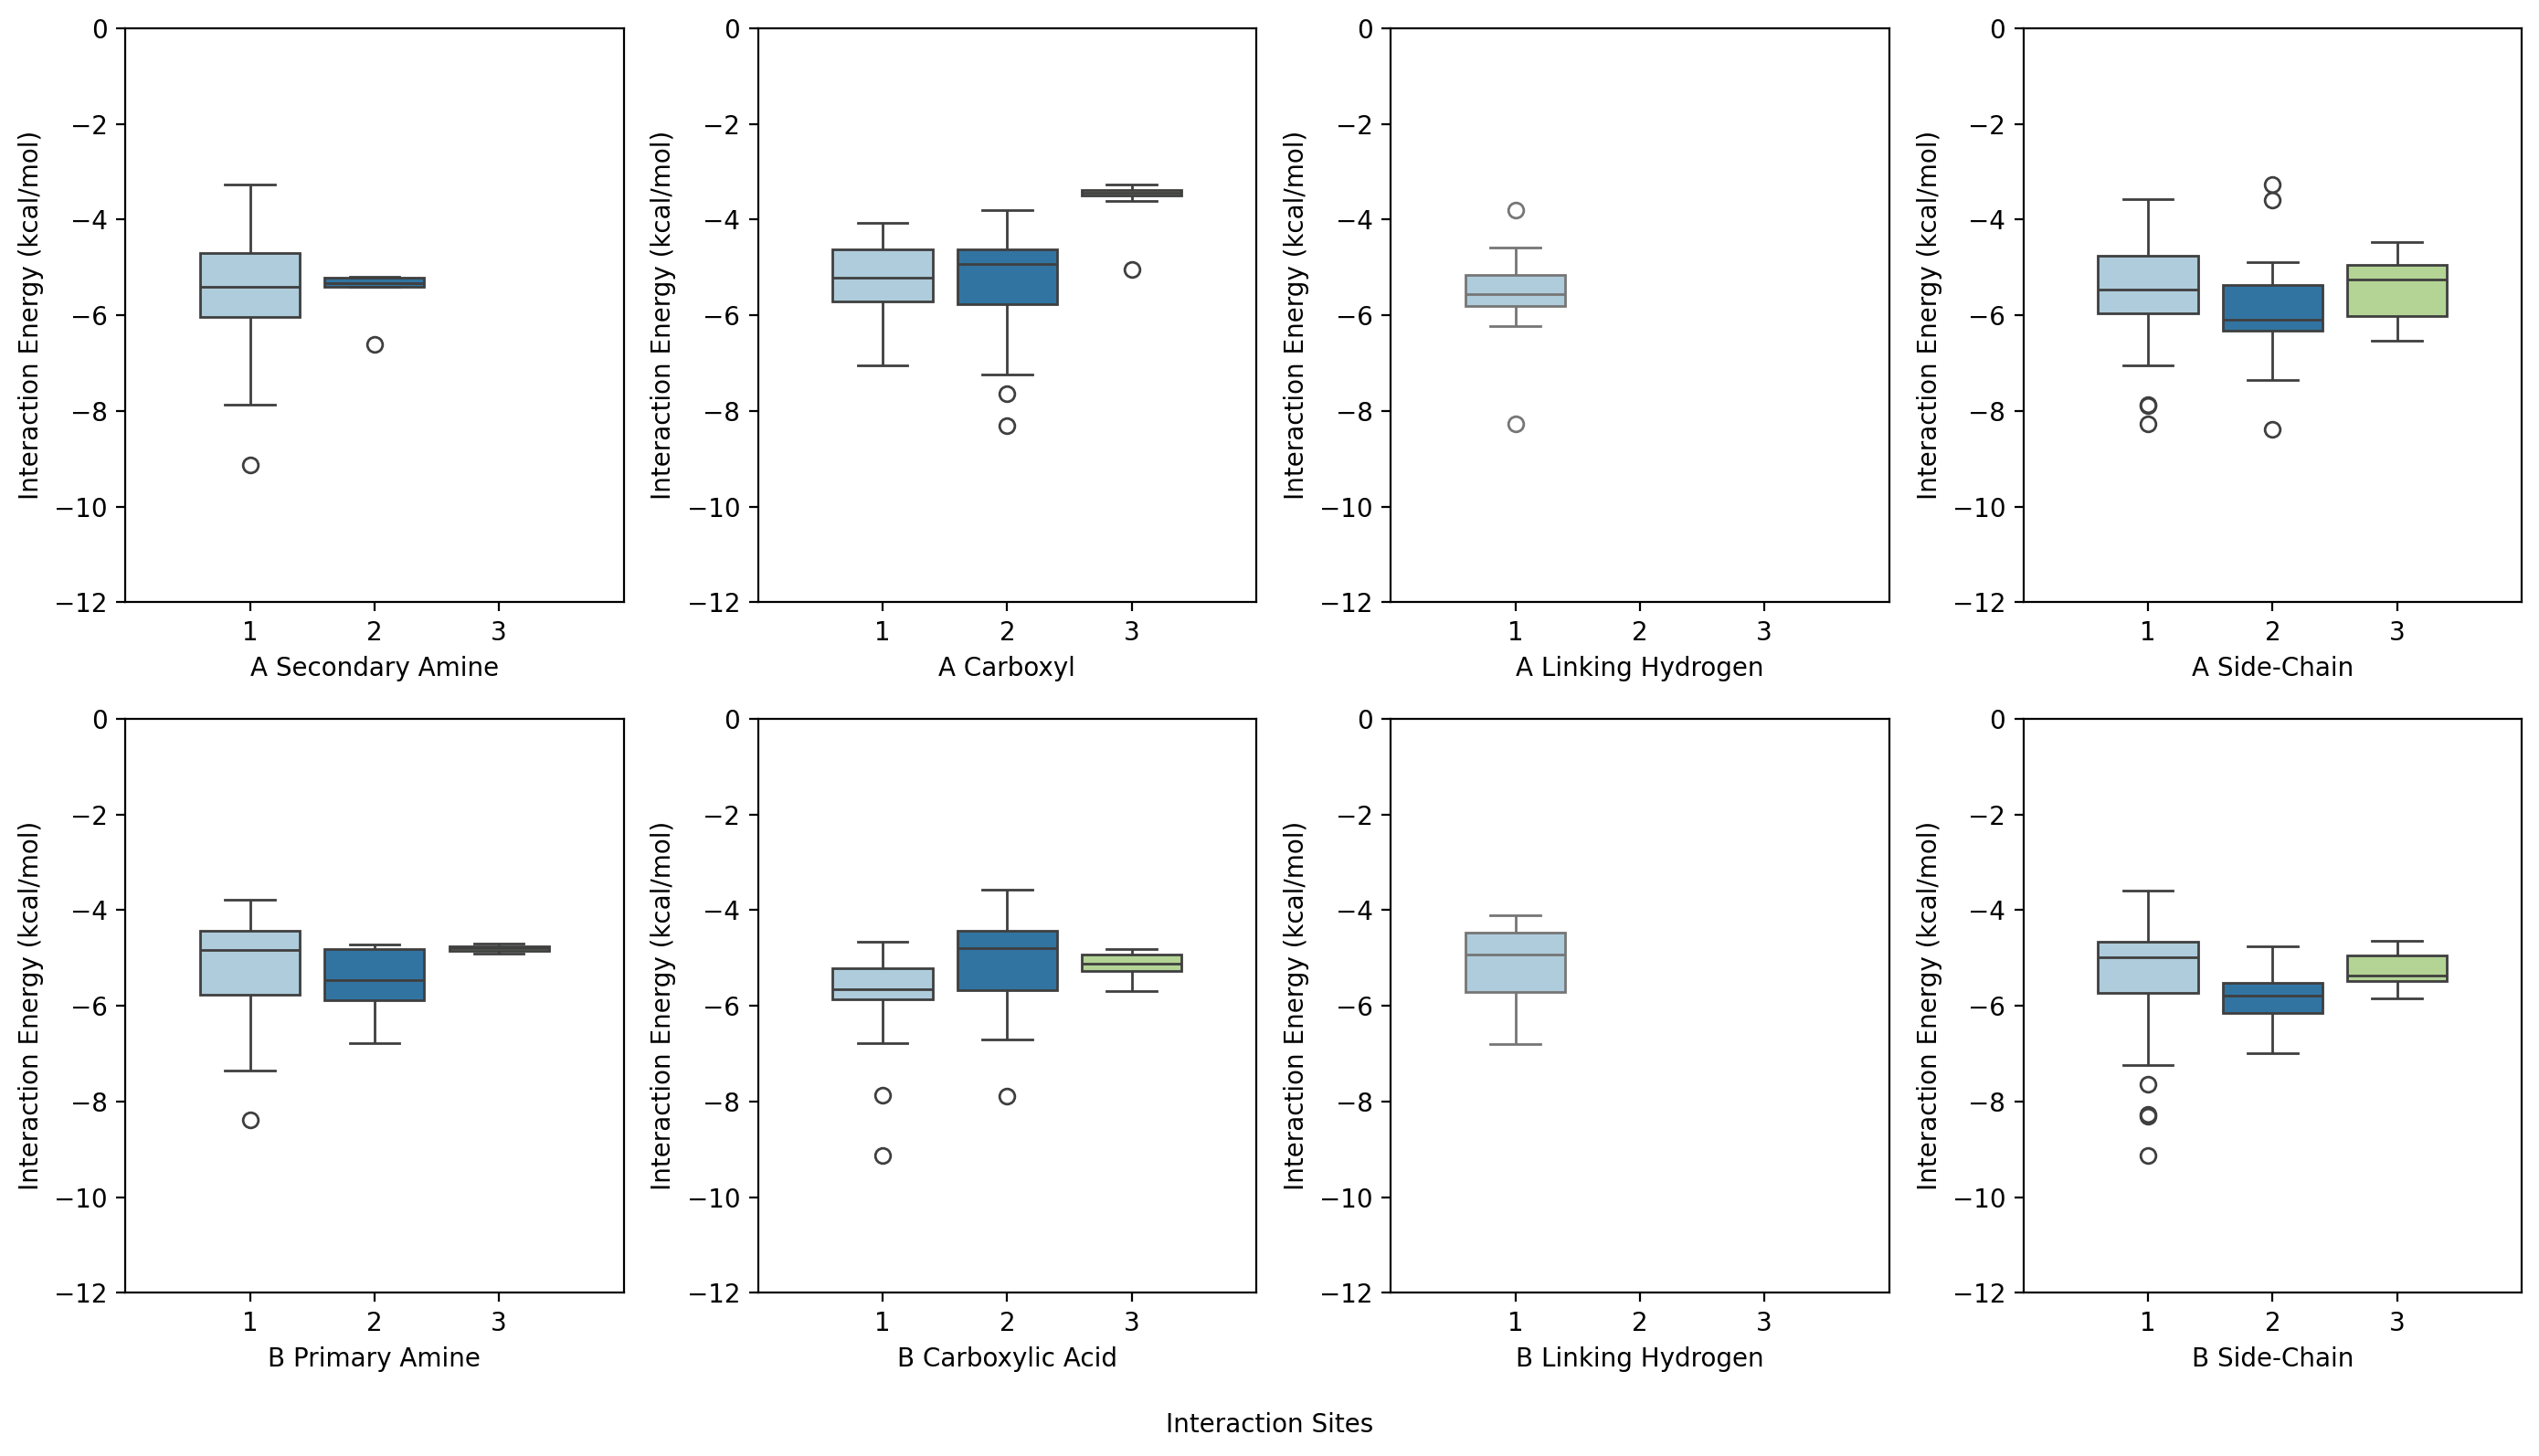

In [71]:
bardict=dict(zip(['amine', 'carboxy', 'link', 'side'],['Amine','Carboxy','Linker Hydrogen', 'Side']))
# fig,ax=plt.subplots(3,len(sitelist)//2,figsize=(15,10))
fig,ax=plt.subplots(2,len(sitelist)//2,figsize=(14,8))
for idx,i in enumerate(sorted(sitelist)):
    
    if idx<=3:
        sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[0,idx%4],palette=sns.color_palette('Paired',3))
        ax[0,idx%4].set_xticks([0,1,2])
        ax[0,idx%4].set_xticklabels([1,2,3])
        ax[0,idx%4].set_xlabel(interdict_conv[i])
        ax[0,idx%4].set_ylim(-12,0)
        ax[0,idx%4].set_xlim(-1,3)
        ax[0,idx%4].set_ylabel('Interaction Energy (kcal/mol)')
    else:
        sns.boxplot(data=site_df,x=i,y='Interaction_Energy',ax=ax[1,idx%4],palette=sns.color_palette('Paired',3))
        ax[1,idx%4].set_xticks([0,1,2])
        ax[1,idx%4].set_xticklabels([1,2,3])
        ax[1,idx%4].set_xlabel(interdict_conv[i])
        ax[1,idx%4].set_ylim(-12,0)
        ax[1,idx%4].set_xlim(-1,3)        
        ax[1,idx%4].set_ylabel('Interaction Energy (kcal/mol)')

    
# for idxx,j in enumerate(sorted(set([i.split('_')[1] for i in sitelist]))):
#     melted=pd.concat([site_df[f'A_{j}'].value_counts(),site_df[f'B_{j}'].value_counts()],axis=1).reset_index().melt(id_vars='index')
#     ax[2,idxx%4]=sns.barplot(data=melted,x='index',y='value',hue='variable',ax=ax[2,idxx%4],palette=sns.color_palette('Paired',2))
#     ax[2,idxx%4].set_xticks([0,1,2])
#     ax[2,idxx%4].set_xticklabels([1,2,3])    
#     ax[2,idxx%4].set_xlabel(j)
#     ax[2,idxx%4].set_ylim(0,160)
#     ax[2,idxx%4].set_xlim(-1,3)    
#     ax[2,idxx%4].set_ylabel('Count')
#     ax[2,idxx%4].set_xlabel(bardict[j])
    
fig.supxlabel('Interaction Sites',fontsize=10)
plt.tight_layout()
plt.savefig('boxplot.png',dpi=300,bbox_inches='tight')
plt.show()

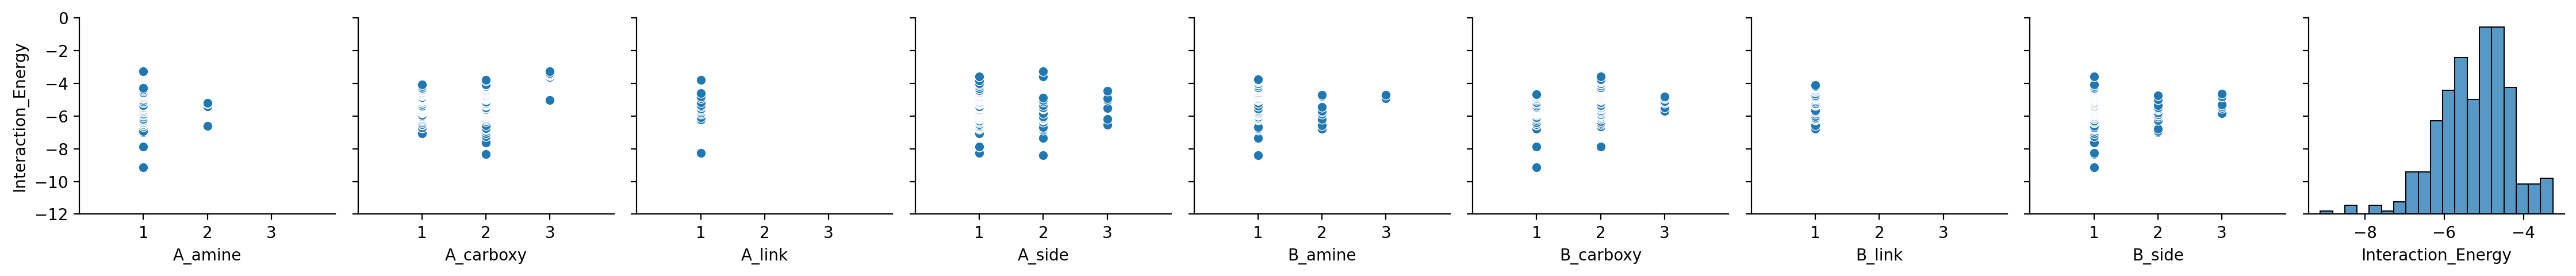

In [72]:
g=sns.pairplot(data=site_df,y_vars=['Interaction_Energy'])

for i in range(len(sitelist)):
    ax=g.axes[0,i]
    ax.set_xticks([1,2,3])
    ax.set_xticklabels([1,2,3])
    ax.set_xlim(0,4)
    ax.set_ylim(-12,0)
plt.tight_layout()
# plt.savefig('pairplot.png',dpi=300,bbox_inches='tight')
plt.show()

In [73]:
SerDF=site_df.loc[[i for i in site_df.index if 'Serine-' in i]]

SerList=[]
SerDict={}
for i in SerDF.index:
    subdf=SerDF[sitelist].loc[i]
    SerList.append(['/'.join(subdf.dropna().index),SerDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(SerList)[:,0]):
    SerDict[i]=[IE for nam,IE in SerList if nam==i]    

SerInt=pd.DataFrame.from_dict(SerDict,orient='index').T        


In [75]:
AspDF=site_df.loc[[i for i in site_df.index if 'Asparagine-' in i]]

AspList=[]
AspDict={}
for i in AspDF.index:
    subdf=AspDF[sitelist].loc[i]
    AspList.append(['/'.join(subdf.dropna().index),AspDF['Interaction_Energy'].loc[i]])
    

for i in set(np.array(AspList)[:,0]):
    AspDict[i]=[IE for nam,IE in AspList if nam==i]    
    
AspInt=pd.DataFrame.from_dict(AspDict,orient='index').T   



/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/3313177216.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
/var/folders/px/qyhp9b8j4bb0z5wgydzgkpxw0000gn/T/ipykernel_3500/3313177216.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")


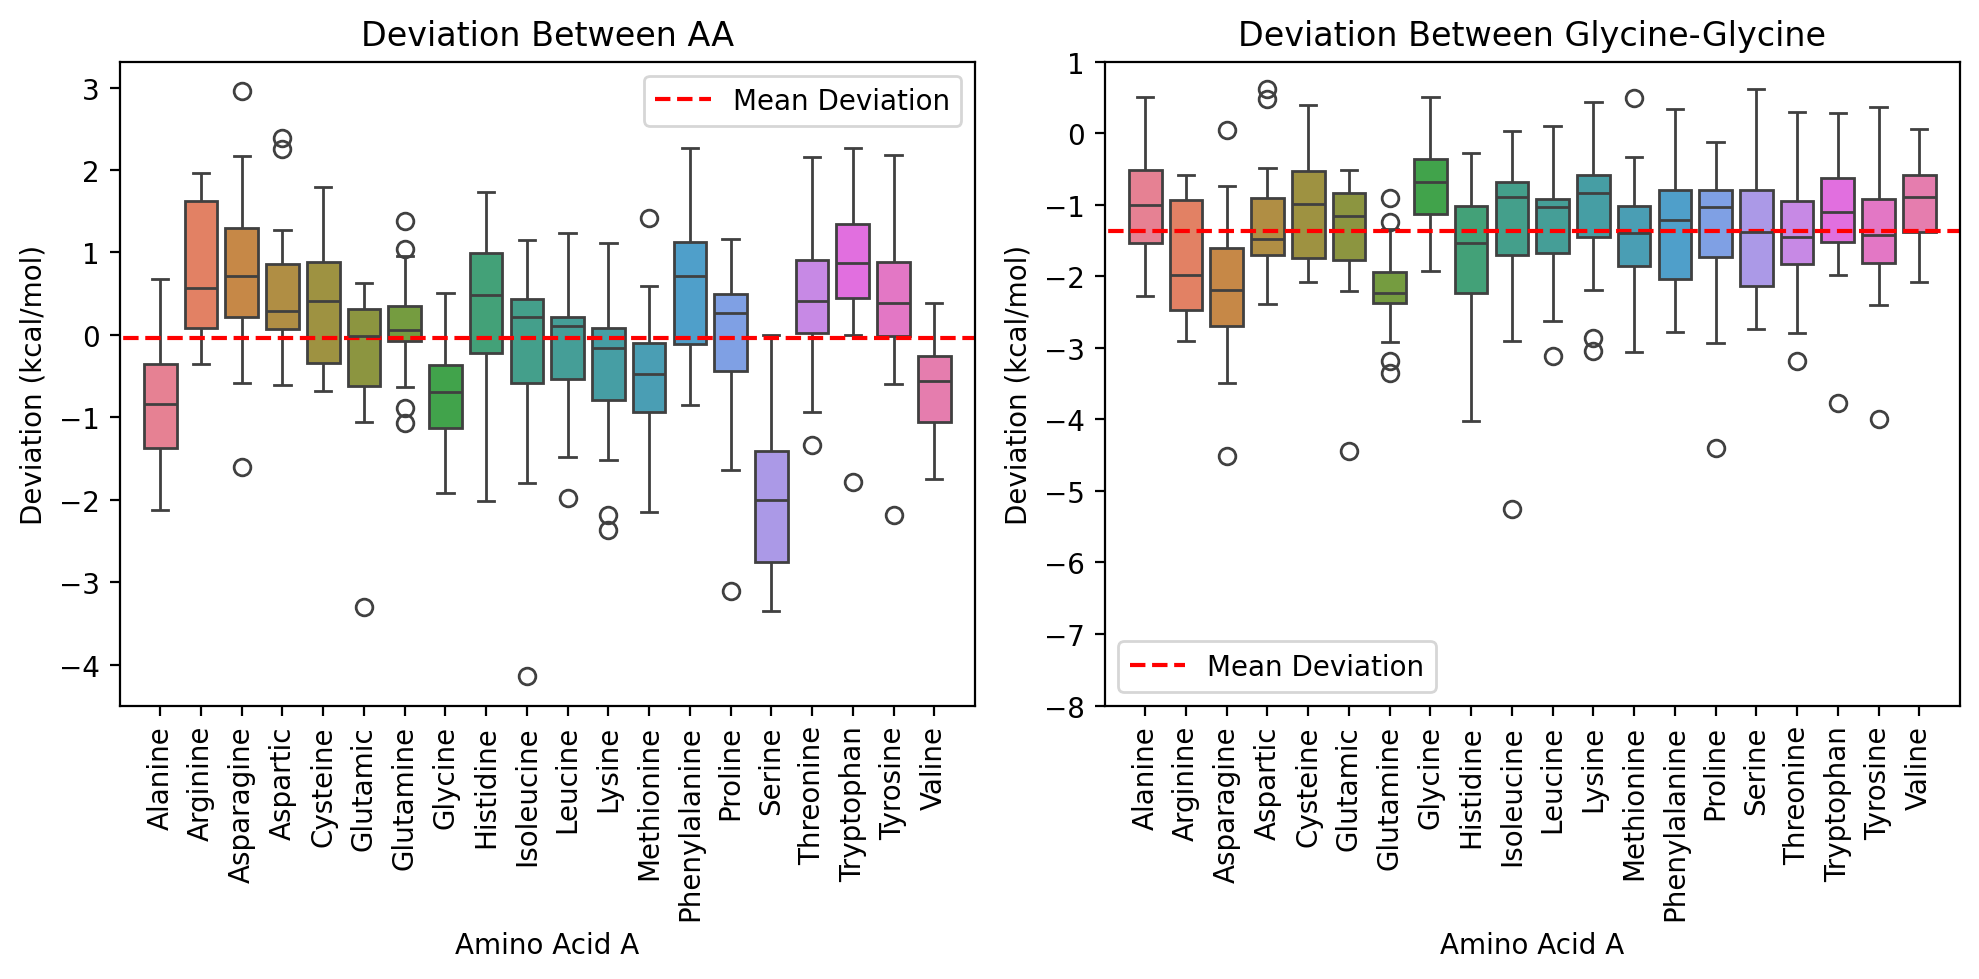

In [77]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
sns.boxplot(data=IE_df.astype(float),ax=ax1)
ax1.hlines(np.mean(IE_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax1.legend()
ax1.set_xlim(-1,20)
ax2.set_ylim(-5,9)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 90, ha="center")
ax1.set_title('Deviation Between AA')
ax1.set_xlabel('Amino Acid A')
ax1.set_ylabel('Deviation (kcal/mol)')

sns.boxplot(data=glygly_df.astype(float),ax=ax2)
ax2.hlines(np.mean(glygly_df.values.flatten()),-2,20,color='red',linestyles='--',label='Mean Deviation')
ax2.legend()
ax2.set_xlim(-1,20)
ax2.set_ylim(-8,1)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90, ha="center")
ax2.set_title('Deviation Between Glycine-Glycine')
ax2.set_xlabel('Amino Acid A')
ax2.set_ylabel('Deviation (kcal/mol)')
plt.tight_layout()
# plt.savefig('deviation_boxplots.png',dpi=300,bbox_inches='tight')
plt.tight_layout()

In [82]:
# from mpl_toolkits.mplot3d import Axes3D
# from matplotlib.colors import ListedColormap
# # axes instance
# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


# # plot
# # sc = ax.scatter(unX['level_0'].values, unX['level_1'].values, unX[0].values, s=40,c=unX[0].values, marker='o', cmap=cmap, alpha=1)
# X=Y=range(len(AAs))
# X, Y = np.meshgrid(X, Y)
# sc = ax.plot_surface(X,Y, unX[0].values.reshape(20,20), cmap=sns.cm.rocket_r)
# fig.colorbar(sc, shrink=0.5, aspect=5)

# ax.set_xlabel('Amino Acid A')
# ax.set_xticks(range(len(AAs)))
# ax.set_xticklabels(AAs)
# ax.set_yticks(range(len(AAs)))
# ax.set_yticklabels(AAs)
# ax.set_ylabel('Amino Acid B')
# ax.set_zlabel('Interaction Energy (kcal/mol)')
# plt.tight_layout()
# plt.show()

In [83]:
# # Create the MolGraph object
# mg = MolGraph()

# # Read the data from the .xyz file
# mg.read_xyz(monomerfiles[0])


# # Convert the molecular graph to the NetworkX graph
# G = to_networkx_graph(mg)

# # G.nodes(data=True),G.edges(data=True)

In [84]:
# from rdkit.Chem import rdFingerprintGenerator
# mols=[Chem.MolFromSmiles(list(pybel.readfile('xyz',m))[0].write().split('\t')[0]) for m in monomerfiles]
# fpgen = rdFingerprintGenerator.GetMorganGenerator(radius=6)

# # info={}
# # X = np.vstack([fpgen.GetFingerprint(mol) for mol in mols ])

# fps = [MACCSkeys.GenMACCSKeys(x) for x in mols]
# X=np.vstack([f.ToList() for f in fps])
# Y=y.values

# keys=pd.read_excel('MACCS_keys_example.xlsx',index_col='Key').drop(columns=['Unnamed: 0'])

# mol_keys=[idx for idx, i in enumerate(X[0]) if i==1]

# {str(keys.loc[idx].values[0]):i for idx, i in enumerate(np.count_nonzero(X,axis=0)) if i!=0}

In [85]:

# sns.heatmap([[DataStructs.TanimotoSimilarity(i,j) for i in fps] for j in fps],vmin=0,vmax=1,cmap=sns.cm.rocket_r)
# plt.show()

In [86]:
# Draw.MolsToGridImage(mols,molsPerRow=10, subImgSize=(300,300))